# Analysis of the ultrabroad source in field aa

The coordinates are roughly (ironically) 17:45:57.7530532310 -28:57:10.7694483833 ICRS.

## Detections

There are three confident (SNR > 10) lines detected (see [Fit lines](#Fit_lines)).

These are CS 2-1, SO 3(2)-2(1), SO 2(2)-1(1), and SO2 2(2,0)-3(1,3), in rough order of brightness (SO 32 may be brighter than CS 2-1).

No other lines are detected, and the H-bearing species appear to have restrictive upper limits (see [Overplot](# Overplot all the lines (to show nondetections)).

The pair of SO lines gives a temperature of roughly 15K.

The SO lines are optically thin, but at $\tau\sim0.1-0.2$, so it is not likely that the filling factor is small.  That puts the gas size at the source size, which is roughly 1".  The beam size is 1.5", but the source may be slightly resolved, giving a deconvolved size ~0.8".


In [2]:
%matplotlib inline
import pylab as pl
pl.rcParams['font.size'] = 14

In [3]:
from spectral_cube import SpectralCube
from astropy import units as u, constants
from astropy.coordinates import SkyCoord
import pyspeckit
import glob
import radio_beam

g++ -std=c++11   -Ofast -fopenmp -DNDEBUG -DHAVE_INLINE -MMD -MP -fPIC   -c -o pwind_geom.o pwind_geom.cpp


In file included from pwind_geom.cpp:2:
pwind_util.H:9:10: fatal error: gsl/gsl_sf_erf.h: No such file or directory
    9 | #include <gsl/gsl_sf_erf.h>
      |          ^~~~~~~~~~~~~~~~~~
compilation terminated.
make: *** [<builtin>: pwind_geom.o] Error 1


In [4]:
from astropy import stats

In [5]:
from astropy.modeling.functional_models import Gaussian2D
from astropy.modeling.fitting import LevMarLSQFitter
import numpy as np
from astropy.table import Table

In [6]:
import latex_info

In [7]:
path = '/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/'

In [8]:
cd $path

/orange/adamginsburg/ACES/rawdata/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working


In [9]:
ls -d *image

uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw25.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw27.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw29.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw31.cube.I.iter1.image/
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw33.cube.I.iter1.reclean.image@
uid___A001_X15a0_X13c.s38_0.Sgr_A_star_sci.spw35.cube.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw25.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw27.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw29.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw31.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw33.mfs.I.iter1.image/
uid___A001_X15a0_X13c.s8_0.Sgr_A_star_sci.spw35.mfs.I.iter1.image/


In [10]:
coord = SkyCoord("17:45:57.7530532310 -28:57:10.7694483833", unit=(u.h, u.deg), frame='icrs')
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [30]:
import regions

In [31]:
region = regions.RectangleSkyRegion(center=coord, width=15*u.arcsec, height=15*u.arcsec)

In [32]:
bigregion = regions.RectangleSkyRegion(center=coord, width=35*u.arcsec, height=35*u.arcsec)

In [34]:
# measure the surrounding ISM in an annulus
annulus = regions.CircleAnnulusSkyRegion(center=coord, inner_radius=3*u.arcsec, outer_radius=6*u.arcsec)

In [35]:
circle = regions.CircleSkyRegion(center=coord, radius=3*u.arcsec)

In [11]:
imgs = sorted(glob.glob("*.cube.*.image"))

In [12]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cubes = [SpectralCube.read(fn) for fn in imgs]

In [33]:
scubes = [cube.subcube_from_regions([region]) for cube in cubes]

In [13]:
pxcrd = [cube.wcs.celestial.world_to_pixel(coord) for cube in cubes]
spectra = [cube[:, int(y), int(x)].to(u.K) for cube, (x,y) in zip(cubes, pxcrd)]

In [14]:
pspectra = pyspeckit.Spectra([pyspeckit.Spectrum.from_hdu(sp.hdu) for sp in spectra])

INFO: Creating spectra [pyspeckit.spectrum.classes]
INFO: Concatenating data [pyspeckit.spectrum.classes]


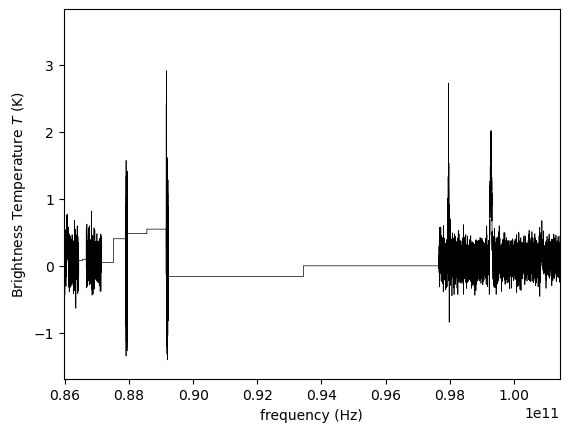

In [15]:
pspectra.plotter()

# Fit lines

In [16]:
from astroquery.splatalogue import Splatalogue
from astroquery.splatalogue.utils import minimize_table

In [17]:
#Splatalogue.query_lines(97.98095 * (1-30/3e5) *u.GHz, 97.98095 * (1+30/3e5)*u.GHz, energy_max=100, energy_type='eu_k')

In [18]:
nurest_so32 = 99.29987e9*u.Hz	
nurest_34so32 = 97.715317e9*u.Hz
nurest_so21 = 86.09395e9*u.Hz
nurest_cs21 = 97.98095e9*u.Hz
nurest_so45 = 100.02956e9*u.Hz
nurest_h13cop = 86.7543*u.GHz
nurest_c34s21 = 96.412951*u.GHz

### Table

In [19]:
measurement_table = []

### spw33 

In [20]:
# rough Jy to Kelvin estimate to change my guesses, that were in Jy, to K
JtoK = cubes[0].beam.jtok(cubes[0].spectral_axis).mean().value
JtoK

54.2808632681691

In [265]:
b3beam = cubes[0].beam
b3beam

Beam: BMAJ=1.9257872153987963 arcsec BMIN=1.5734451566902963 arcsec BPA=-71.8496817278145 deg

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.916434 +/-       0.0275603 
Param #1       SHIFT0 =  9.79603e+10 +/-          668082 
Param #2       WIDTH0 =  1.92385e+07 +/-          668082   Range:   [0,inf)
Param #3   AMPLITUDE1 =      1.71866 +/-       0.0253826 
Param #4       SHIFT1 =  9.92861e+10 +/-          386802 
Param #5       WIDTH1 =  2.26814e+07 +/-          386802   Range:   [0,inf) 
 Velocity width sigma(CS) = 58.87640757884788 km / s  FWHM(CS) =  138.35955781029253 km / s  VLSR(CS) =  63.288838560016764 km / s  SNR :  33.251929764963656 
 Velocity width sigma(SO) = 68.48604440209336 km / s  FWHM(SO) =  160.94220434491936 km / s  VLSR(SO) =  41.47102942141959 km / s  SNR :  67.71010763385557


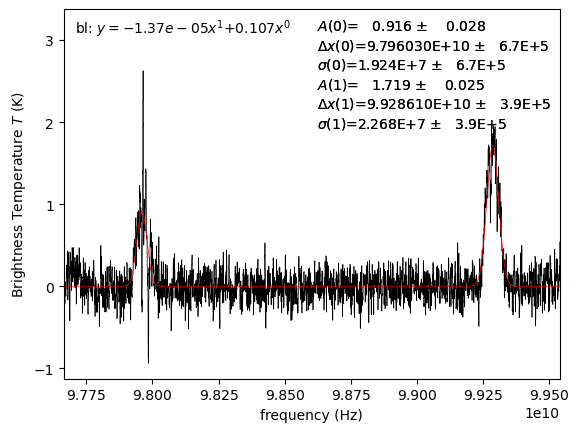

In [21]:
spw33 = pspectra[-2]
spw33.plotter()
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
spw33.baseline(excludefit=True)
spw33.specfit(guesses=[0.06*JtoK, 97.98e9, 97.8e9/3000, 0.06*JtoK, 99.3e9, 2e7])
#measurement_table.append(['CS 2-1', 97.98095e9] + list(zip(spw33.specfit.parinfo.values[:3], spw33.specfit.parinfo.errors[:3])))
#measurement_table.append(['SO 3(2)-2(1)', 99.2998e9] + list(zip(spw33.specfit.parinfo.values[3:6], spw33.specfit.parinfo.errors[3:6])))
                         
print(spw33.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spw33.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE0'].value / spw33.specfit.parinfo['AMPLITUDE0'].error,
      "\n Velocity width sigma(SO) =",
      spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spw33.specfit.parinfo['SHIFT1'].value - 99.2998e9) / 99.29987e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw33.specfit.parinfo['AMPLITUDE1'].value / spw33.specfit.parinfo['AMPLITUDE1'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =        1.032 +/-       0.0439775   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79656e+10 +/-     1.00287e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.28333e+07 +/-          923831   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.32644 +/-        0.105463   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          224555   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.52236e+06 +/-          245671   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.36715 +/-        0.154886   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79598e+10 +/-          144960   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =  1.13271e+06 +/-          152075   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.56388 +/-        0.197749   Ra

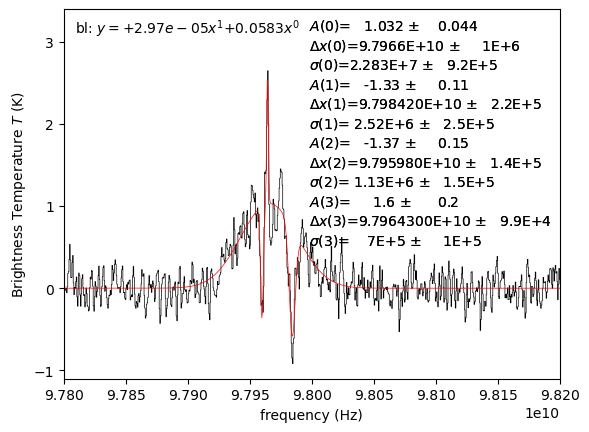

In [22]:
spw33 = pspectra[-2]
spcs = spw33.copy()
spcs.plotter(xmin=97.8e9, xmax=98.2e9)
spcs.specfit(guesses=[1, 97.98e9, 97.8e9/3000])
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[1, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.984e9, 1e6, # absorption feature
                      -0.5, 97.9594e9, 1e6, # absorption feature
                      0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))

print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS) = ",
      -(spcs.specfit.parinfo['SHIFT0'].value - 97.98095e9) / 97.98095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error,)

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =      1.86881 +/-       0.0305313   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.92858e+10 +/-          366324   Range:[9.91e+10,9.95e+10]
Param #2       WIDTH0 =  2.20066e+07 +/-          351100   Range: [0,4e+07]
Param #3   AMPLITUDE1 =    -0.664981 +/-        0.112909   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.93026e+10 +/-          208213   Range:[9.91e+10,9.95e+10]
Param #5       WIDTH1 =   1.0742e+06 +/-          215545   Range: [0,4e+07]
Param #6   AMPLITUDE2 =    -0.765812 +/-       0.0844522   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.92779e+10 +/-          247478   Range:[9.91e+10,9.95e+10]
Param #8       WIDTH2 =  1.99882e+06 +/-          267481   Range: [0,4e+07] 
 Velocity width sigma(SO) = 66.4487460235625 km / s  FWHM(SO

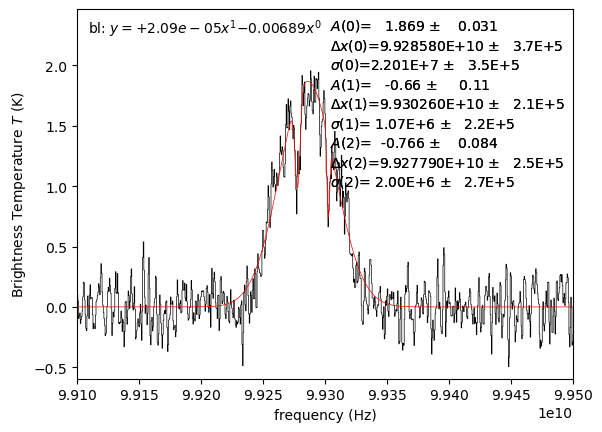

In [23]:
#SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=99.1e9, xmax=99.5e9)
spso.specfit(guesses=[1, 99.299e9, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_so32.to(u.Hz).value, 1e7, 
                      -0.5, 99.302e9, 1e6, # absorption feature
                      -0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (99.1e9, 99.5e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['SO 3-2', nurest_so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - 99.299095e9) / 99.299095e9 * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

In [24]:
nurest_34so32

<Quantity 9.7715317e+10 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.216353 +/-       0.0239146   Range:[0,2.71404]
Param #1       SHIFT0 =  9.77039e+10 +/-     2.60308e+06   Range:[9.71e+10,9.7775e+10]
Param #2       WIDTH0 =  2.03257e+07 +/-     2.72229e+06   Range: [0,4e+07] 
 Velocity width sigma(34SO) = 62.36702922223699 km / s  FWHM(SO) =  146.5625186722569 km / s  VLSR(SO) =  34.90459519481612 km / s  SNR :  9.046864654153985


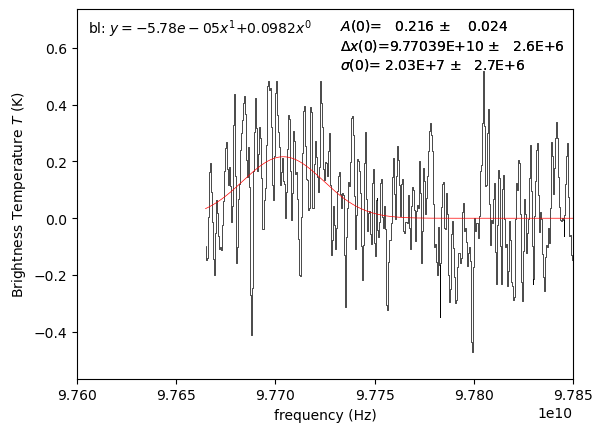

In [25]:
#34SO

spw33 = pspectra[-2]
spso = spw33.copy()
spso.plotter(xmin=97.6e9, xmax=97.85e9)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 97.8e9/3000])
spso.baseline(excludefit=True)
spso.specfit(guesses=[1, nurest_34so32.to(u.Hz).value, 1e7, 
                      #-0.5, 99.302e9, 1e6, # absorption feature
                      #-0.5, 99.277e9, 1e6, # absorption feature
                      #-0.5, 97.9594e9, 1e6, # absorption feature
                      #0.5, 97.964e9, 1e6, # narrow emission feature
                     ],
              limits=[(0, 0.05*JtoK), (97.1e9, 97.775e9), (0, 4e7),
                     ],
              limited=[(True, True)]*3)
measurement_table.append(['34SO 3-2', nurest_34so32.to(u.Hz).value] + list(zip(spso.specfit.parinfo.values[:3], spso.specfit.parinfo.errors[:3])))

print(spso.specfit.fitter.parinfo,
      "\n Velocity width sigma(34SO) =",
      spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spso.specfit.parinfo['WIDTH0'].value/spso.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO) = ",
      -(spso.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spso.specfit.parinfo['AMPLITUDE0'].value / spso.specfit.parinfo['AMPLITUDE0'].error,)

### spw25

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.382843 +/-       0.0261676 
Param #1       SHIFT0 =  8.60829e+10 +/-     1.53617e+06 
Param #2       WIDTH0 =  1.94643e+07 +/-     1.53617e+06   Range:   [0,inf) 
 Velocity width sigma(SO21) = 67.78625351080638 km / s  FWHM(SO) =  159.29769575039498 km / s  VLSR(SO2(2)-1(1)):  38.46949335809995 km / s  SNR :  14.630446729382609


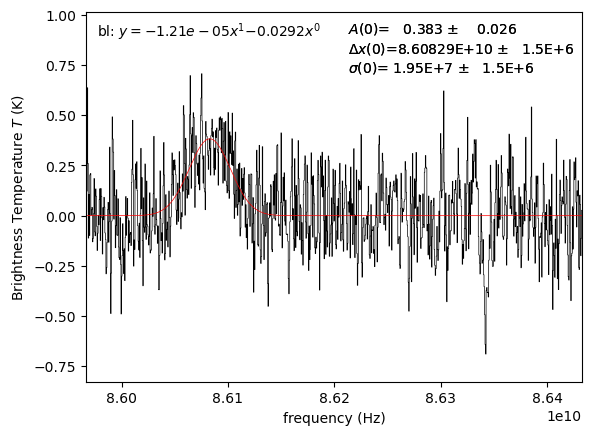

In [26]:
spw25 = pspectra[0]
spw25.data -= np.median(spw25.data) # contsub
spw25.plotter()
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
spw25.baseline(excludefit=True)
spw25.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw25.specfit.parinfo.values[:3], spw25.specfit.parinfo.errors[:3])))
print(spw25.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO21) =",
      spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO) = ",
      2.35*spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2(2)-1(1)): ",
      -(spw25.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw25.specfit.parinfo['AMPLITUDE0'].value / spw25.specfit.parinfo['AMPLITUDE0'].error
     )

### spw 27 (no detections)

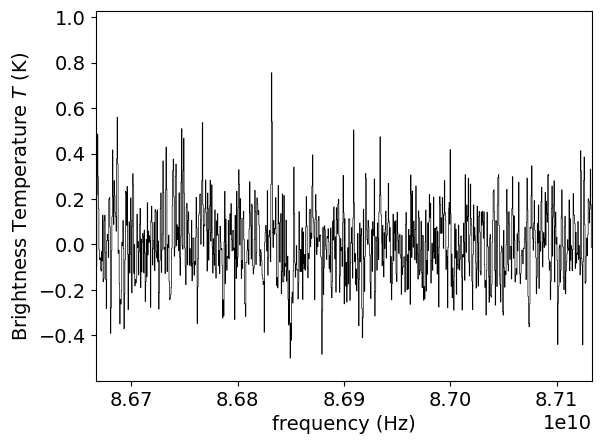

In [468]:
spw27 = pspectra[1]
spw27.data -= np.median(spw27.data) # contsub
spw27.plotter()
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#spw27.baseline(excludefit=True)
#spw27.specfit(guesses=[0.06*JtoK, 86.09395e9, 2e7])
#measurement_table.append(['SO 2(2)-1(1)', 86.09395e9] + list(zip(spw27.specfit.parinfo.values[:3], spw27.specfit.parinfo.errors[:3])))
#print(spw27.specfit.fitter.parinfo,
#      "\n Velocity width sigma(SO21) =",
#      spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " FWHM(SO) = ",
#      2.35*spw27.specfit.parinfo['WIDTH0'].value/spw27.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
#      " VLSR(SO2(2)-1(1)): ",
#      -(spw27.specfit.parinfo['SHIFT0'].value - 86.09395e9) / 86.09395e9 * constants.c.to(u.km/u.s),
#      " SNR : ", spw27.specfit.parinfo['AMPLITUDE0'].value / spw27.specfit.parinfo['AMPLITUDE0'].error
#     )

### spw 35

In [27]:
nurest_so45

<Quantity 1.0002956e+11 Hz>

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.171514 +/-       0.0286755   Range:[0.05,2.71404]
Param #1       SHIFT0 =  1.00875e+11 +/-     4.79635e+06   Range:[1.008e+11,1.009e+11]
Param #2       WIDTH0 =  2.48427e+07 +/-     4.79635e+06   Range:[1.5e+07,4e+07]
Param #3   AMPLITUDE1 =    0.0583502 +/-       0.0301321   Range:[0.05,2.71404]
Param #4       SHIFT1 =  1.00017e+11 +/-     1.09545e+07   Range:[9.99962e+10,1.00063e+11]
Param #5       WIDTH1 =      1.5e+07 +/-               0   Range:[1.5e+07,4e+07] 
 Velocity width sigma(SO2 220) = 73.8305414850214 km / s  FWHM(SO2) =  173.50177248980032 km / s  VLSR(SO2):  9.873140723249119 km / s  SNR :  5.981206517501485


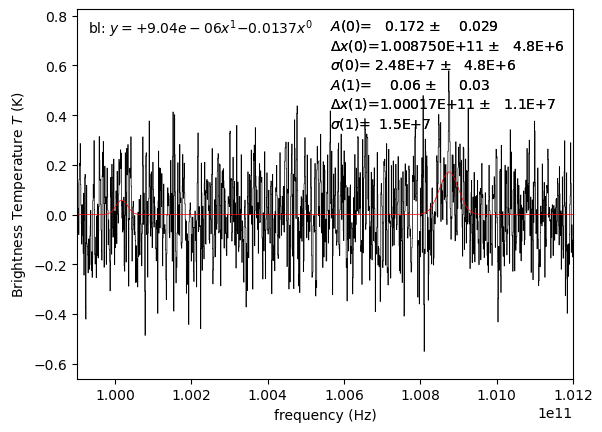

In [28]:
# Not a good fit

spw35 = pspectra[-1].copy()
spw35.data -= np.median(spw35.data) # contsub
spw35.plotter(xmin=99.9e9, xmax=101.2e9)
#spw35.plotter(xmin=100.55e9, xmax=101.2e9)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 1e7, 0.2, nurest_so45.to(u.Hz).value, 1e7],
              limits=[(0, 0.05*JtoK), (100.8e9, 100.9e9), (0, 4e7),
                      (0, 0.05*JtoK), (99.99e9, 100.2e9), (0, 4e7),
                     ], limited=[(True, True)]*6)
spw35.baseline(excludefit=True)
spw35.specfit(guesses=[0.006*JtoK, 100.878105e9, 2e7, 0.2, nurest_so45.to(u.Hz).value, 2e7],
              limits=[(0.05, 0.05*JtoK), (100.8e9, 100.9e9), (1.5e7, 4e7),
                      (0.05, 0.05*JtoK), (nurest_so45.value*(1-100/3e5), nurest_so45.value*(1+100/3e5)), (1.5e7, 4e7),
                     ], limited=[(True, True)]*6)
measurement_table.append(['SO2 2(2,0)-3(1,3)', 100.878105e9] + list(zip(spw35.specfit.parinfo.values[:3], spw35.specfit.parinfo.errors[:3])))
print(spw35.specfit.fitter.parinfo,
      "\n Velocity width sigma(SO2 220) =",
      spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(SO2) = ",
      2.35*spw35.specfit.parinfo['WIDTH0'].value/spw35.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(SO2): ",
      -(spw35.specfit.parinfo['SHIFT0'].value - 100.878105e9) / 100.878105e9 * constants.c.to(u.km/u.s),
      " SNR : ", spw35.specfit.parinfo['AMPLITUDE0'].value / spw35.specfit.parinfo['AMPLITUDE0'].error
     )
#spw35.specfit.parinfo

## Tsuboi C34S

In [259]:
fns_2012 = sorted(glob.glob("/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/*.image.pbcor.fits"))
scubes2012 = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_2012]
fns_2012

['/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw0_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw1_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw2_cube.image.pbcor.fits',
 '/orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/GC50MC_spw3_cube.image.pbcor.fits']

In [37]:
c34scube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_c34s21 and scube.spectral_axis.max() > nurest_c34s21][0]
c34scube_2012

VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3712  type_s: FREQ      unit_s: Hz     range: 96180400540.670 Hz:97086349711.145 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.138535 +/-       0.0213704   Range:[0,2.71404]
Param #1       SHIFT0 =  9.63966e+10 +/-     3.40094e+06   Range:[9.62e+10,9.7e+10]
Param #2       WIDTH0 =  1.90922e+07 +/-     3.40094e+06   Range: [0,4e+07] 
 Velocity width sigma(C34S) = 59.37652055823241 km / s  FWHM(C34S) =  139.53482331184617 km / s  VLSR(C34s):  50.77006796531648 km / s  SNR :  6.4825676517965825


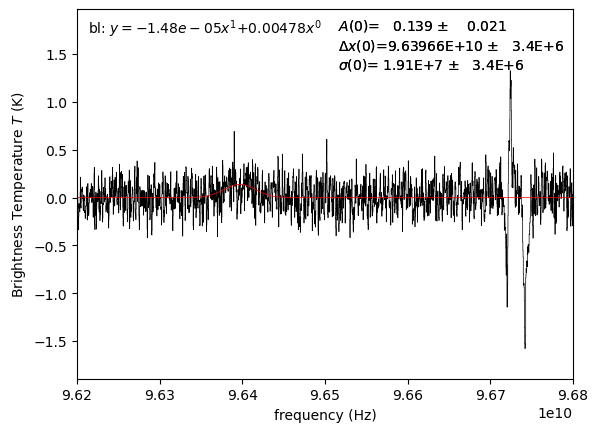

In [38]:
cube = c34scube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spc34s = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

nurest_c34s21 = 96.412951*u.GHz

spc34s.data -= np.median(spc34s.data) # contsub
spc34s.plotter(xmin=96.2e9, xmax=96.8e9)
#spc34s.plotter(xmin=100.55e9, xmax=101.2e9)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spc34s.baseline(excludefit=True)
spc34s.specfit(guesses=[0.006*JtoK, nurest_c34s21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (96.2e9, 97e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['C34S 2-1', nurest_c34s21.to(u.Hz).value] + list(zip(spc34s.specfit.parinfo.values[:3], spc34s.specfit.parinfo.errors[:3])))
print(spc34s.specfit.fitter.parinfo,
      "\n Velocity width sigma(C34S) =",
      spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(C34S) = ",
      2.35*spc34s.specfit.parinfo['WIDTH0'].value/spc34s.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(C34s): ",
      -(spc34s.specfit.parinfo['SHIFT0'].value - nurest_c34s21.to(u.Hz).value) / nurest_c34s21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spc34s.specfit.parinfo['AMPLITUDE0'].value / spc34s.specfit.parinfo['AMPLITUDE0'].error
     )

## Tsuboi CS

In [39]:
cscube_2012 = [scube for scube in scubes2012 if scube.spectral_axis.min() < nurest_cs21 and scube.spectral_axis.max() > nurest_cs21][0]
cscube_2012

VaryingResolutionSpectralCube with shape=(3840, 60, 60) and unit=Jy / beam:
 n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
 n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
 n_s:   3840  type_s: FREQ      unit_s: Hz     range: 97512362524.760 Hz:98449559739.802 Hz

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.538484 +/-       0.0274834   Range:[-2,2.71404]
Param #1       SHIFT0 =  9.79676e+10 +/-     1.14218e+06   Range:[9.77e+10,9.83e+10]
Param #2       WIDTH0 =  2.20131e+07 +/-     1.06991e+06   Range: [0,4e+07]
Param #3   AMPLITUDE1 =     -1.10444 +/-       0.0718508   Range:[-2,2.71404]
Param #4       SHIFT1 =  9.79842e+10 +/-          152122   Range:[9.77e+10,9.83e+10]
Param #5       WIDTH1 =  2.07609e+06 +/-          163847   Range: [0,4e+07]
Param #6   AMPLITUDE2 =     -1.17159 +/-        0.105372   Range:[-2,2.71404]
Param #7       SHIFT2 =  9.79604e+10 +/-          116987   Range:[9.77e+10,9.83e+10]
Param #8       WIDTH2 =       961798 +/-          123409   Range: [0,4e+07]
Param #9   AMPLITUDE3 =      1.41337 +/-        0.101357   Ra

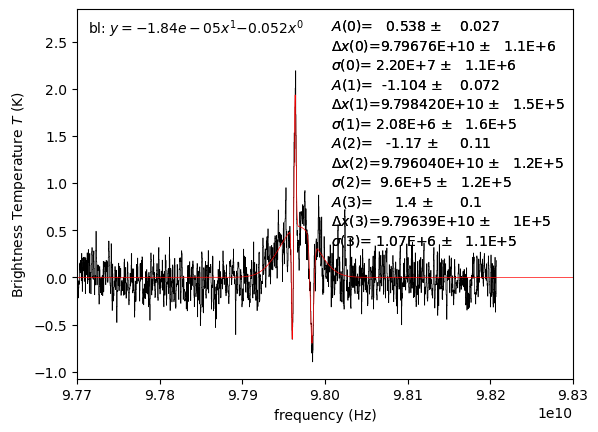

In [40]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
spcs = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

spcs.data -= np.median(spcs.data) # contsub
spcs.plotter(xmin=97.7e9, xmax=98.3e9)
#spcs.plotter(xmin=100.55e9, xmax=101.2e9)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
spcs.baseline(excludefit=True)
spcs.specfit(guesses=[0.006*JtoK, nurest_cs21.to(u.Hz).value, 1e7, 
                      -0.5, 97.985e9, 1e6, # absorption feature
                      -0.5, 97.96e9, 1e6, # absorption feature
                      0.5, 97.965e9, 1e6, # narrow emission feature
                     ],
              limits=[(-2, 0.05*JtoK), (97.7e9, 98.3e9), (0, 4e7),
                     ]*4,
              limited=[(True, True)]*3*4)
measurement_table.append(['CS 2-1 (2012)', nurest_cs21.to(u.Hz).value] + list(zip(spcs.specfit.parinfo.values[:3], spcs.specfit.parinfo.errors[:3])))
print(spcs.specfit.fitter.parinfo,
      "\n Velocity width sigma(CS) =",
      spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(CS) = ",
      2.35*spcs.specfit.parinfo['WIDTH0'].value/spcs.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(CS): ",
      -(spcs.specfit.parinfo['SHIFT0'].value - nurest_cs21.to(u.Hz).value) / nurest_cs21.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", spcs.specfit.parinfo['AMPLITUDE0'].value / spcs.specfit.parinfo['AMPLITUDE0'].error
     )

Error 'FigureManagerBase' object has no attribute 'key_press' was raised when trying to connect the key_press handler.  Please file an issue on github.  You may try a different matplotlib backend as a temporary workaround
Param #0   AMPLITUDE0 =     0.129268 +/-       0.0146529   Range:[0,2.71404]
Param #1       SHIFT0 =  9.76974e+10 +/-     3.05841e+06   Range:[9.75e+10,9.81e+10]
Param #2       WIDTH0 =  2.33691e+07 +/-     3.05841e+06   Range: [0,4e+07] 
 Velocity width sigma(34so) = 71.70993531201097 km / s  FWHM(34so) =  168.51834798322577 km / s  VLSR(34so):  54.819979936973525 km / s  SNR :  8.8220133544466


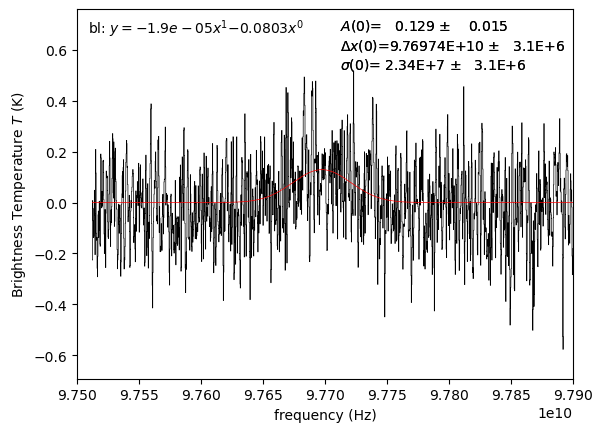

In [41]:
cube = cscube_2012
pxcrd = cube.wcs.celestial.world_to_pixel(coord)
x,y=pxcrd
sp34so = pyspeckit.Spectrum.from_hdu(cube[:, int(y), int(x)].to(u.K).hdu)

sp34so.data -= np.median(sp34so.data) # contsub
sp34so.plotter(xmin=97.5e9, xmax=97.9e9)
#sp34so.plotter(xmin=100.55e9, xmax=101.2e9)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
sp34so.baseline(excludefit=True)
sp34so.specfit(guesses=[0.006*JtoK, nurest_34so32.to(u.Hz).value, 1e7, ],
              limits=[(0, 0.05*JtoK), (97.5e9, 98.1e9), (0, 4e7),
                     ], limited=[(True, True)]*3)
measurement_table.append(['34SO 3-2 (2012)', nurest_34so32.to(u.Hz).value] + list(zip(sp34so.specfit.parinfo.values[:3], sp34so.specfit.parinfo.errors[:3])))
print(sp34so.specfit.fitter.parinfo,
      "\n Velocity width sigma(34so) =",
      sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " FWHM(34so) = ",
      2.35*sp34so.specfit.parinfo['WIDTH0'].value/sp34so.specfit.parinfo['SHIFT0'].value * constants.c.to(u.km/u.s),
      " VLSR(34so): ",
      -(sp34so.specfit.parinfo['SHIFT0'].value - nurest_34so32.to(u.Hz).value) / nurest_34so32.to(u.Hz).value * constants.c.to(u.km/u.s),
      " SNR : ", sp34so.specfit.parinfo['AMPLITUDE0'].value / sp34so.specfit.parinfo['AMPLITUDE0'].error
     )

### Spectral Measurement Table

In [191]:
latexdict = latex_info.latexdict.copy()
latexdict['header_start'] = r'\label{tab:spectral_measurements}'
latexdict['caption'] = 'Spectral Line Measurements'
latexdict['preamble'] = r'\centering'
formats = {'Amplitude': lambda x: "{0:0.3f}".format(x),
           'Amp': lambda x: "{0:0.3f}".format(x),
           'Center': lambda x: "{0:0.3f}".format(x),
           'Velocity Center': lambda x: "{0:0.3f}".format(x),
           '$v_{cen}$': lambda x: "{0:0.3f}".format(x),
           'Width [freq]': lambda x: "{0:0.3f}".format(x),
           'Width [vel]': lambda x: "{0:0.3f}".format(x),
           'Rest Frequency': lambda x: "{0:0.6f}".format(x),
           'Rest Freq': lambda x: "{0:0.6f}".format(x),
           '$\sigma_{A}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{\nu,cen}$': lambda x: "{0:0.4f}".format(x),
           r'$\sigma_{\sigma_\nu}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{v,cen}$': lambda x: "{0:0.3f}".format(x),
           r'$\sigma_{\sigma_v}$': lambda x: "{0:0.3f}".format(x),
          }

In [192]:
meastable[:2]#['Amplitude / Error'][:,0]

<Table length=2>
 Line  Rest Frequency             Amplitude / Error                          Center / Error                          Width / Error              ...   $\sigma_{\nu,cen}$   $\sigma_{v,cen}$     Width [vel]    $\sigma_{\sigma_v}$ Species
             Hz                           K                                        Hz                                      Hz                   ...          GHz                km / s             km / s             km / s              
str17     float64                     float64[2]                               float64[2]                              float64[2]               ...        float64             float64            float64            float64        str20 
------ -------------- ----------------------------------------- --------------------------------------- --------------------------------------- ... --------------------- ------------------ ----------------- ------------------- -------
CS 2-1  97980950000.0 1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 22833270.717705064 .. 923831.4056722163 ... 0.0010028713781635582   3.06848704281292 69.86299227186738  2.8266483217816205  CS 2-1
SO 3-2  99299870000.0 1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 22006619.190683622 .. 351099.9237317352 ... 0.0003663243074874638 1.1059557738274437 66.43934639033277  1.0599924162957055  SO 3-2

In [193]:
meastable = Table(list(zip(*measurement_table)),
      names=('Line', 'Rest Frequency', 'Amplitude / Error', 'Center / Error', 'Width / Error')
     )
vcen = (meastable['Rest Frequency'] - meastable['Center / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
evcen = (meastable['Center / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
width = (meastable['Width / Error'][:,0]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
ewidth = (meastable['Width / Error'][:,1]) / meastable['Rest Frequency'] * constants.c.to(u.km/u.s)
meastable.add_column(vcen, name="Velocity Center")
meastable.add_column(vcen, name="$v_{cen}$")
meastable.add_column(evcen, name="e_vcen")
meastable.add_column(width, name="Width (sigma)")
meastable.add_column(ewidth, name="e_width")

meastable['Rest Frequency'].unit = u.Hz
meastable['Rest Freq'] = meastable['Rest Frequency'].to(u.GHz)
meastable['Amplitude / Error'].unit = u.K
meastable['Center / Error'].unit = u.Hz
meastable['Width / Error'].unit = u.Hz

meastable['Amp'] = meastable['Amplitude / Error'][:,0]
meastable[r'$\sigma_{A}$'] = meastable['Amplitude / Error'][:,1]
meastable['Width [freq]'] = meastable['Width / Error'][:,0].to(u.MHz)
meastable[r'$\sigma_{\sigma_\nu}$'] = meastable['Width / Error'][:,1].to(u.MHz)
meastable['Center'] = meastable['Center / Error'][:,0].to(u.GHz)
meastable[r'$\sigma_{\nu,cen}$'] = meastable['Center / Error'][:,1].to(u.GHz)

meastable[r'$\sigma_{v,cen}$'] = meastable['e_vcen']
meastable[r'Width [vel]'] = meastable['Width (sigma)']
meastable[r'$\sigma_{\sigma_v}$'] = meastable['e_width']

meastable['Species'] = [x.replace("34", "$^{34}$").replace("SO2", "SO$_2$") for x in meastable['Line']]

selcols = ['Species', 'Rest Freq', 'Amp', '$\sigma_{A}$', 'Center', r'$\sigma_{\nu,cen}$', 'Width [freq]', r'$\sigma_{\sigma_\nu}$', '$v_{cen}$', r'$\sigma_{v,cen}$', 'Width [vel]', r'$\sigma_{\sigma_v}$']

meastable.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.ecsv', overwrite=True)
meastable[selcols].write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex', latexdict=latexdict, formats=formats, overwrite=True)
meastable

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConsta

<Table length=8>
       Line       Rest Frequency              Amplitude / Error                           Center / Error             ...  $\sigma_{v,cen}$     Width [vel]     $\sigma_{\sigma_v}$       Species       
                        Hz                            K                                         Hz                   ...       km / s             km / s              km / s                           
      str17          float64                      float64[2]                                float64[2]               ...      float64            float64             float64              str20        
----------------- -------------- ------------------------------------------- --------------------------------------- ... ------------------ ------------------ ------------------- --------------------
           CS 2-1  97980950000.0   1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 ...   3.06848704281292  69.86299227186738  2.8266483217816205               CS 2-1
           SO 3-2  99299870000.0   1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 ... 1.1059557738274437  66.43934639033277  1.0599924162957055               SO 3-2
         34SO 3-2  97715317000.0 0.21635256073961096 .. 0.023914645461206262    97703940084.093 .. 2603077.087169318 ...  7.986290197738089 62.359767879096374   8.352039733312695        $^{34}$SO 3-2
     SO 2(2)-1(1)  86093950000.0  0.3828433596099744 .. 0.026167578249070324  86082902388.39632 .. 1536167.511113989 ...  5.349173014556831  67.77755515045868   5.349172981667376         SO 2(2)-1(1)
SO2 2(2,0)-3(1,3) 100878105000.0 0.17151400547254475 .. 0.028675486287036096 100874782755.89418 .. 4796354.816369068 ... 14.253945391216671  73.82811000515491  14.253945285804658 SO$_2$ 2(2,0)-3(1,3)
         C34S 2-1  96412951000.0  0.13853527520451572 .. 0.02137043261956888  96396623397.53908 .. 3400937.958181477 ... 10.575089128728424  59.36646510185304  10.575089134905047        C$^{34}$S 2-1
    CS 2-1 (2012)  97980950000.0    0.538483824315997 .. 0.02748337250869406  97967649265.22664 .. 1142176.976084657 ...  3.494720587332808  67.35358672034356   3.273608958511121        CS 2-1 (2012)
  34SO 3-2 (2012)  97715317000.0 0.12926819946106832 .. 0.014652913600035832   97697448799.6016 .. 3058414.059952523 ...  9.383272722892832  71.69682244972846   9.383272700324666 $^{34}$SO 3-2 (2012)

In [194]:
cat /orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectral_fits.tex

\begin{table*}[htp]
\centering
\caption{Spectral Line Measurements}
\begin{tabular}{cccccccccccc}
\label{tab:spectral_measurements}
Species & Rest Freq & Amp & $\sigma_{A}$ & Center & $\sigma_{\nu,cen}$ & Width [freq] & $\sigma_{\sigma_\nu}$ & $v_{cen}$ & $\sigma_{v,cen}$ & Width [vel] & $\sigma_{\sigma_v}$ \\
 & $\mathrm{GHz}$ & $\mathrm{K}$ & $\mathrm{K}$ & $\mathrm{GHz}$ & $\mathrm{GHz}$ & $\mathrm{MHz}$ & $\mathrm{MHz}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ & $\mathrm{km\,s^{-1}}$ \\
\hline
CS 2-1 & 97.980950 & 1.032 & 0.044 & 97.966 & 0.0010 & 22.833 & 0.924 & 47.082 & 3.068 & 69.863 & 2.827 \\
SO 3-2 & 99.299870 & 1.869 & 0.031 & 99.286 & 0.0004 & 22.007 & 0.351 & 42.408 & 1.106 & 66.439 & 1.060 \\
$^{34}$SO 3-2 & 97.715317 & 0.216 & 0.024 & 97.704 & 0.0026 & 20.326 & 2.722 & 34.905 & 7.986 & 62.360 & 8.352 \\
SO 2(2)-1(1) & 86.093950 & 0.383 & 0.026 & 86.083 & 0.0015 & 19.464 & 1.536 & 38.469 & 5.349 & 67.778 & 5.349 \\
SO$_2$ 2(2,0)-3(1,3) & 10

In [195]:
meastable.add_index('Line')
cstoc34s = meastable.loc['CS 2-1']['Amplitude / Error'][0] / meastable.loc['C34S 2-1']['Amplitude / Error'][0]
soto34so = meastable.loc['SO 3-2']['Amplitude / Error'][0] / meastable.loc['34SO 3-2']['Amplitude / Error'][0]
cstoc34s, soto34so

(7.449348068610154, 8.637782497523377)

In [196]:
# from wikipedia, ratio of 32S/34S
94.93/4.29

22.12820512820513

# Search for spatial gradients

## Separate background

In [78]:
background_stddevs = [cube.subcube_from_regions([annulus]).std(axis=(1,2)) for cube in cubes]
background_means = [cube.subcube_from_regions([annulus]).mean(axis=(1,2)) for cube in cubes]

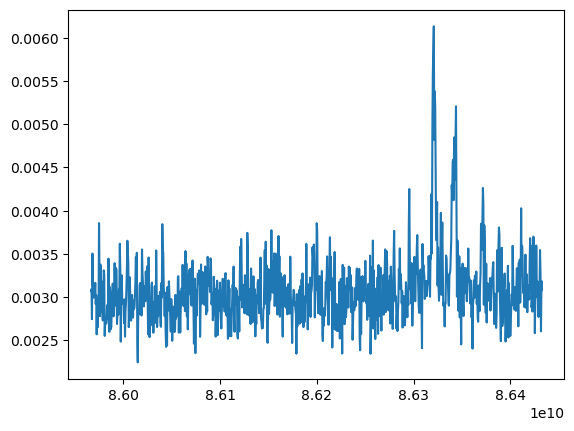

In [79]:
pl.plot(background_stddevs[0].spectral_axis, background_stddevs[0].value)

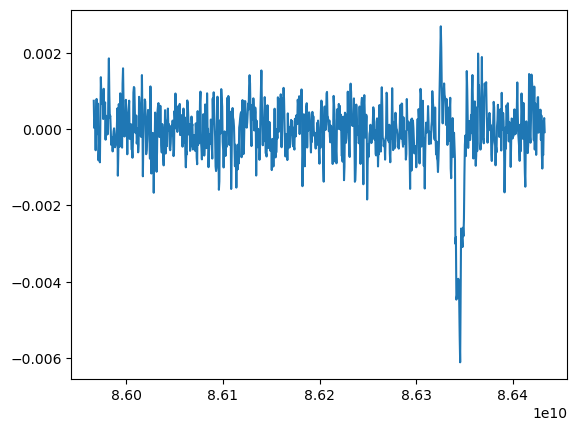

In [80]:
pl.plot(background_means[0].spectral_axis, background_means[0].value)

## Fitting channel-by-channel

In [81]:
coord.galactic

<SkyCoord (Galactic): (l, b) in deg
    (0.0246741, -0.0727428)>

In [82]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

In [83]:
rows = []
for chan in range(so_scube.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value)
    rows.append(g.parameters)
    #print(chan, g.parameters)
tb = Table(np.array(rows), names=g.param_names)

In [612]:
# try again averaging 10 channels
# I did this twice (oops): ### Try again downsampled (higher S/N)
rows = []
for chan in range(0, so_scube.shape[0], 10):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    data = so_scube[chan:chan+10, :, :].moment0(axis=0).value
    g = fit_g(g_init, x, y, z=data)
    rows.append(np.array([so_scube.spectral_axis[chan:chan+10].mean().value] + list(g.parameters)))
    #print(chan, g.parameters)
tb_avg = Table(np.array(rows), names=['Velocity'] + list(g.param_names))

In [84]:
%matplotlib inline
import pylab as pl

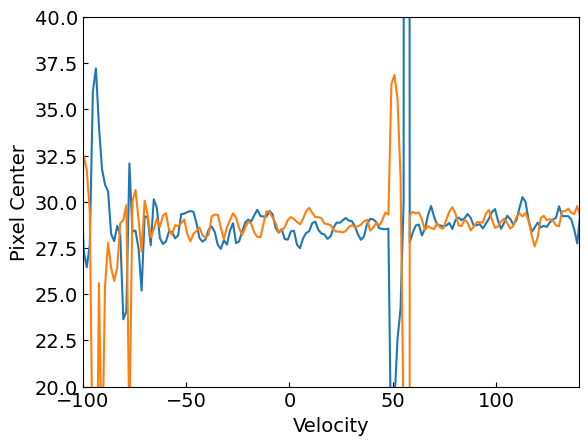

In [577]:
pl.plot(so_scube.spectral_axis.value, tb['x_mean'], label='X center (pixels)')
pl.plot(so_scube.spectral_axis.value, tb['y_mean'], label='Y center (pixels)')
pl.ylim(20, 40);
pl.xlim(-100, 140);
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

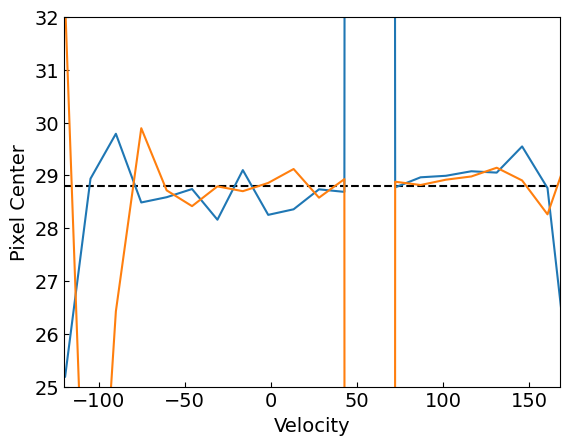

In [618]:
pl.plot(tb_avg['Velocity'], tb_avg['x_mean'], label='X center (pixels)')
pl.plot(tb_avg['Velocity'], tb_avg['y_mean'], label='Y center (pixels)')
pl.ylim(25, 32);
pl.xlim(-120, 168);
pl.axhline(28.8, linestyle='--', color='k', zorder=-10)
pl.xlabel("Velocity");
pl.ylabel("Pixel Center");

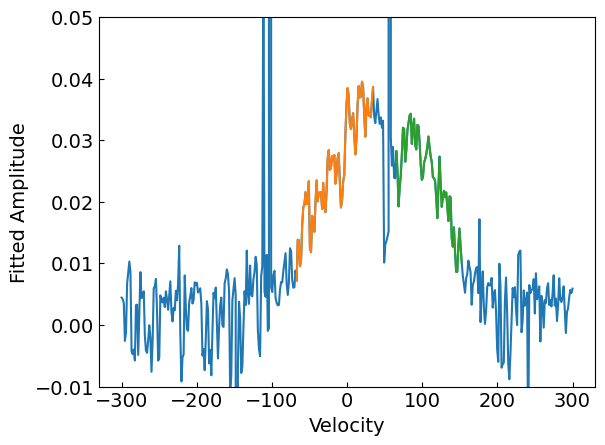

In [582]:
pl.plot(so_scube.spectral_axis.value, tb['amplitude'])
pl.plot(so_scube.spectral_axis.value[180:250], tb['amplitude'][180:250])
pl.plot(so_scube.spectral_axis.value[100:160], tb['amplitude'][100:160])
pl.ylim([-0.01, 0.05]);
pl.ylabel("Fitted Amplitude")
pl.xlabel("Velocity");

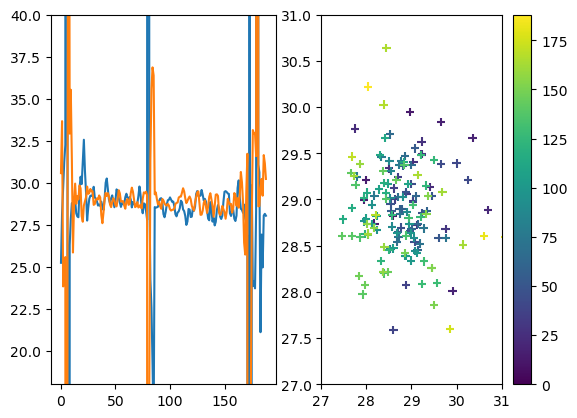

In [87]:
sel = tb['amplitude'] > 0.008
pl.subplot(1,2,1)
pl.plot(tb['x_mean'][sel])
pl.plot(tb['y_mean'][sel])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb['x_mean'][sel], tb['y_mean'][sel], c=np.arange(len(tb[sel])), marker='+')
pl.colorbar()
pl.axis([27,31,27,31]);

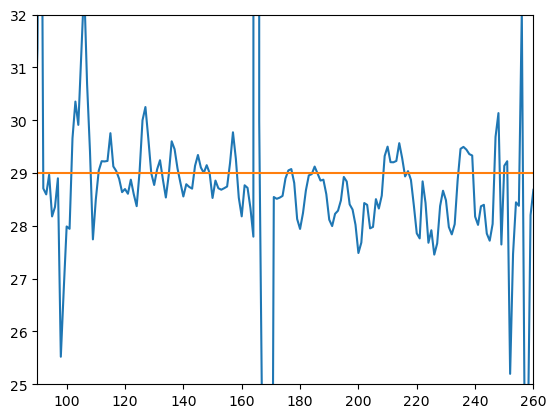

In [88]:
pl.plot(tb['x_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

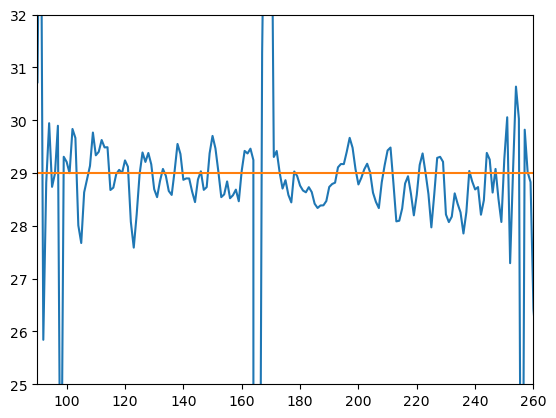

In [89]:
pl.plot(tb['y_mean'])
pl.plot([0,400], [29, 29])
pl.ylim(25, 32);
pl.xlim(90,260);

In [90]:
pixscale = so_scube.wcs.celestial.proj_plane_pixel_scales()[0].to(u.arcsec)
pixscale

<Quantity 0.26 arcsec>

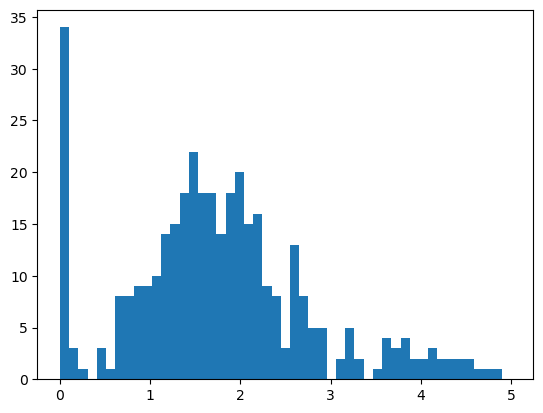

In [91]:
pl.hist(tb['x_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

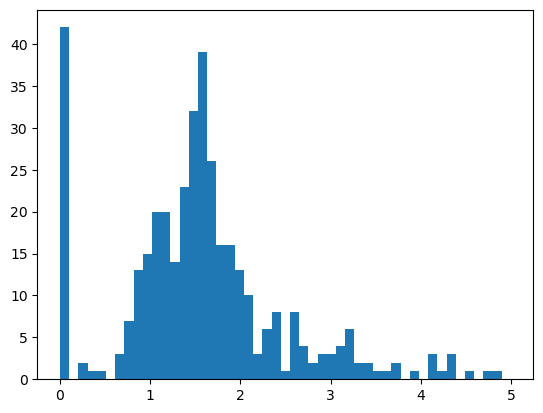

In [92]:
pl.hist(tb['y_stddev']*pixscale.value*2.35, bins=np.linspace(0,5));

### Fit red and blue sides

(<Quantity 0.00092057 deg>,
 <Quantity 0.00082902 deg>,
 <Gaussian2D(amplitude=0.02563195, x_mean=28.54175745, y_mean=28.78748886, x_stddev=2.87801657, y_stddev=2.5918191, theta=0.17038562)>,
 <Quantity 34.59907725 km / s>,
 <Quantity -68.59815164 km / s>,
 <Quantity -7.67024943 km / s>)

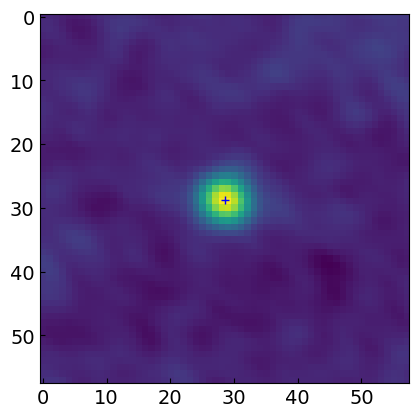

In [657]:
avgim_blue = so_scube[180:250].mean(axis=0)
avgim_blue.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
blue_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
blue_gfit = g = blue_fit_g(g_init, x, y, z=avgim_blue.value, weights=1/stats.mad_std(avgim_blue.value))
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[180], so_scube.spectral_axis[250],
 so_scube[180:250].moment1(axis=0)[int(blue_gfit.y_mean.value), int(blue_gfit.x_mean.value)])

(<Quantity 0.00098212 deg>,
 <Quantity 0.00084372 deg>,
 <Gaussian2D(amplitude=0.0235422, x_mean=29.00403352, y_mean=28.92198709, x_stddev=3.07045852, y_stddev=2.63776472, theta=0.47884723)>,
 <Quantity 152.5387674 km / s>,
 <Quantity 64.08399979 km / s>,
 <Quantity 103.77683546 km / s>)

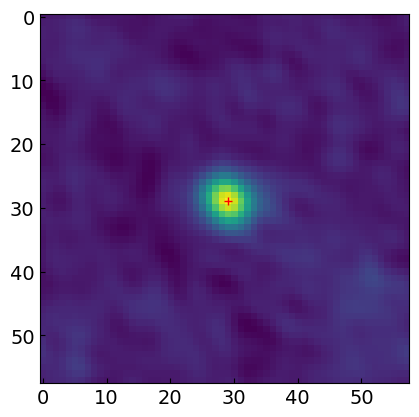

In [658]:
avgim_red = so_scube[100:160].mean(axis=0)
avgim_red.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
red_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
red_gfit = g = red_fit_g(g_init, x, y, z=avgim_red.value, weights=1/stats.mad_std(avgim_red.value))
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 so_scube.spectral_axis[100], so_scube.spectral_axis[160],
 so_scube[100:160].moment1(axis=0)[int(red_gfit.y_mean.value), int(red_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


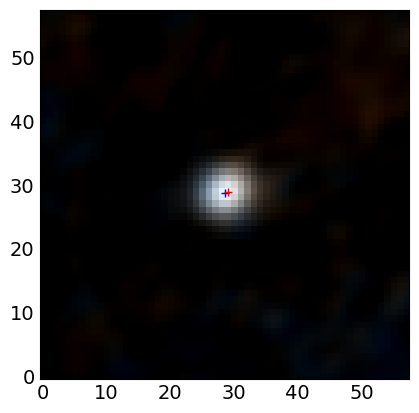

In [651]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [653]:
redbluesep = ((blue_gfit.x_mean - red_gfit.x_mean)**2 + (blue_gfit.y_mean - red_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(red_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(blue_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redbluesep, uncertainty, redbluesep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redbluesep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.48144464227550166,
 0.057005103356524166,
 <Quantity 0.23590787 arcsec>,
 <Quantity 0.0279325 arcsec>,
 <Quantity 2005.21693508 AU>,
 <Quantity 237.42625548 AU>)

In [621]:
# for estimating contour levels
avgim_blue.max()

<Projection 0.0252627 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


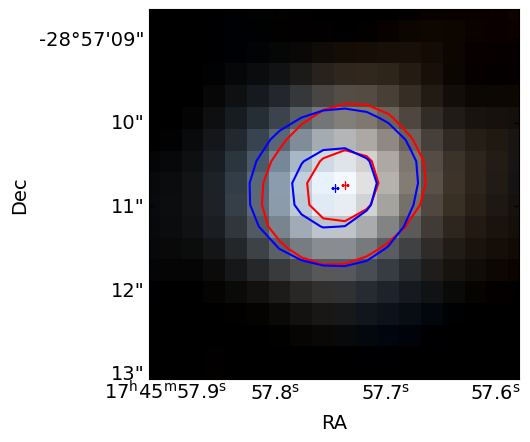

In [631]:
rgbim = np.array([avgim_red, (avgim_red+avgim_blue)/2., avgim_blue]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')
pl.contour(avgim_red, colors=['r', 'r'], levels=[0.01,0.02])
pl.contour(avgim_blue, colors=['b', 'b'], levels=[0.01,0.02])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SOmoment_red_and_blue.pdf', bbox_inches='tight')

In [94]:
coord_fit = so_scube.wcs.celestial.pixel_to_world(g.x_mean, g.y_mean)
coord_fit, coord_fit.to_string('hmsdms'), coord_fit.galactic

(<SkyCoord (ICRS): (ra, dec) in deg
     (266.49060723, -28.95299327)>,
 '17h45m57.74573513s -28d57m10.77577293s',
 <SkyCoord (Galactic): (l, b) in deg
     (0.02465872, -0.07272093)>)

In [95]:
import radio_beam
# wouldn't deconvolve with theta as set; rotated 90 deg (probably not right?)
src = radio_beam.Beam(major=g.x_stddev*pixscale*2.35, minor=g.y_stddev*pixscale*2.35, pa=90*u.deg+g.theta*u.rad)
src, so_scube.beam, src.deconvolve(so_scube.beam)

(Beam: BMAJ=1.7584681250090228 arcsec BMIN=1.5836014702261407 arcsec BPA=99.76237710482135 deg,
 Beam: BMAJ=1.6255785371840412 arcsec BMIN=1.4396964064791222 arcsec BPA=-52.087786316534505 deg,
 Beam: BMAJ=0.8454143787624522 arcsec BMIN=0.4123675156659957 arcsec BPA=69.51613180241908 deg)

### Source fit leads to 1.5" size scale (so, beam-sized) - but it can deconvolve to ~0.8"

### Try again downsampled (higher S/N)

In [96]:
so_scube_ds = so_scube.downsample_axis(factor=10, axis=0)
so_scube_ds

In some cases, the final shape of the output from downsample_axis is incorrect, so use the result with caution


DaskSpectralCube with shape=(41, 58, 58) and unit=Jy / beam and chunk size (6, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:     41  type_s: VRAD      unit_s: km / s  range:     -296.369 km / s:     293.329 km / s

In [97]:
rows = []
for chan in range(so_scube_ds.shape[0]):
    g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
    fit_g = LevMarLSQFitter()
    y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
    g = fit_g(g_init, x, y, z=so_scube[chan, :, :].value)
    rows.append(g.parameters)
    #print(chan, g.parameters)
tb2 = Table(np.array(rows), names=g.param_names)
tb2

<Table length=41>
      amplitude               x_mean             y_mean              x_stddev               y_stddev                theta        
       float64               float64            float64              float64                float64                float64       
---------------------- ------------------- ------------------ ---------------------- ---------------------- ---------------------
  0.005905585860934528  26.328576906592797  34.62835040278195      2.223591493629204      6.143321726898192    1.4044253533118467
 0.0051844463456161205  31.643804508650515    32.155286780698      8.430427514228322      1.617510322407969  -0.19444014117558736
  0.005680080658306295   32.37743393773512  30.79586320983435      6.201328799229736     1.8372987093384185   0.01925491221517151
  0.004466647678453937   34.49168760886746  28.42773038878257      6.863433086440286     1.6633525742944029  -0.41298774500885754
 0.0026836125945029453  29.199514876698476  28.43392904383554     2.8346325397063814 1.1754943508222875e-38   -0.4846850113170254
 0.0021286195737177833  29.669661772152843 24.388187229793648     1.4153751884510877 1.1754943508222875e-38  -0.02069692356870769
-0.0013055802129225426  28.703801048226392 22.764780298104306      3.589776841664849 1.1754943508222875e-38 -0.009950217987713233
 0.0026761589337948545  23.191125618972922  30.54714951389411      6.259404232251199     1.4011830145973465   -0.1263525824965948
  0.006269812709827055   34.92395995124469 31.176221997470012      4.516466183308611      1.454413298532732   0.36178613243530244
   0.00446663232596735  31.776964869340368 30.850275629310946      6.633910900739754     1.6234459495358393    0.3838294754061799
  0.003735955729704185   27.35826432237159 29.844063142584115     1.2848312811309393     5.2956768654416795   -0.2379412076489553
  0.004128527856246432   18.89215058055164 29.622760256198077     2.1006875931499356     11.318395126086976    0.6961496035914125
  0.007579184342278224   27.51206162405581 32.613056765503195     1.3721519152160537     2.1439445666992154   -0.4019426699660643
 0.0031965468032606106  23.820007300137455 31.605411503750762 1.1754943508222875e-38      4.314475540950832   0.09427401820178666
 0.0006409542649776381  24.635853929045705  32.44960221177228 1.1754943508222875e-38     3.4632608288462254   0.03723338271292305
  0.004278464820375466   32.47007426695607  40.90412618085624     1.1581118028780437     4.4321615014471885  -0.04622175945049441
 0.0031468601888679803 -0.5540808105409533  34.12995487106651     30.471236744759466     2.2864986827170632    -0.188813801209722
  0.008062391122324142  25.231781251967206  30.57037409392884      5.102362822845134      2.178690819355693   -0.5996627990977578
  0.005076154068264229  28.440202127237118 28.891884695447107      6.148187898138492     1.5444711974752259  -0.44839169040700494
  0.003006741865905987  29.547442983426546 29.807440230526684      8.367954544117286     2.5462719678086363    0.7528665638327763
  0.004079857321210367  32.742931129637476   32.9575915924136      5.264578227424151      4.870570429618939    0.9126090987051717
 0.0032369837301215866  30.680420675019356  32.68898813804893     4.0359431702901025      6.969983507979104    -2.070784218897746
  0.006790320774579394  27.499675812933447 28.488219955654262     2.3964661820339237     1.6608710985495216    0.6655718587152509
  0.005963858486119376  15.287438909851542  30.01627311422624      5.908952672160044     1.6390082674190132   -1.5640428346960233
 0.0035738434105597443  29.635976948643204 31.744457792637085     0.9985000976185494 1.1754943508222875e-38  -0.22537248528116038
  0.004043105096425644  30.810118846355774  30.48640179596179     2.8691684999006712 1.1754943508222875e-38  -0.20299460683205836
-0.0004375590761624606  30.169761049978298 27.446923845627914     0.2841781519306492 1.1754943508222875e-38 -0.012142703351433519
 0.0035258088932398957   25.56050866372555 25.551153147321422 1.1754943508222875e-

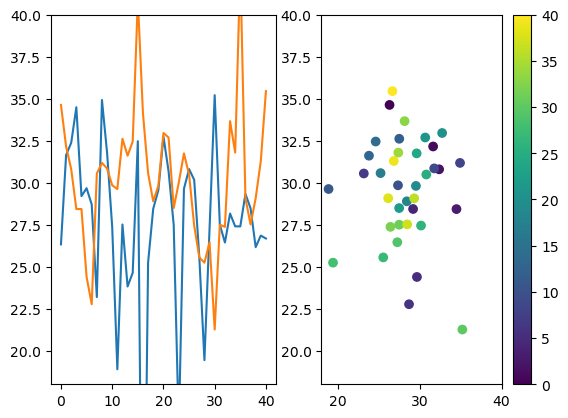

In [98]:
pl.subplot(1,2,1)
pl.plot(tb2['x_mean'])
pl.plot(tb2['y_mean'])
pl.ylim(18, 40);
pl.subplot(1,2,2)
pl.scatter(tb2['x_mean'], tb2['y_mean'], c=np.arange(len(tb2)))
pl.colorbar()
pl.axis([18,40,18,40]);

## Repeat fits for CS - see if consistent

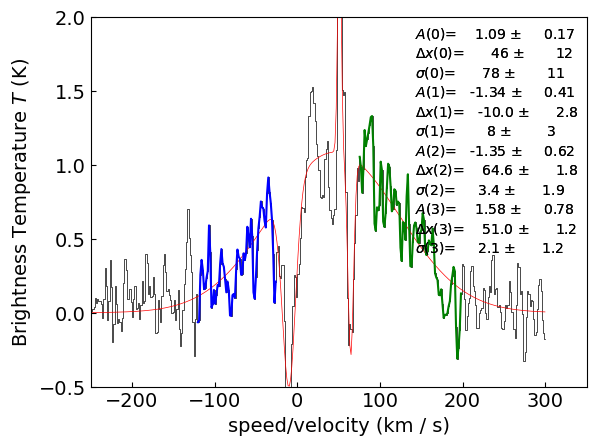

In [675]:
xx, yy = cs_scube.wcs.celestial.world_to_pixel(coord)
csspec = pyspeckit.Spectrum.from_hdu(cs_scube[:, int(yy), int(xx)].to(u.K).hdu)
csspec.xarr.convert_to_unit(u.GHz)
csspec.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
csspec.plotter(xmin=-250, xmax=350)
csspec.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])
red = csspec.slice(75, 200, unit=u.km/u.s)
pl.plot(red.xarr.value, red.data, color='g')
blue = csspec.slice(-120, -25, unit=u.km/u.s)
pl.plot(blue.xarr.value, blue.data, color='b')
pl.ylim(-0.5,2);

In [683]:
g_init.x_stddev.bounds

(1.1754943508222875e-38, None)

(<Quantity 0.00094781 deg>,
 <Quantity 0.00110002 deg>,
 <Gaussian2D(amplitude=0.00628209, x_mean=27.67804703, y_mean=28.645654, x_stddev=2.96319359, y_stddev=3.43906871, theta=5.89771595)>,
 <Quantity -60.72401402 km / s>)

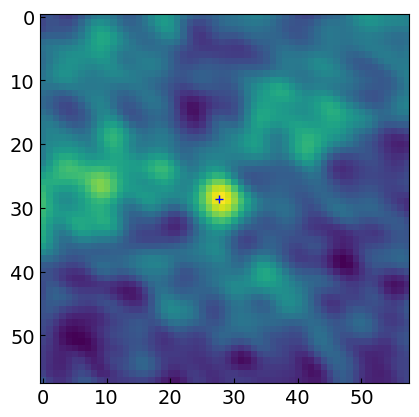

In [690]:
blue_cs_scube = cs_scube.spectral_slab(-120*u.km/u.s, -25*u.km/u.s)
avgim_bluecs = blue_cs_scube.mean(axis=0)
avgim_bluecs.quicklook()
g_init = Gaussian2D(amplitude=0.02, x_mean=29.1, y_mean=29.1, x_stddev=3., y_stddev=3)
g_init.x_mean.bounds = (27, 31)
g_init.y_mean.bounds = (27, 31)
bluecs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs_scube.shape[1], :cs_scube.shape[2]]
fitdata = avgim_bluecs.value

# crop out background
weights = np.ones_like(fitdata) * 1/stats.mad_std(avgim_bluecs.value)
weights[:,:24] = 0
weights[:23,:] = 0
weights[35:,:] = 0
weights[:,34:] = 0

bluecs_gfit = g = bluecs_fit_g(g_init, x, y, z=fitdata, weights=weights)
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 blue_cs_scube.moment1(axis=0)[int(bluecs_gfit.y_mean.value), int(bluecs_gfit.x_mean.value)])

(<Quantity 0.00115019 deg>,
 <Quantity 0.00093904 deg>,
 <Gaussian2D(amplitude=0.00976611, x_mean=28.57189919, y_mean=28.94914199, x_stddev=3.59589602, y_stddev=2.93576982, theta=-0.23338994)>,
 <Quantity 115.73128373 km / s>)

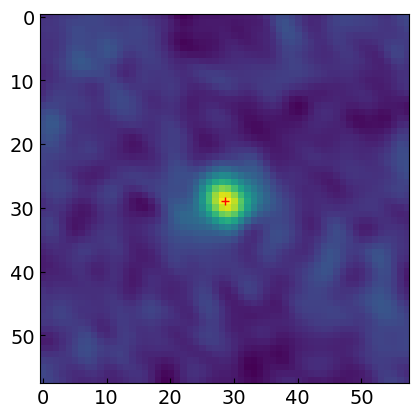

In [693]:
red_cs_scube = cs_scube.spectral_slab(75*u.km/u.s, 200*u.km/u.s)
avgim_redcs = red_cs_scube.mean(axis=0)
avgim_redcs.quicklook()
g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
redcs_fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs_scube.shape[1], :cs_scube.shape[2]]
redcs_gfit = g = redcs_fit_g(g_init, x, y, z=avgim_redcs.value, weights=1/stats.mad_std(avgim_redcs.value))
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
(g.x_stddev * pixscale * 2.35, g.y_stddev * pixscale * 2.35, g,
 red_cs_scube.moment1(axis=0)[int(redcs_gfit.y_mean.value), int(redcs_gfit.x_mean.value)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


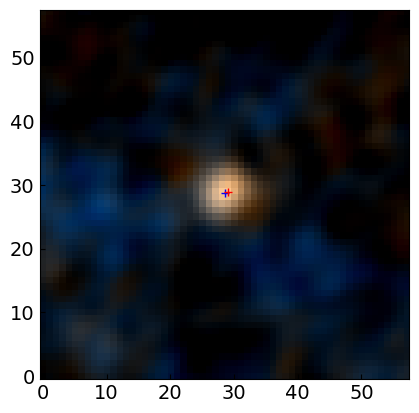

In [695]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(blue_gfit.x_mean, blue_gfit.y_mean, 'b+')
pl.plot(red_gfit.x_mean, red_gfit.y_mean, 'r+')

In [696]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.4625446 arcsec>,
 <Quantity 0.12307491 arcsec>,
 <Quantity 3931.6290655 AU>,
 <Quantity 1046.13672096 AU>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


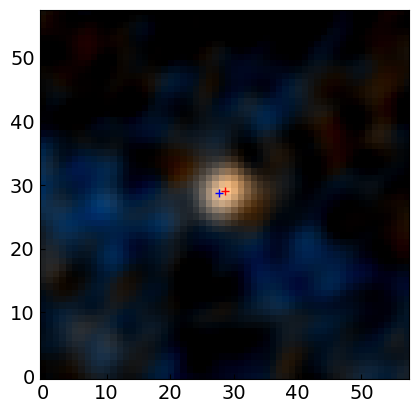

In [697]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')

In [698]:
redcsbluecssep = ((bluecs_gfit.x_mean - redcs_gfit.x_mean)**2 + (bluecs_gfit.y_mean - redcs_gfit.y_mean)**2)**0.5
uncertainty = (np.sum(redcs_fit_g.fit_info['param_cov'].diagonal()[1:3]) + np.sum(bluecs_fit_g.fit_info['param_cov'].diagonal()[1:3]))**0.5
redcsbluecssep, uncertainty, redcsbluecssep * pixscale.to(u.arcsec), uncertainty * pixscale.to(u.arcsec), redcsbluecssep * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec, uncertainty * pixscale.to(u.arcsec) * 8500*u.au/u.arcsec

(0.9439685631447268,
 0.25117328234270475,
 <Quantity 0.4625446 arcsec>,
 <Quantity 0.12307491 arcsec>,
 <Quantity 3931.6290655 AU>,
 <Quantity 1046.13672096 AU>)

In [699]:
# for estimating contour levels
avgim_bluecs.max()

<Projection 0.00630689 Jy / beam>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


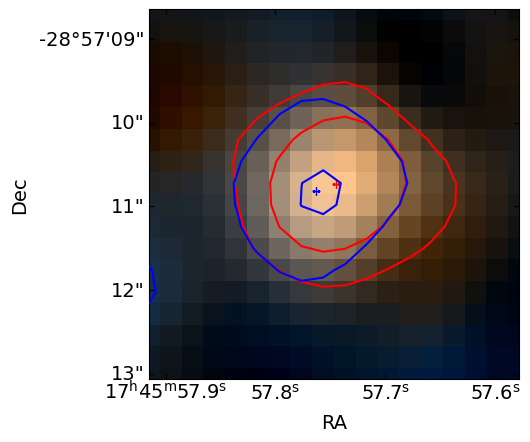

In [700]:
rgbim = np.array([avgim_redcs, (avgim_redcs+avgim_bluecs)/2., avgim_bluecs]).T.swapaxes(0,1)
rgbim /= rgbim.max()
ax = pl.subplot(projection=so_scube.wcs.celestial)
pl.imshow(rgbim, origin='lower');
pl.plot(bluecs_gfit.x_mean, bluecs_gfit.y_mean, 'b+')
pl.plot(redcs_gfit.x_mean, redcs_gfit.y_mean, 'r+')
pl.contour(avgim_redcs, colors=['r', 'r'], levels=[0.003,0.006])
pl.contour(avgim_bluecs, colors=['b', 'b'], levels=[0.003,0.006])
pl.axis([20,37,20,37]);
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSmoment_redcs_and_bluecs.pdf', bbox_inches='tight')

# Fit positions of moment maps

In [284]:
sig2fwhm = np.sqrt(8*np.log(2))

In [285]:
centroid_measurements = []

## SO first

In [286]:
so_scube = scubes[-2].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=99.29987*u.GHz).spectral_slab(-300*u.km/u.s, 300*u.km/u.s)
so_scube

DaskSpectralCube with shape=(408, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    408  type_s: VRAD      unit_s: km / s  range:     -300.055 km / s:     299.963 km / s

### Moment images

In [287]:
background_stddev_so = so_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_so = so_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_so_spec = so_scube.subcube_from_regions([circle]).mean(axis=(1,2))

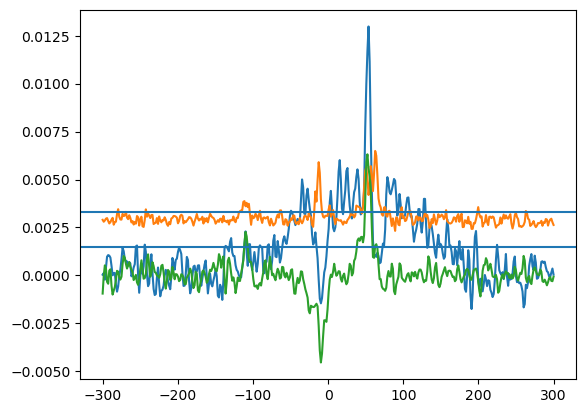

In [288]:
pl.plot(mean_so_spec.spectral_axis, mean_so_spec.value)
pl.plot(mean_so_spec.spectral_axis, background_stddev_so.value)
pl.plot(mean_so_spec.spectral_axis, background_mean_so.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean           x_stddev           y_stddev            theta       
    ------------------ ------------------ ----------------- ------------------ ------------------ ------------------
    148.32008973612423 28.675184605802404 28.82932587561258 2.5294143922434666 2.9667869508805436 2.0085460104975636


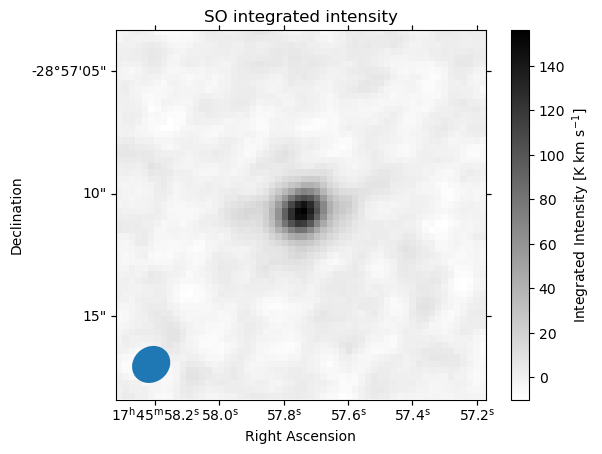

In [289]:
contest = so_scube.median(axis=0)
m0 = ((so_scube-contest).with_mask((background_stddev_so < 0.0033*background_stddev_so.unit)[:,None,None])
              .with_mask((mean_so_spec > 0.0015*mean_so_spec.unit)[:,None,None])).to(u.K).moment0()
m0_so_ptsrc = m0

jtok = m0.beam.jtok(so_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:so_scube.shape[1], :so_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['SO 3(2)-2(1)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ])
except radio_beam.utils.BeamError:
    centroid_measurements.append(['SO 3(2)-2(1)', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.deg
                                 ])

m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_m0.fits', overwrite=True)

#### SO fullcloud background

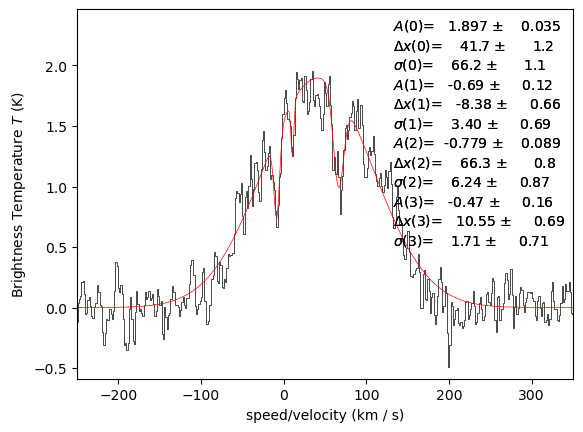

In [290]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_so32)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, -0.3, 10, 5])

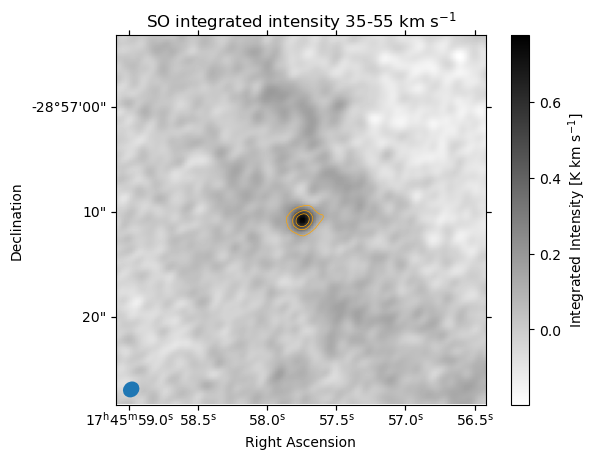

In [291]:
m0_bigcloud_3555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(35*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_3555_so.wcs)
im = ax.imshow(m0_bigcloud_3555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 35-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_35to55kms_with_comsrc.pdf', bbox_inches='tight')

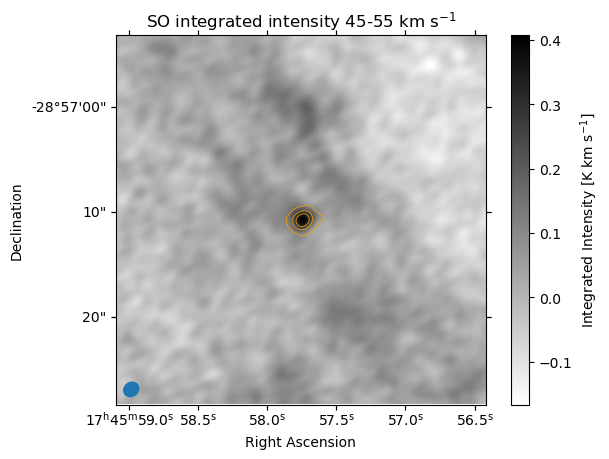

In [292]:
m0_bigcloud_4555_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555_so.wcs)
im = ax.imshow(m0_bigcloud_4555_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

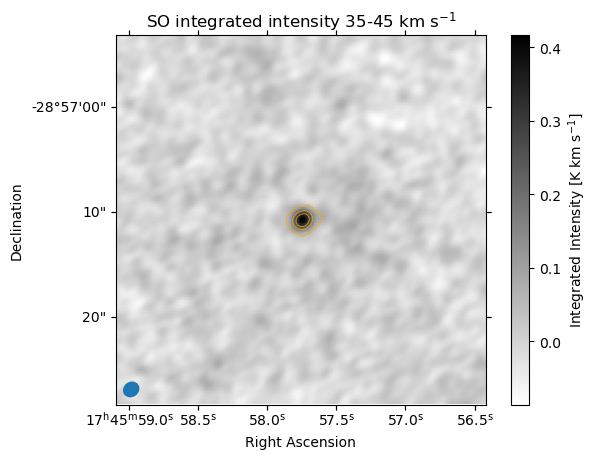

In [293]:
m0_bigcloud_3445_so = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_so32)
                    .spectral_slab(35*u.km/u.s, 45*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_3445_so.wcs)
im = ax.imshow(m0_bigcloud_3445_so.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("SO integrated intensity 35-45 km s$^{-1}$")

ax.contour(m0_so_ptsrc.value, levels=[20,60,100], colors=['orange']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_so_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/SO32_big_m0_35to45kms_with_comsrc.pdf', bbox_inches='tight')

#### H13COP

Not a clear detection

In [294]:
scubes[1], nurest_h13cop

(DaskSpectralCube with shape=(956, 58, 58) and unit=Jy / beam and chunk size (22, 58, 58):
  n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
  n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
  n_s:    956  type_s: FREQ      unit_s: Hz     range: 86666488077.200 Hz:87132826992.200 Hz,
 <Quantity 86.7543 GHz>)

In [295]:
h13cop_scube = scubes[1].with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop = scubes[1].median(axis=0)

background_stddev_h13cop = h13cop_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop = h13cop_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop_spec = h13cop_scube.subcube_from_regions([circle]).mean(axis=(1,2))

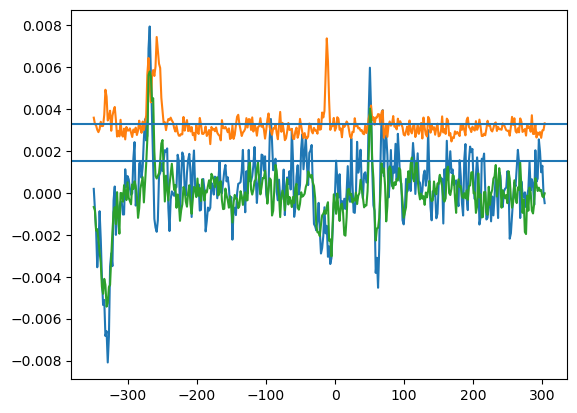

In [296]:
pl.plot(mean_h13cop_spec.spectral_axis, mean_h13cop_spec.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_stddev_h13cop.value)
pl.plot(mean_h13cop_spec.spectral_axis, background_mean_h13cop.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude           x_mean             y_mean            x_stddev          y_stddev           theta       
    ----------------- ------------------ ------------------ ----------------- ----------------- ------------------
    12.23002159398392 27.609989523601126 29.847964504491703 7.206119014930517 8.129650590986492 0.9895282199076768


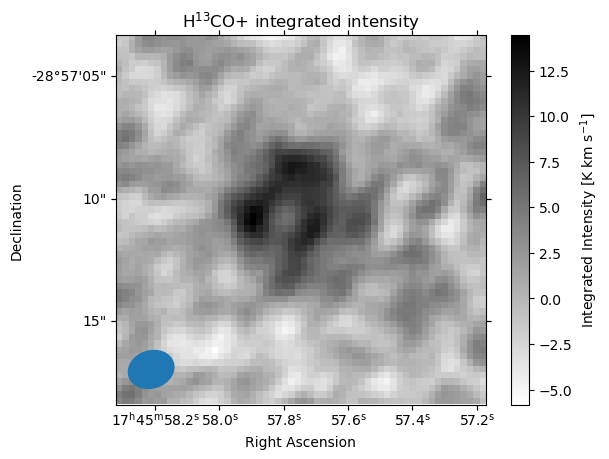

In [297]:
m0 = ((h13cop_scube-contest_h13cop)
      .with_mask((background_stddev_h13cop < 0.0033*background_stddev_h13cop.unit)[:,None,None])
      .with_mask((mean_h13cop_spec > 0.0015*mean_h13cop_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop_scube.shape[1], :h13cop_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
#try:
#    deconv_size = src.deconvolve(m0.beam)
#    
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  deconv_size.major, deconv_size.minor, deconv_size.pa
#                                 ])
#except radio_beam.utils.BeamError:
#    centroid_measurements.append(['H13CO+', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                 ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_m0.fits', overwrite=True)

#### H13COP: Tsuboi's data

In [299]:
scubes2012[0].mask_out_bad_beams(threshold=0.1).beams.common_beam()

Beam: BMAJ=2.763217977139522 arcsec BMIN=1.738262140160674 arcsec BPA=91.57866598900102 deg

In [300]:
sc = [c for c in scubes2012 if nurest_h13cop < c.spectral_axis.max() and nurest_h13cop > c.spectral_axis.min()][0]
sc = sc.mask_out_bad_beams(threshold=0.1)
h13cop2012_scube = sc.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_h13cop).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_h13cop2012 = sc.median(axis=0)

background_stddev_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_h13cop2012 = h13cop2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_h13cop2012_spec = h13cop2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


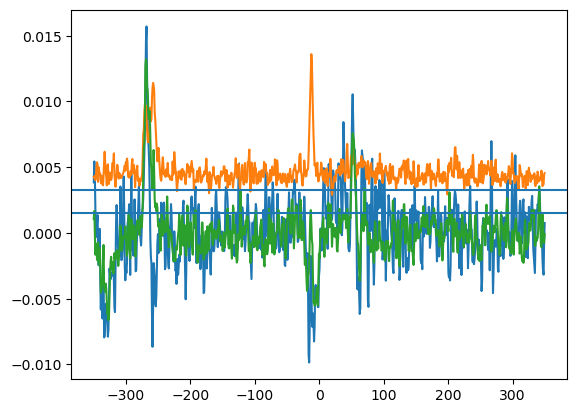

In [301]:
pl.plot(mean_h13cop2012_spec.spectral_axis, mean_h13cop2012_spec.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_stddev_h13cop2012.value)
pl.plot(mean_h13cop2012_spec.spectral_axis, background_mean_h13cop2012.value)
pl.axhline(0.0033)
pl.axhline(0.0015)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude            x_mean             y_mean            x_stddev          y_stddev             theta       
    ------------------- ------------------ ------------------ ----------------- ------------------ -------------------
    0.36419285250456024 30.134332798921932 24.546232580170038 3.435195127930547 12.184678210133958 -0.5077098837579497


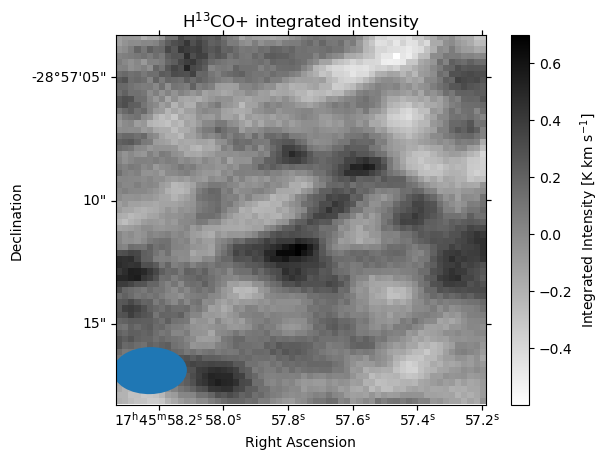

In [302]:
m0 = ((h13cop2012_scube-contest_h13cop2012)
      .with_mask((background_stddev_h13cop2012 < 0.0033*background_stddev_h13cop2012.unit)[:,None,None])
      .with_mask((mean_h13cop2012_spec > 0.0015*mean_h13cop2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(h13cop2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("H$^{13}$CO+ integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:h13cop2012_scube.shape[1], :h13cop2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/H13COP10_2012_m0.fits', overwrite=True)

## Now CS moments

In [303]:
cs_scube = (scubes[-2]
            .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
            .spectral_slab(-300*u.km/u.s, 300*u.km/u.s))
cs_scube

DaskSpectralCube with shape=(402, 58, 58) and unit=Jy / beam and chunk size (60, 33, 58):
 n_x:     58  type_x: RA---SIN  unit_x: deg    range:   266.488258 deg:  266.492963 deg
 n_y:     58  type_y: DEC--SIN  unit_y: deg    range:   -28.955072 deg:  -28.950956 deg
 n_s:    402  type_s: VRAD      unit_s: km / s  range:     -299.573 km / s:     299.557 km / s

In [304]:
background_stddev_cs = cs_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs = cs_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs_spec = cs_scube.subcube_from_regions([circle]).mean(axis=(1,2))

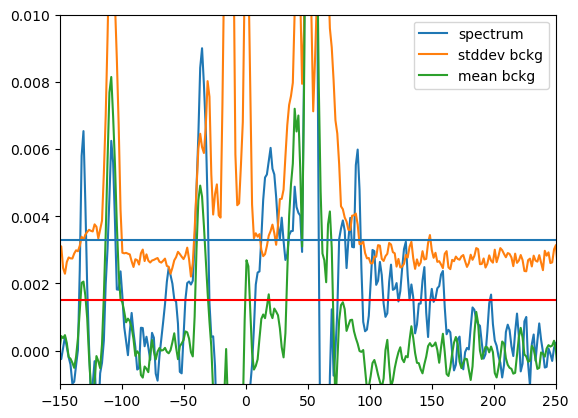

In [305]:
pl.plot(mean_cs_spec.spectral_axis, mean_cs_spec.value, label='spectrum')
pl.plot(mean_cs_spec.spectral_axis, background_stddev_cs.value, label='stddev bckg')
pl.plot(mean_cs_spec.spectral_axis, background_mean_cs.value, label='mean bckg')
pl.axhline(0.0033)
pl.axhline(0.0015, color='r')
pl.ylim(-0.001, 0.01)
pl.xlim(-150, 250)
pl.legend(loc='best');

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev         y_stddev            theta        
    ------------------ ------------------ ------------------ ----------------- ---------------- --------------------
    55.650578910083006 28.247627874657322 28.788487892112837 4.172805827895565 3.14902909536739 -0.06905730437108455


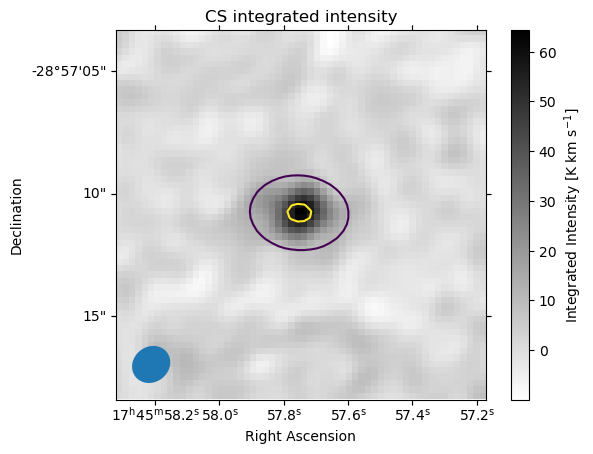

In [306]:
m0 = (cs_scube.with_mask((background_stddev_cs < 0.0033*background_stddev_cs.unit)[:,None,None])
              .with_mask((mean_cs_spec > 0.0010*mean_cs_spec.unit)[:,None,None])
              .spectral_slab(-150*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()
m0_cs_ptsrc = m0
jtok = m0.beam.jtok(cs_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.pdf', bbox_inches='tight')


g_init = Gaussian2D(amplitude=11, x_mean=m0.shape[1]/2., y_mean=m0.shape[0]/2., x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs_scube.shape[1], :cs_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
deconv_size = src.deconvolve(m0.beam)

centroid_measurements.append(['CS 2-1', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0.fits', overwrite=True)

ax.contour(g(x,y), levels=[10, 50])

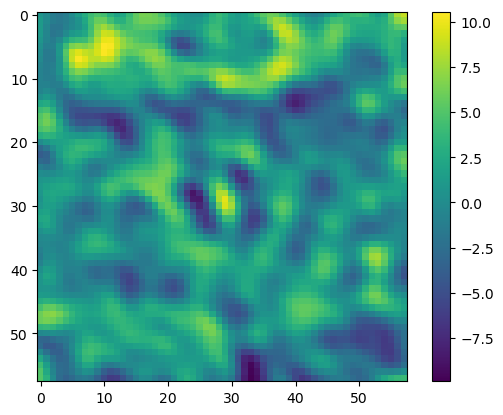

In [307]:
pl.imshow(m0.value - g(x,y))
pl.colorbar();

In [308]:
nurest_cs21

<Quantity 9.798095e+10 Hz>

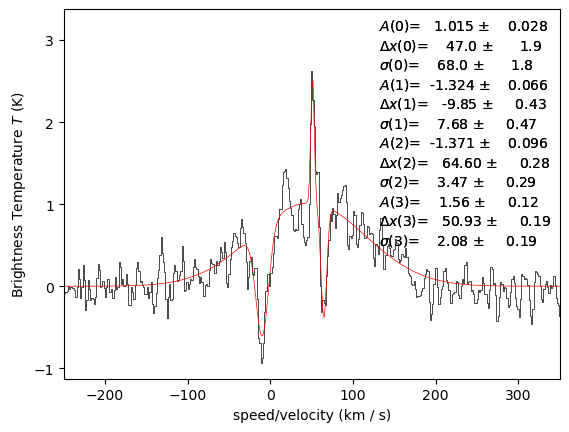

In [309]:
spw33.xarr.convert_to_unit(u.GHz)
spw33.xarr.convert_to_unit(u.km/u.s, velocity_convention='radio', refX=nurest_cs21)
spw33.plotter(xmin=-250, xmax=350)
spw33.specfit(guesses=[1, 50, 70, -1, -10, 8, -1, 65, 4, 1, 55, 4])

### CS cloud overlay

In [310]:
m0_cloud_4060 = cs_scube.spectral_slab(40*u.km/u.s, 60*u.km/u.s).moment0()
m0_cloud_4555 = cs_scube.spectral_slab(45*u.km/u.s, 55*u.km/u.s).moment0()

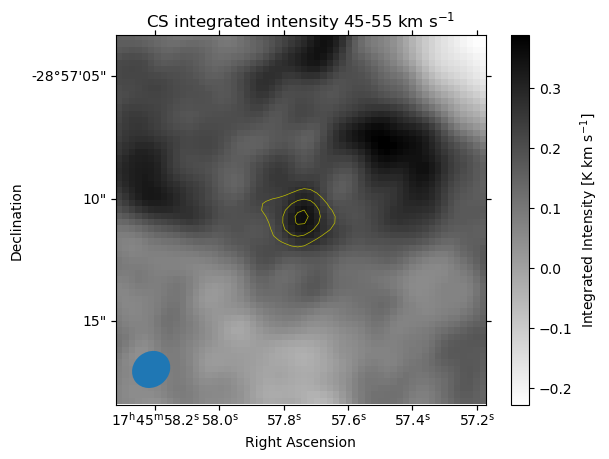

In [311]:

fig = pl.figure()
ax = pl.subplot(projection=m0_cloud_4555.wcs)
im = ax.imshow(m0_cloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")
ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

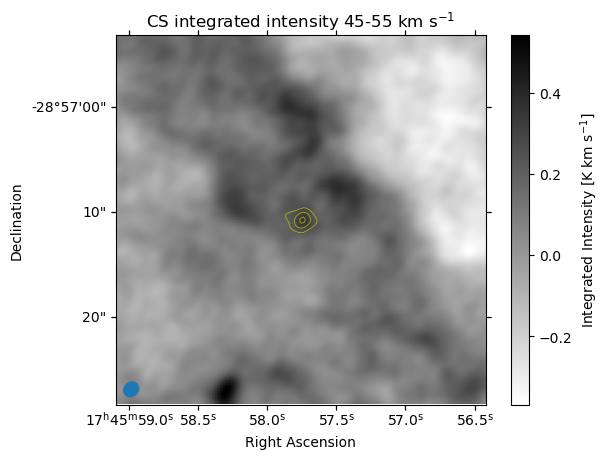

In [312]:
m0_bigcloud_4555 = (cubes[-2]
                    .subcube_from_regions([bigregion])
                    .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
                    .spectral_slab(45*u.km/u.s, 55*u.km/u.s)
                   ).moment0()

fig = pl.figure()
ax = pl.subplot(projection=m0_bigcloud_4555.wcs)
im = ax.imshow(m0_bigcloud_4555.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity 45-55 km s$^{-1}$")

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], colors=['y']*3, linewidths=[0.5]*3, transform=ax.get_transform(m0_cs_ptsrc.wcs));
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CS21_big_m0_45to55kms_with_comsrc.pdf', bbox_inches='tight')

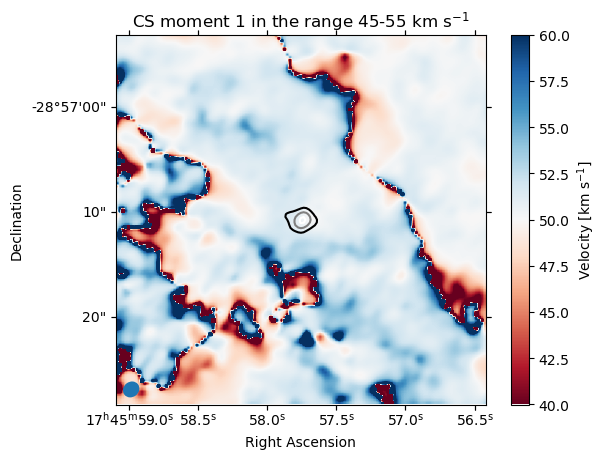

In [313]:
m1_bigcloud_4060 = (cubes[-2]
.subcube_from_regions([bigregion])
.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21)
.spectral_slab(45*u.km/u.s, 55*u.km/u.s)
).moment1()
fig = pl.figure()
ax = pl.subplot(projection=m1_bigcloud_4060.wcs)
im = ax.imshow(m1_bigcloud_4060.value, cmap='RdBu', vmin=40, vmax=60)
cb = pl.colorbar(mappable=im)
cb.set_label("Velocity [km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS moment 1 in the range 45-55 km s$^{-1}$");

ax.contour(m0_cs_ptsrc.value, levels=[20,40,60], cmap='gray', transform=ax.get_transform(m0_cs_ptsrc.wcs));

### TP Spectra

In [811]:
tpcubefns = sorted(glob.glob('/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X140/product/*.cube.I.sd.fits'))
tpcubes = [SpectralCube.read(fn) for fn in tpcubefns]

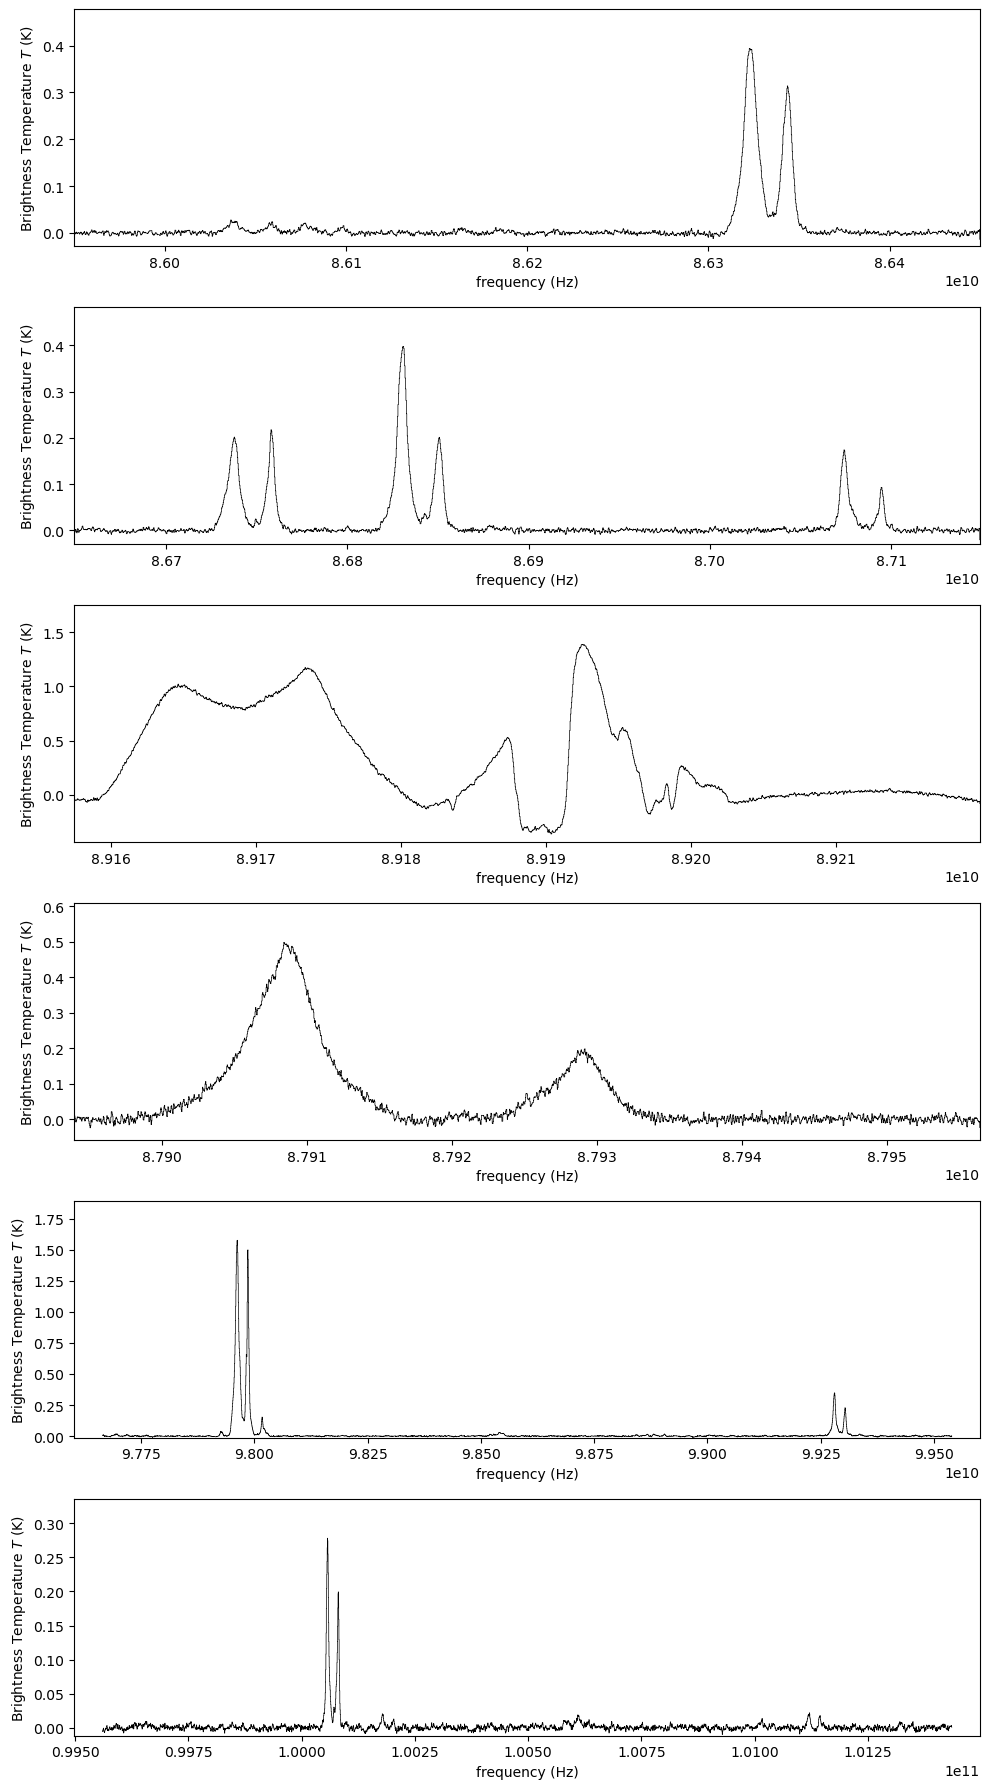

In [839]:
pl.figure(figsize=(10, 18))
for ii, cu in enumerate(tpcubes):
    xx, yy = cu.wcs.celestial.world_to_pixel(coord)
    sp_ = cu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=pl.subplot(6, 1, ii+1))
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
    if ii != 3:
        ax.set_ylabel("")
pl.tight_layout()

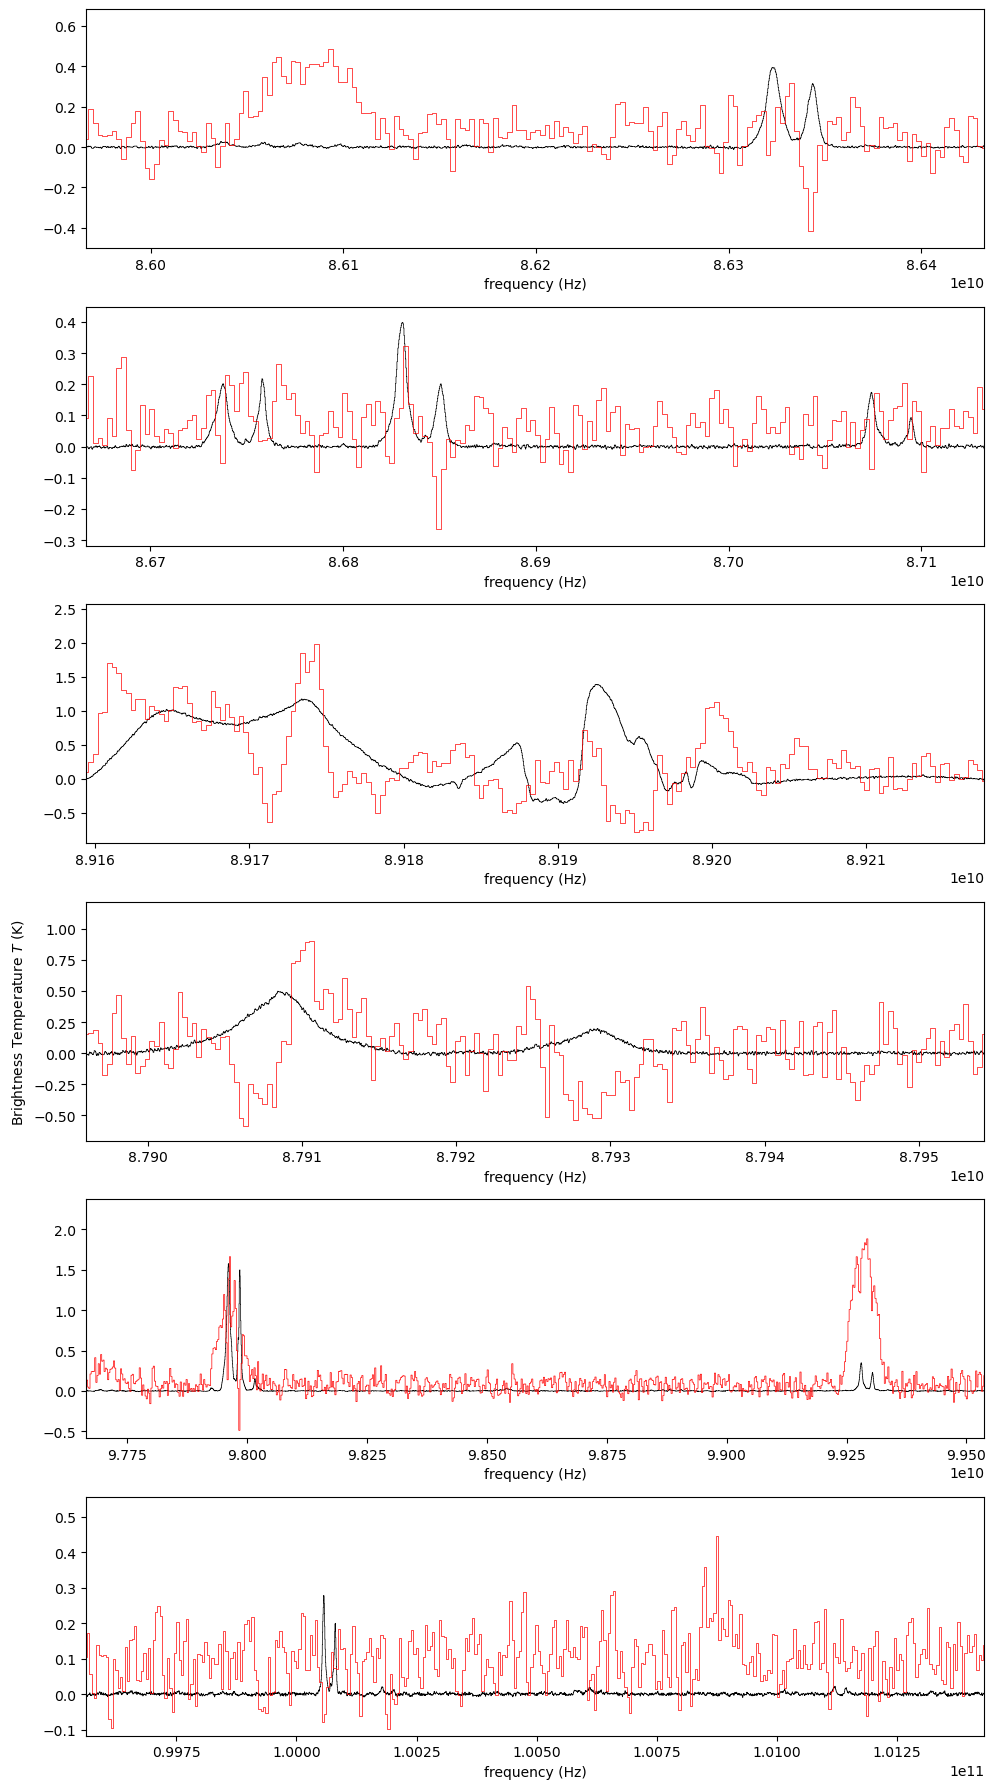

In [852]:
pl.figure(figsize=(10,18))
for ii, (tpcu, tmcu)  in enumerate(zip(tpcubes, cubes)):
    ax = pl.subplot(6, 1, ii+1)
    
    xx, yy = tpcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tpcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.plotter(axis=ax)
    
    xx, yy = tmcu.wcs.celestial.world_to_pixel(coord)
    sp_ = tmcu[:, int(yy), int(xx)].to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
    sp.smooth(5)
    sp.plotter(axis=ax, clear=False, color='r')
    if ii != 3:
        ax.set_ylabel("")
    #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
    #sp.smooth(smfac, downsample=True)
pl.tight_layout()

### C34S Tsuboi

Not a clear detection spatially (was kinda clear spectrally?)

In [314]:
c34s2012_scube = c34scube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_c34s21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_c34s2012 = sc.median(axis=0)

background_stddev_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_c34s2012 = c34s2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_c34s2012_spec = c34s2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


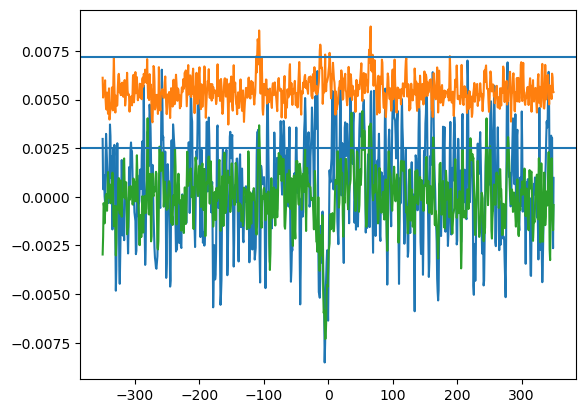

In [315]:
pl.plot(mean_c34s2012_spec.spectral_axis, mean_c34s2012_spec.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_stddev_c34s2012.value)
pl.plot(mean_c34s2012_spec.spectral_axis, background_mean_c34s2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev           theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- ------------------
    17.359836393603224 29.775969638907664 31.109106845025654 8.283242158498897 9.898672930205665 1.8347554157856887


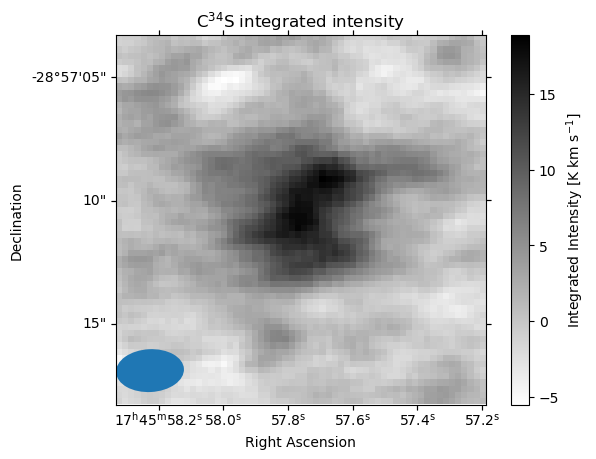

In [316]:
m0 = ((c34s2012_scube.mask_out_bad_beams(threshold=0.1)-contest_c34s2012)
      .with_mask((background_stddev_c34s2012 < 0.0072*background_stddev_c34s2012.unit)[:,None,None])
      .with_mask((mean_c34s2012_spec > 0.0025*mean_c34s2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(c34s2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("C$^{34}$S integrated intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:c34s2012_scube.shape[1], :c34s2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)

# try:
#     deconv_size = src.deconvolve(m0.beam)
#     
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   deconv_size.major, deconv_size.minor, deconv_size.pa
#                                  ])
# except radio_beam.utils.BeamError:
#     centroid_measurements.append(['H13CO+2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
#                                   np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
#                                  ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/c34s10_2012_m0.fits', overwrite=True)

#### CS Tsuboi

In [317]:
cs2012_scube = cscube_2012.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=nurest_cs21).spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
contest_cs2012 = sc.median(axis=0)

background_stddev_cs2012 = cs2012_scube.subcube_from_regions([annulus]).std(axis=(1,2))
background_mean_cs2012 = cs2012_scube.subcube_from_regions([annulus]).mean(axis=(1,2))
mean_cs2012_spec = cs2012_scube.subcube_from_regions([circle]).mean(axis=(1,2))

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


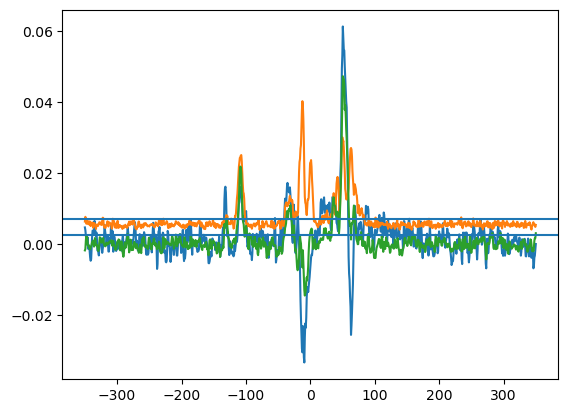

In [318]:
pl.plot(mean_cs2012_spec.spectral_axis, mean_cs2012_spec.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_stddev_cs2012.value)
pl.plot(mean_cs2012_spec.spectral_axis, background_mean_cs2012.value)
pl.axhline(0.0072)
pl.axhline(0.0025)

Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.


Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean             y_mean            x_stddev          y_stddev            theta       
    ------------------ ------------------ ------------------ ----------------- ----------------- -------------------
    39.360510712713065 28.418343038492665 29.929129423065167 7.372685417116367 5.603355578707319 0.10236894555425441


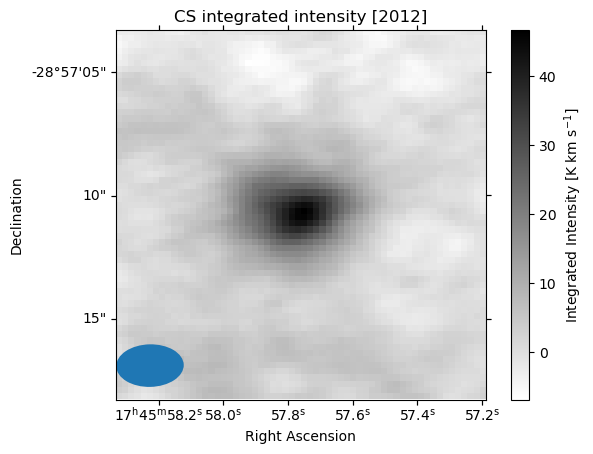

In [319]:
m0 = ((cs2012_scube-contest_cs2012)
      .with_mask((background_stddev_cs2012 < 0.0072*background_stddev_cs2012.unit)[:,None,None])
      .with_mask((mean_cs2012_spec > 0.0025*mean_cs2012_spec.unit)[:,None,None])
      .spectral_slab(-250*u.km/u.s, 250*u.km/u.s)
     ).to(u.K).moment0()

jtok = m0.beam.jtok(cs2012_scube.with_spectral_unit(u.GHz).spectral_axis[0]).value

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Integrated Intensity [K km s$^{-1}$]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("CS integrated intensity [2012]")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:cs2012_scube.shape[1], :cs2012_scube.shape[2]]
stddev = stats.mad_std(m0.value)
g = fit_g(g_init, x, y, z=m0.value, weights=1/stddev)
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

if g.x_stddev >= g.y_stddev:
    src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
else:
    src = radio_beam.Beam(major=g.y_stddev*pixscale*sig2fwhm, minor=g.x_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)

try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ])
except radio_beam.utils.BeamError:
    centroid_measurements.append(['CS 2-1 2012', 'm0', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.arcsec, np.nan*u.arcsec, np.nan*u.arcsec, 
                                 ])


m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cs21_2012_m0.fits', overwrite=True)

## continuum

In [320]:
ls /orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/*spw33_35*cont*fits -d 

/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits*


In [321]:
from astropy.io import fits
from astropy.wcs import WCS

In [322]:
fn = "/orange/adamginsburg/ACES/data/2021.1.00172.L/science_goal.uid___A001_X1590_X30a8/group.uid___A001_X1590_X30a9/member.uid___A001_X15a0_X13c/calibrated/working/uid___A001_X15a0_X13c.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0.pbcor.fits"
fh = fits.open(fn)
contwcs = WCS(fh[0].header).celestial
preg = region.to_pixel(contwcs)
msk = preg.to_mask()
contim = msk.cutout(fh[0].data.squeeze());
beam = radio_beam.Beam.from_fits_header(fh[0].header)
jtok = beam.jtok(102*u.GHz).value
contim = contim * jtok

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
        amplitude            x_mean            y_mean           x_stddev          y_stddev             theta        
    ------------------ ------------------ ---------------- ----------------- ------------------ --------------------
    0.1035993267353875 29.103155173688595 29.0539155378385 2.825038328095847 2.4486689380830784 -0.08217934448721827


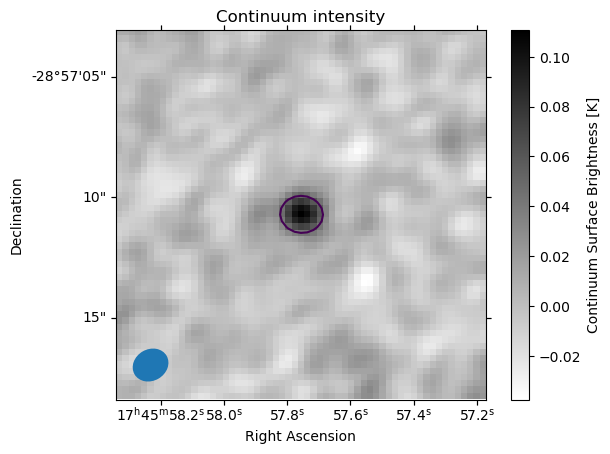

In [323]:
fig = pl.figure()
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
contwcs_co = contwcs[slcs] 
ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(contim, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = contwcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("Continuum intensity")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum.pdf', bbox_inches='tight')



g_init = Gaussian2D(amplitude=0.06, x_mean=29, y_mean=29, x_stddev=3., y_stddev=3)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:contim.shape[0], :contim.shape[1]]
stddev = stats.mad_std(contim)
g = fit_g(g_init, x, y, z=contim, weights=1/stddev)
print(g)
cen = contwcs_co.pixel_to_world(g.x_mean, g.y_mean)

src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
deconv_size = src.deconvolve(beam)

centroid_measurements.append(['Continuum', 'spw33+35', g.amplitude.value, g.amplitude.value/jtok, cen.ra, cen.dec,
                              g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                              deconv_size.major, deconv_size.minor, deconv_size.pa
                             ])


header = fh[0].header
header.update(contwcs_co.to_header())
fits.PrimaryHDU(data=contim, header=header).writeto('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/cont_cutout.fits', overwrite=True)

ax.contour(g(x,y), levels=[0.05])

### B7 cont

In [324]:
b7cont = SpectralCube.read('/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.mfs.I.manual.image.pbcor.fits')

In [325]:
b7cont.spectral_axis

<Quantity [3.50113125e+11] Hz>

Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
         amplitude           x_mean            y_mean            x_stddev           y_stddev             theta        
    ------------------- ---------------- ------------------ ------------------ ----------------- ---------------------
    0.08962154543570341 14.0249762541769 15.858071912894735 2.6576907279407394 2.026349586092263 -0.029603097676466444
Deconvolution failed: Beam could not be deconvolved


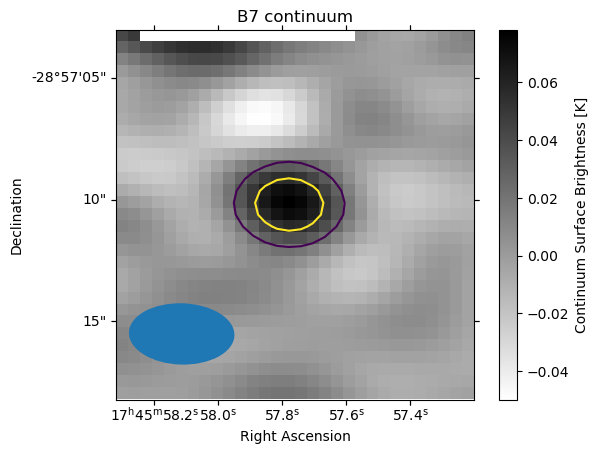

In [326]:
m0 = b7cont.subcube_from_regions([region]).to(u.K)
m0 = m0[0]
jtok = b7cont.beam.jtok(b7cont.spectral_axis[0])

fig = pl.figure()
ax = pl.subplot(projection=m0.wcs.celestial)
im = ax.imshow(m0.value, cmap='gray_r')
cb = pl.colorbar(mappable=im)
cb.set_label("Continuum Surface Brightness [K]")
pixscale = m0.wcs.celestial.proj_plane_pixel_area()**0.5
ellipse_artist = m0.beam.ellipse_to_plot(5, 5, pixscale)
ax.add_artist(ellipse_artist)  
ax.set_xlabel("Right Ascension")
ax.set_ylabel("Declination")
ax.set_title("B7 continuum")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.pdf', bbox_inches='tight')

g_init = Gaussian2D(amplitude=0.06, x_mean=m0.shape[1]/2, y_mean=m0.shape[0]/2, x_stddev=2.5, y_stddev=2.5)
fit_g = LevMarLSQFitter()
y, x = np.mgrid[:m0.shape[0], :m0.shape[1]]
stddev = stats.mad_std(m0.value[np.isfinite(m0.value)])
g = fit_g(g_init, x, y, z=np.nan_to_num(m0.value), weights=np.nan_to_num(1/stddev))
print(g)
cen = m0.wcs.pixel_to_world(g.x_mean, g.y_mean)

src = radio_beam.Beam(major=g.x_stddev*pixscale*sig2fwhm, minor=g.y_stddev*pixscale*sig2fwhm, pa=90*u.deg+g.theta*u.rad)
try:
    deconv_size = src.deconvolve(m0.beam)
    
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec,
                                  g.x_stddev*pixscale*sig2fwhm, g.y_stddev*pixscale*sig2fwhm, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  deconv_size.major, deconv_size.minor, deconv_size.pa
                                 ])
except Exception as ex:
    print(f"Deconvolution failed: {ex}")
    centroid_measurements.append(['Continuum', 'B7', g.amplitude.value, g.amplitude.value/jtok.value, cen.ra, cen.dec, g.x_stddev*pixscale, g.y_stddev*pixscale, 90*u.deg + (g.theta*u.rad).to(u.deg),
                                  np.nan*u.deg, np.nan*u.deg, np.nan*u.deg
                                 ])

m0.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_continuum.fits', overwrite=True)
ax.contour(g(x,y), levels=[0.02, 0.05])

### NIR cont

In [327]:
from astropy.visualization import simple_norm

In [328]:
slcs = msk.get_overlap_slices(fh[0].data.squeeze().shape)
slcs

((slice(1209, 1268, None), slice(698, 757, None)),
 (slice(0, 59, None), slice(0, 59, None)))

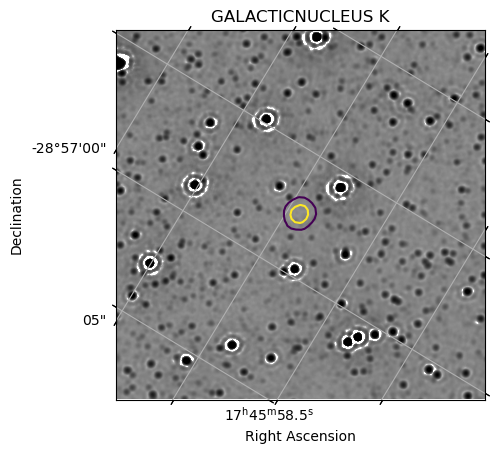

In [329]:
# Show continuum on NIR
fh = fits.open('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/Field6_chip3holo_2_cal.fits')
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim, transform=ax.get_transform(contwcs_co),
           levels=[0.04,  0.08, ]);
ax.set_xlabel("Right Ascension")
ax.grid()
ax.set_ylabel("Declination")
ax.set_title("GALACTICNUCLEUS K")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/nir_continuum.pdf', bbox_inches='tight')

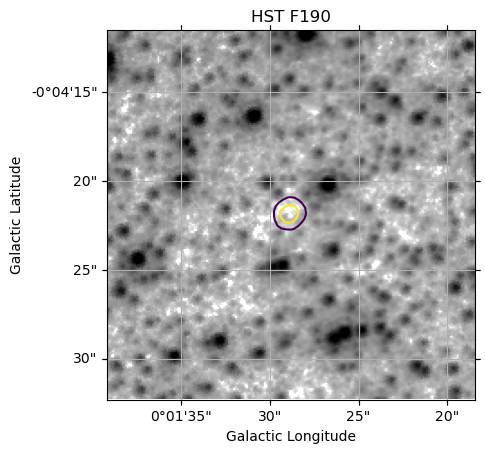

In [330]:
# Show continuum on NIR HST
fh = fits.open('/orange/adamginsburg/cmz/hst_paschenalpha/hlsp_hpsgc_hst_nicmos-nic3_gc_f190n_v1_img.fits')
fh[0].header['CTYPE1'] = 'GLON-TAN'
fh[0].header['CTYPE2'] = 'GLAT-TAN'
nirwcs = WCS(fh[0].header)
preg = region.to_pixel(nirwcs)
msk = preg.to_mask()
nirim = msk.cutout(fh[0].data.squeeze());
slcs,_ = msk.get_overlap_slices(fh[0].data.squeeze().shape)

fig = pl.figure()
ax = pl.subplot(projection=nirwcs[slcs])
#ax = pl.subplot(projection=contwcs_co)
im = ax.imshow(nirim, cmap='gray_r', norm=simple_norm(nirim, stretch='log', max_percent=99.5, min_percent=1),
               #transform=ax.get_transform(nirwcs[slcs]),
              )
ax.contour(contim, transform=ax.get_transform(contwcs_co),
           levels=[0.04,  0.08, ]);
ax.set_xlabel("Galactic Longitude")
ax.grid()
ax.set_ylabel("Galactic Latitude")
ax.set_title("HST F190")
fig.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/HSTF190nir_continuum.pdf', bbox_inches='tight')

### Make table

In [331]:
latexdict2 = latex_info.latexdict.copy()
latexdict2['header_start'] = r'\label{tab:spatial_measurements}'
latexdict2['caption'] = 'Spatial Measurements'
latexdict2['preamble'] = r'\centering'
formats2 = {'Amp[Jy]': lambda x: "{0:0.3f}".format(x),
           'Amp': lambda x: "{0:0.3f}".format(x),
           'RA': lambda x: "{0:0.5f}".format(x),
           'Dec': lambda x: "{0:0.5f}".format(x),
           'Major': lambda x: "{0:0.3f}".format(x),
           'Minor': lambda x: "{0:0.3f}".format(x),
           'PA': lambda x: "{0:0.3f}".format(x),
           'D. Major': lambda x: "{0:0.3f}".format(x),
           'D. Minor': lambda x: "{0:0.3f}".format(x),
           'D. PA': lambda x: "{0:0.3f}".format(x),
          }

In [332]:
centrfittbl = Table((list(zip(*centroid_measurements))), names=['Image Data', 'Image Type', 'Amp', 'Amp[Jy]', 'RA', 'Dec', 'Major', 'Minor', 'PA',
                                                  'D. Major', 'D. Minor', 'D. PA'])
centrfittbl['Amp'].unit = u.K
centrfittbl['Amp[Jy]'].unit = u.Jy
centrfittbl['D. Major'] = centrfittbl['D. Major'].to(u.arcsec)
centrfittbl['D. Minor'] = centrfittbl['D. Minor'].to(u.arcsec)
centrfittbl['Major'] = centrfittbl['Major'].to(u.arcsec)
centrfittbl['Minor'] = centrfittbl['Minor'].to(u.arcsec)
centrfittbl.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.ecsv', overwrite=True)
centrfittbl.write('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/centroid_fits.tex', latexdict=latexdict2, formats=formats2, overwrite=True)

Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
Format strings passed to MaskedConsta

In [333]:
centrfittbl

<Table length=5>
 Image Data  Image Type         Amp                Amp[Jy]                RA                 Dec               Major              Minor                PA             Dec Major          Dec Minor            Dec PA      
                                 K                    Jy                 deg                 deg               arcsec             arcsec              deg               arcsec             arcsec              deg        
   str12        str8          float64              float64             float64             float64            float64            float64            float64            float64            float64            float64      
------------ ---------- ------------------- --------------------- ------------------ ------------------- ------------------ ------------------ ------------------ ------------------ ------------------ ------------------
SO 3(2)-2(1)         m0  148.32008973612423     2.795070225002834 266.49059621672524 -28.952990249181713 1.5486420853915617  1.816424839130068 205.08120935934954                nan                nan                nan
      CS 2-1         m0  55.650578910083006    1.0210559520261366  266.4906315066001  -28.95299319702855  2.554813769963019 1.9280031774006974  86.04330791498653 2.0413880914318168 1.1669502937327825  80.21977333385156
 CS 2-1 2012         m0  39.360510712713065    1.4592038781000234  266.4907519289075 -28.952964840932044  4.340336851482971  3.298723509043788  95.86530853346329 3.3763950879892164  2.799194720494421 -78.41912117451031
   Continuum   spw33+35  0.1035993267353875 0.0017704635890274662 266.49064343001675  -28.95297402672501 1.7296387895749605 1.4992054217510515   85.2914703977307  0.993674639596028 0.4279084517674038  60.15390194446932
   Continuum         B7 0.08962154543570341   0.09821868120890748  266.4907408658049 -28.952833241989136 1.3022684566908564  0.992911297185128  88.30386744262493                nan                nan                nan

#### Spectral Index

In [334]:
# wrong
# np.log(centrfittbl['Amplitude'][3] / centrfittbl['Amplitude'][2]) / np.log((350*u.GHz/(102*u.GHz)).decompose().value) + 2

In [335]:
centrfittbl.add_index('Image Data')
centrfittbl.add_index('Image Type')
b7r = centrfittbl.loc['Continuum'].loc['Image Type', 'B7']
b3r = centrfittbl.loc['Continuum'].loc['Image Type', 'spw33+35']
spectral_index = (
    np.log(b7r['Amp[Jy]'] / b3r['Amp[Jy]']) /
    np.log((350*u.GHz/(102*u.GHz)).decompose().value))
spectral_index

3.2571647865885356

# model SO

In [379]:
from pyspeckit.spectrum.models import lte_molecule
from astroquery.linelists.cdms import CDMS
from astroquery.jplspec import JPLSpec
cdmstbl = CDMS.get_species_table()

In [380]:
cdmstbl[np.core.defchararray.find(cdmstbl['molecule'], 'SO') != -1]

<Table length=12>
 tag     molecule    #lines lg(Q(1000)) lg(Q(500)) lg(Q(300)) lg(Q(225)) lg(Q(150)) lg(Q(75)) lg(Q(37.5)) lg(Q(18.75)) lg(Q(9.375)) lg(Q(5.000)) lg(Q(2.725))
int64     str24       str9    float64    float64    float64    float64    float64    float64    float64     float64      float64      float64      float64   
----- -------------- ------ ----------- ---------- ---------- ---------- ---------- --------- ----------- ------------ ------------ ------------ ------------
48501        SO, v=0    449         nan        nan     2.9295     2.8009     2.6175    2.2956      1.9559       1.5897       1.2015       0.8698       0.6058
48502        SO, v=1    245         nan        nan     2.9295     2.8009     2.6175    2.2956      1.9559       1.5897       1.2015          nan          nan
48504 SO-sgl-D, v0,1     80         nan        nan     2.4708     2.3441     2.1678    1.8677      1.5686       1.2715       0.9784          nan          nan
49502          SO-17   2380         nan        nan      3.725     3.5962     3.4128    3.0906      2.7504       2.3831       1.9932       1.6596       1.3939
49512            HSO   6815         nan        nan     4.0112     3.8237     3.5595    3.1085      2.6586       2.2106       1.7676       1.3968       1.1146
50502          SO-18    359         nan        nan     2.9627     2.8339     2.6504     2.328      1.9873       1.6191       1.2276       0.8923       0.6252
64502       SO2, v=0  14754         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194       1.1157       0.7309
64503      SO2, v2=1   9808         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194          nan          nan
64512       SO2, nu2   7603         nan     4.1935     3.8067     3.5999     3.3231    2.8687      2.4177       1.9677       1.5194          nan          nan
65502         SOO-17   7476         nan      5.201     4.8674     4.6797     4.4153    3.9638      3.5128       3.0628       2.6144          nan          nan
65510      cis-HOSO+   4618         nan        nan       4.17     3.9824      3.718    3.2666      2.8156       2.3655       1.9169       1.5127       1.1269
66502         SOO-18  11511         nan        nan      4.104     3.9163      3.652    3.2004      2.7495       2.2994       1.8509          nan          nan

In [381]:
scubes[0].find_lines(velocity_offset=40*u.km/u.s, velocity_convention='radio', rest_value=90*u.GHz, chemical_name='SO')

<Table length=11>
   Species     Chemical Name  Freq-GHz(rest frame,redshifted) Freq Err(rest frame,redshifted) Meas Freq-GHz(rest frame,redshifted) Meas Freq Err(rest frame,redshifted) ... E_L (cm^-1)  E_L (K)   E_U (cm^-1)  E_U (K)   Linelist
    str13          str15                  float64                         float64                           float64                              float64                ...   float64    float64     float64    float64     str5  
------------- --------------- ------------------------------- ------------------------------- ------------------------------------ ------------------------------------ ... ----------- ---------- ----------- ---------- --------
     34SO2v=0  Sulfur Dioxide                       85.972404                         1.7e-05                                   --                                   -- ...     368.051  530.30844   370.91873  534.44043    SLAIM
     34SO2v=0  Sulfur Dioxide                       85.972412                         4.6e-06                                   --                                   -- ...     368.051  530.30844   370.91873  534.44043     CDMS
     34SO2v=0  Sulfur Dioxide                      85.9724123                         4.6e-06                                   --                                   -- ...     368.051  530.30844   370.91873  534.44043      JPL
      SO2v2=2  Sulfur Dioxide                       86.005572                        0.000682                                   --                                   -- ...     691.418 1047.57007   694.28684 1051.91665    SLAIM
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                             86.09395                               0.0001 ...      10.552   15.18189    13.42379   19.31372     CDMS
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                             86.09395                               0.0001 ...      10.552   15.18189    13.42379   19.31372      JPL
SO3&Sigma;v=0 Sulfur Monoxide                       86.093983                           4e-06                                   --                                   -- ...         0.0        0.0         0.0        0.0    Lovas
SO3&Sigma;v=0 Sulfur Monoxide                       86.093983                           4e-06                             86.09395                                1e-05 ...      10.552   15.18189    13.42379   19.31372    SLAIM
       SO2v=0  Sulfur dioxide                              --                              --                           86.1537638                                2e-06 ...    633.8571  911.97373   636.73088  916.10844     CDMS
       SO2v=0  Sulfur dioxide                              --                              --                           86.1537638                                3e-06 ...    633.8571  911.97373   636.73088  916.10844      JPL
       SO2v=0  Sulfur dioxide                       86.153779                           3e-06                            86.153764                                3e-06 ...     633.857  911.97359   636.73078  916.10829    SLAIM

In [382]:
scubes[-2].find_lines(velocity_offset=40*u.km/u.s, velocity_convention='radio', rest_value=90*u.GHz, chemical_name=' SO ')

<Table length=10>
   Species     Chemical Name  Freq-GHz(rest frame,redshifted) Freq Err(rest frame,redshifted) Meas Freq-GHz(rest frame,redshifted) Meas Freq Err(rest frame,redshifted) ... E_L (cm^-1)  E_L (K)   E_U (cm^-1)  E_U (K)   Linelist
    str13          str15                  float64                         float64                           float64                              float64                ...   float64    float64     float64    float64     str5  
------------- --------------- ------------------------------- ------------------------------- ------------------------------------ ------------------------------------ ... ----------- ---------- ----------- ---------- --------
SO3&Sigma;v=1 Sulfur Monoxide                      98.3175545                        2.72e-05                                   --                                   -- ...   1134.9339 1632.90733  1138.21342  1637.6258     CDMS
SO3&Sigma;v=1 Sulfur Monoxide                       98.317606                         2.9e-05                                   --                                   -- ...      23.434    33.7161    26.71352   38.43458    SLAIM
SO3&Sigma;v=1 Sulfur Monoxide                      98.3180964                       0.0015506                                   --                                   -- ...   1134.9344 1632.90805  1138.21394 1637.62654      JPL
SO3&Sigma;v=1 Sulfur Monoxide                      98.7580084                       0.0010452                                   --                                   -- ...   1114.5902 1603.63745  1117.88441 1608.37706      JPL
SO3&Sigma;v=1 Sulfur Monoxide                              --                              --                            98.758182                                8e-05 ...   1114.5902 1603.63745  1117.88442 1608.37707     CDMS
SO3&Sigma;v=1 Sulfur Monoxide                       98.758192                         3.3e-05                             98.75818                                8e-06 ...        3.09     4.4458     6.38422    9.18541    SLAIM
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                             99.29987                               0.0001 ...      3.0999    4.46004     6.41219    9.22565     CDMS
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                             99.29987                               0.0001 ...      3.0999    4.46004     6.41219    9.22565      JPL
SO3&Sigma;v=0 Sulfur Monoxide                       99.299905                         1.4e-05                                   --                                   -- ...         0.0        0.0         0.0        0.0    Lovas
SO3&Sigma;v=0 Sulfur Monoxide                       99.299905                         1.4e-05                             99.29987                                1e-05 ...         3.1    4.46018     6.41229     9.2258    SLAIM

In [383]:
freqs, aij, deg, EU, partfunc = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [384]:
freqs_SO, aij_SO, deg_SO, EU_SO, partfunc_SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=48501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [385]:
freqs_SO2, aij_SO2, deg_SO2, EU_SO2, partfunc_SO2 = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=64502,
                                                                      catalog='CDMS', parse_name_locally=False)

In [386]:
freqs_CS, aij_CS, deg_CS, EU_CS, partfunc_CS = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=44501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [387]:
freqs_34SO, aij_34SO, deg_34SO, EU_34SO, partfunc_34SO = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=50501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [388]:
freqs_CH3SH, aij_CH3SH, deg_CH3SH, EU_CH3SH, partfunc_CH3SH = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=48510,
                                                                      catalog='CDMS', parse_name_locally=False)

In [389]:
freqs_C34S, aij_C34S, deg_C34S, EU_C34S, partfunc_C34S = lte_molecule.get_molecular_parameters(molecule_name=None, molecule_tag=46501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [390]:
freqs_H13COp, aij_H13COp, deg_H13COp, EU_H13COp, partfunc_H13COp = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                         molecule_tag=30504,
                                                                      catalog='CDMS', parse_name_locally=False)

In [447]:
freqs_H13CN, aij_H13CN, deg_H13CN, EU_H13CN, partfunc_H13CN = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28501,
                                                                      catalog='CDMS', parse_name_locally=False)

In [490]:
freqs_HC15N, aij_HC15N, deg_HC15N, EU_HC15N, partfunc_HC15N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                                    molecule_tag=28506,
                                                                      catalog='CDMS', parse_name_locally=False)

In [500]:
freqs_SiO, aij_SiO, deg_SiO, EU_SiO, partfunc_SiO = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=44505,
                                                                      catalog='CDMS', parse_name_locally=False)

In [514]:
freqs_HC3N, aij_HC3N, deg_HC3N, EU_HC3N, partfunc_HC3N = lte_molecule.get_molecular_parameters(molecule_name=None,
                                                                                          molecule_tag=51501,
                                                                      catalog='CDMS', parse_name_locally=False)

## Simple rotational diagram

In [391]:
meastable

<Table length=8>
       Line       Rest Frequency              Amplitude / Error                           Center / Error             ...  $\sigma_{v,cen}$     Width [vel]     $\sigma_{\sigma_v}$       Species       
                        Hz                            K                                         Hz                   ...       km / s             km / s              km / s                           
      str17          float64                      float64[2]                                float64[2]               ...      float64            float64             float64              str20        
----------------- -------------- ------------------------------------------- --------------------------------------- ... ------------------ ------------------ ------------------- --------------------
           CS 2-1  97980950000.0   1.0319974847791353 .. 0.04397750007722898 97965562285.57666 .. 1002871.3781635581 ...   3.06848704281292  69.86299227186738  2.8266483217816205               CS 2-1
           SO 3-2  99299870000.0   1.868806362450975 .. 0.030531296047750518 99285823348.80467 .. 366324.30748746375 ... 1.1059557738274437  66.43934639033277  1.0599924162957055               SO 3-2
         34SO 3-2  97715317000.0 0.21635256073961096 .. 0.023914645461206262    97703940084.093 .. 2603077.087169318 ...  7.986290197738089 62.359767879096374   8.352039733312695        $^{34}$SO 3-2
     SO 2(2)-1(1)  86093950000.0  0.3828433596099744 .. 0.026167578249070324  86082902388.39632 .. 1536167.511113989 ...  5.349173014556831  67.77755515045868   5.349172981667376         SO 2(2)-1(1)
SO2 2(2,0)-3(1,3) 100878105000.0 0.17151400547254475 .. 0.028675486287036096 100874782755.89418 .. 4796354.816369068 ... 14.253945391216671  73.82811000515491  14.253945285804658 SO$_2$ 2(2,0)-3(1,3)
         C34S 2-1  96412951000.0  0.13853527520451572 .. 0.02137043261956888  96396623397.53908 .. 3400937.958181477 ... 10.575089128728424  59.36646510185304  10.575089134905047        C$^{34}$S 2-1
    CS 2-1 (2012)  97980950000.0    0.538483824315997 .. 0.02748337250869406  97967649265.22664 .. 1142176.976084657 ...  3.494720587332808  67.35358672034356   3.273608958511121        CS 2-1 (2012)
  34SO 3-2 (2012)  97715317000.0 0.12926819946106832 .. 0.014652913600035832   97697448799.6016 .. 3058414.059952523 ...  9.383272722892832  71.69682244972846   9.383272700324666 $^{34}$SO 3-2 (2012)

In [392]:
#integ_so32 = (spw33.specfit.parinfo['AMPLITUDE1'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH1'].value/spw33.specfit.parinfo['SHIFT1'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
# this is amplitude-only error, ignoring width error
# err_so32 = (spw33.specfit.parinfo['AMPLITUDE0'].error *
#               (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO3221 = np.argmin(np.abs(spw33.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 3-2']
integ_so32 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so32 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO3221 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO3221 = 10**aij_SO[ind_SO3221]
nup_so32 = lte_molecule.nupper_of_kkms(integ_so32, nurest_so32, Aul_SO3221)
enup_so32 = lte_molecule.nupper_of_kkms(err_so32, nurest_so32, Aul_SO3221)
nup_so32, err_so32, integ_so32

(<Quantity 5.30154715e+14 1 / cm2>, 5.084643702896449, 311.2286647742644)

In [393]:
#integ_cs21 = (spw33.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw33.specfit.parinfo['WIDTH0'].value/spw33.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#Aul_CS21 = 10**aij_CS[np.argmin(np.abs(spw33.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_CS))]
row = meastable.loc['CS 2-1']
integ_cs21 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_cs21 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_cs21 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_CS21 = 10**aij_CS[ind_cs21]
nup_cs21 = lte_molecule.nupper_of_kkms(integ_cs21, nurest_cs21, Aul_CS21)
nup_cs21, integ_cs21

(<Quantity 2.29488984e+14 1 / cm2>, 180.72396896905184)

In [394]:
#integ_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].value *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
## approximate error as dominated by amplitude...
#err_so22 = (spw25.specfit.parinfo['AMPLITUDE0'].error *
#              (2 * np.pi)**0.5 * (spw25.specfit.parinfo['WIDTH0'].value/spw25.specfit.parinfo['SHIFT0'].value)
#              * constants.c * u.K).to(u.K * u.km/u.s)
#ind_SO2211 = np.argmin(np.abs(spw25.specfit.parinfo['SHIFT0'].value*u.Hz - freqs_SO))
row = meastable.loc['SO 2(2)-1(1)']
integ_so22 = row['Amplitude / Error'][0] * row['Width (sigma)'] * (2 * np.pi)**0.5
err_so22 = row['Amplitude / Error'][1] * row['Width (sigma)'] * (2 * np.pi)**0.5
ind_SO2211 = np.argmin(np.abs(u.Quantity(row['Rest Frequency'], u.Hz) - freqs_SO))
Aul_SO2211 = 10**aij_SO[ind_SO2211]
nup_so22 = lte_molecule.nupper_of_kkms(integ_so22, nurest_so21, Aul_SO2211)
enup_so22 = lte_molecule.nupper_of_kkms(err_so22, nurest_so21, Aul_SO2211)
integ_so22, err_so22, nup_so22, enup_so22

(65.04245900896179,
 4.445691933544022,
 <Quantity 1.78505341e+14 1 / cm2>,
 <Quantity 1.22009495e+13 1 / cm2>)

In [395]:
# SO is a nondetection
# integ_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].value *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# # approximate error as dominated by amplitude...
# err_so45 = (spw35.specfit.parinfo['AMPLITUDE1'].error *
#               (2 * np.pi)**0.5 * (spw35.specfit.parinfo['WIDTH1'].value/spw35.specfit.parinfo['SHIFT1'].value)
#               * constants.c * u.K).to(u.K * u.km/u.s)
# ind_SO4544 = np.argmin(np.abs(spw35.specfit.parinfo['SHIFT1'].value*u.Hz - freqs_SO))

# approximate as 1-sigma
integ_so45 = err_so32
ind_SO4544 = np.argmin(np.abs(nurest_so45 - freqs_SO))
Aul_SO4544 = 10**aij_SO[ind_SO4544]
nup_so45 = lte_molecule.nupper_of_kkms(integ_so45, nurest_so45, Aul_SO4544)
integ_so45, nup_so45

(5.084643702896449, <Quantity 9.13570865e+13 1 / cm2>)

In [396]:
[ind_SO3221, ind_SO2211]
EU_SO[[ind_SO3221, ind_SO2211]]
deg_SO[[ind_SO3221, ind_SO2211]]

array([7, 5])

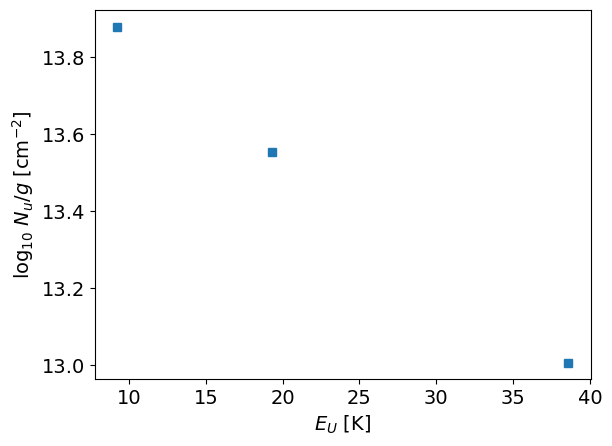

In [397]:
pl.plot((EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose(),
        np.log10((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value),
        's')
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");

In [398]:
from astropy import modeling
from astropy.modeling.models import custom_model

@custom_model
def model(eupper, logcolumn=np.log(1e13), tem=20):
    """
    Calculate the quantity N_u/g_u as a function of E_u in Kelvin

    The 'logcolumn' quantity is N_tot / Q_tot

    Temperature is the excitation temperature
    """

    result = -1/tem * eupper + logcolumn

    return result
fitter = modeling.fitting.LevMarLSQFitter()

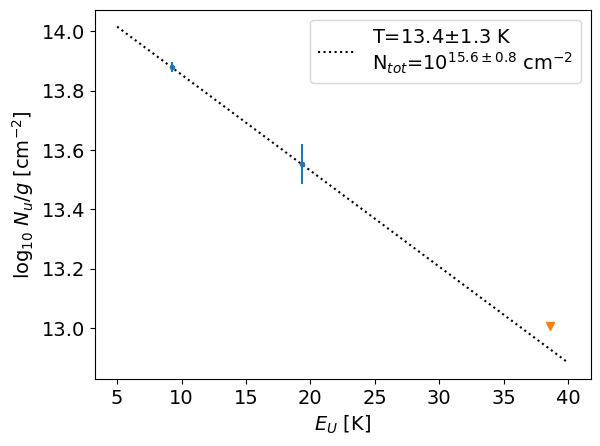

In [399]:
xvals = (EU_SO[[ind_SO3221, ind_SO2211,]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
errors = np.log((u.Quantity([enup_so32, enup_so22]) / deg_SO[[ind_SO3221, ind_SO2211]]).value)
fracerrors = ((u.Quantity([enup_so32/nup_so32, enup_so22/nup_so22])).value)
rslt = fitter(model(), xvals, yvals, weights=1/(fracerrors))

pl.errorbar(xvals,
            yvals * np.log10(np.exp(1)),
            yerr=fracerrors,
            linestyle='none',
            marker='.')

# plot 4544 but don't include in fit
xvals = (EU_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]*u.erg / constants.k_B).decompose().value
yvals = np.log((u.Quantity([nup_so32, nup_so22, nup_so45]) / deg_SO[[ind_SO3221, ind_SO2211, ind_SO4544]]).value)
pl.plot(xvals[2:],
        yvals[2:] * np.log10(np.exp(1)),
        'v')
elogcol = fitter.fit_info["cov_x"][0,0]**0.5
ecol = np.log10(np.exp(elogcol))*partfunc_SO(rslt.tem) # not sure this is right...
pl.plot(np.linspace(5, 40), rslt(np.linspace(5, 40)) * np.log10(np.exp(1)),
        label=f'T={rslt.tem.value:0.1f}$\pm${fitter.fit_info["cov_x"][1,1]**0.5:0.1f} K\n'
              f'N$_{{tot}}$=$10^{{{np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem)):0.1f}\pm{ecol:0.1f}}} $ cm$^{{-2}}$',
        color='k',
        linestyle=':',
        zorder=-5,
        )
pl.ylabel("log$_{10}$ $N_u / g$ [cm$^{-2}$]")
pl.xlabel("$E_U$ [K]");
pl.legend(loc='best');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_rotationdiagram_fit.pdf", bbox_inches='tight')

In [400]:
rslt.tem, rslt.logcolumn

(Parameter('tem', value=13.413666368478774),
 Parameter('logcolumn', value=32.64606395604551))

In [401]:
rslt.param_names

('logcolumn', 'tem')

In [402]:
rslt.cov_matrix

In [403]:
fitter.fit_info['cov_x']**0.5

invalid value encountered in sqrt


array([[0.06989629,        nan],
       [       nan, 1.25355824]])

In [404]:
fitter.fit_info

{'nfev': 19,
 'fvec': array([-6.30633837e-12, -3.17064508e-12]),
 'fjac': array([[-62.93374976,   0.23247378],
        [ -3.41720159,  -0.79772919]]),
 'ipvt': array([1, 2], dtype=int32),
 'qtf': array([-5.59043782e-08, -1.30506490e-08]),
 'message': 'The relative error between two consecutive iterates is at most 0.000000',
 'ierr': 2,
 'param_jac': None,
 'param_cov': None,
 'cov_x': array([[ 0.00488549, -0.08532495],
        [-0.08532495,  1.57140827]])}

In [405]:
log10col_SO = np.log10(np.exp(rslt.logcolumn.value)*partfunc_SO(rslt.tem))
log10col_SO

15.589637098421601

## Model SO and CS

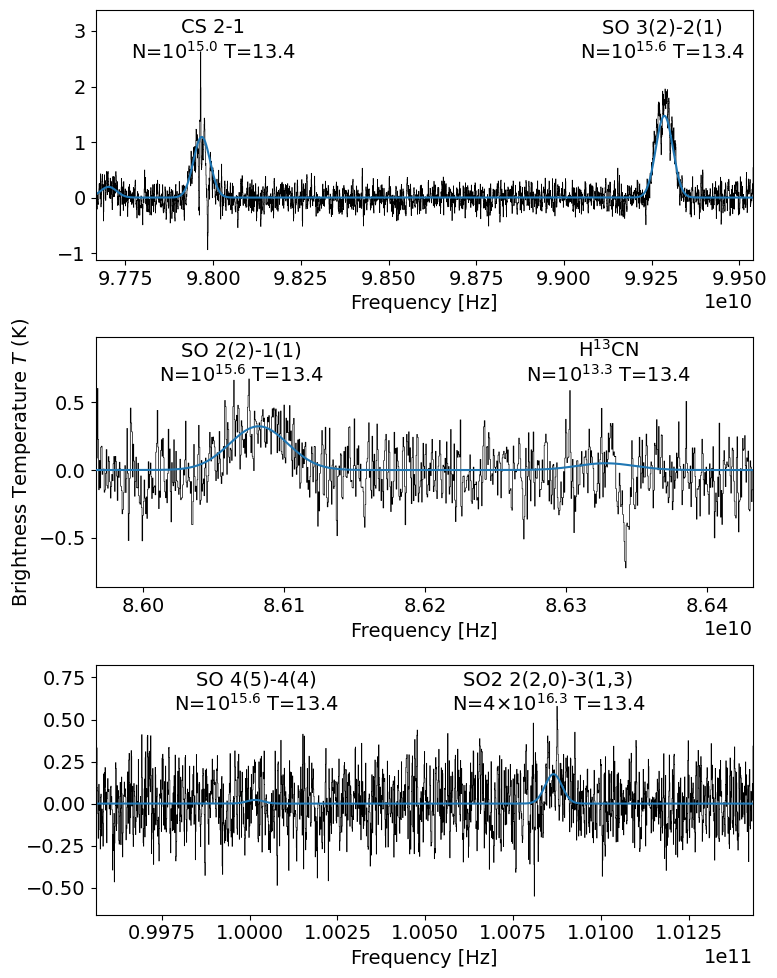

In [522]:
tex = rslt.tem * u.K
column_SO = (10**log10col_SO)*u.cm**-2
column_SO2 = 2e16*u.cm**-2
column_34SO = column_SO/8
column_CS = 1e15*u.cm**-2
column_H13CN = 2e13*u.cm**-2
column_H13COp = 2e13*u.cm**-2
column_SiO = 2e13*u.cm**-2
column_HC15N = 2e13*u.cm**-2
column_HC3N = 5e13*u.cm**-2

# SMOOTH VERSION BELOW IS PREFERRED (more model stuff)
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 +  mod_h13cn)


spw33.xarr.convert_to_unit(u.Hz)

fig = pl.figure(figsize=(8, 10))
spw33.plotter(axis=pl.subplot(3,1,1))
spw33.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 2.5, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 2.5, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
spw25.plotter(axis=pl.subplot(3,1,2))
spw25.plotter.axis.plot(spw25.xarr.value, sospw25mod, zorder=5)
#L1, = spw25.plotter.axis.plot(spw25.xarr.value, mod_so22)
#L2, = spw25.plotter.axis.plot(spw25.xarr.value, mod_h13cn)
pl.text(86.07e9, 0.65, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.65, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35.plotter(axis=pl.subplot(3,1,3))
spw35.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.55, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.55, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.tight_layout()
fig.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit.pdf", bbox_inches='tight')

### Smooth version

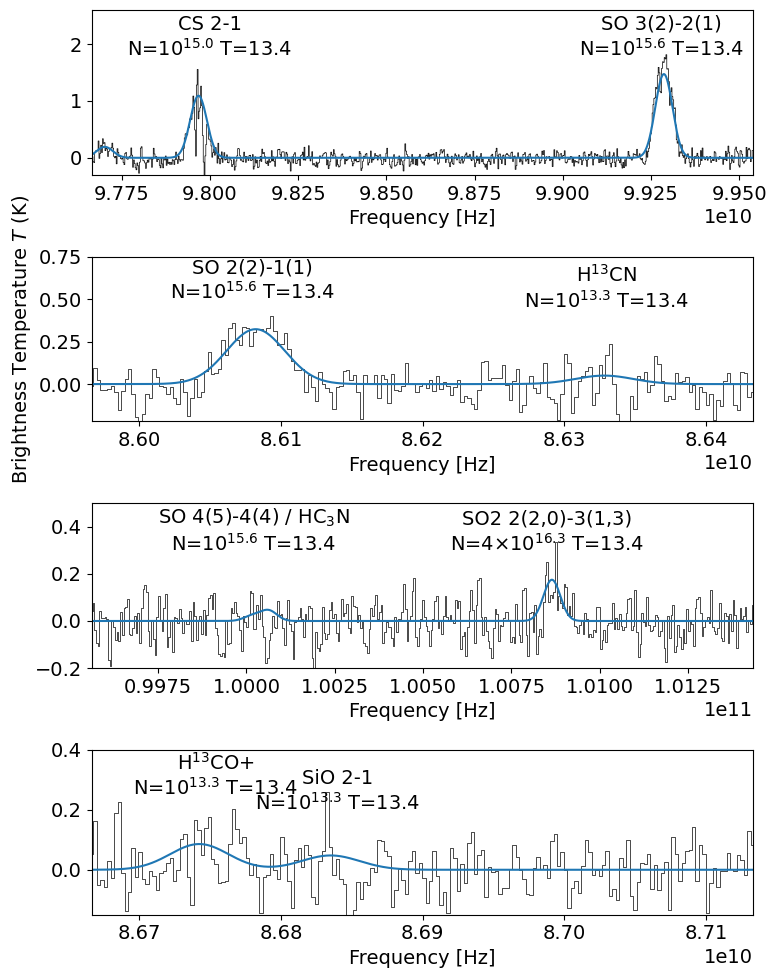

In [525]:
# smooth version, with contsub
spw33sm = spw33.copy()
spw33sm.smooth(5)
spw33sm.data -= np.median(spw33sm.data)
spw35sm = spw35.copy()
spw35sm.smooth(5)
spw35sm.data -= np.median(spw35sm.data)
spw25sm = spw25.copy()
spw25sm.smooth(5)
spw25sm.data -= np.median(spw25sm.data)
spw27sm = spw27.copy()
spw27sm.smooth(5)
spw27sm.data -= np.median(spw27sm.data)


# we're labeling lines, we don't want velocity units
spw33sm.xarr.convert_to_unit(u.Hz)
spw35sm.xarr.convert_to_unit(u.Hz)
spw25sm.xarr.convert_to_unit(u.Hz)
spw33.xarr.convert_to_unit(u.Hz)
spw35.xarr.convert_to_unit(u.Hz)
spw25.xarr.convert_to_unit(u.Hz)

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
mod_h13cn =  lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13CN,
                            freqs=freqs_H13CN, aij=aij_H13CN, deg=deg_H13CN, EU=EU_H13CN, partfunc=partfunc_H13CN)
mod_so22 = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
sospw25mod = (mod_so22 + mod_h13cn + 
              lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO)
             )


sospw27mod = (lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SiO,
                            freqs=freqs_SiO, aij=aij_SiO, deg=deg_SiO, EU=EU_SiO, partfunc=partfunc_SiO) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC15N,
                            freqs=freqs_HC15N, aij=aij_HC15N, deg=deg_HC15N, EU=EU_HC15N, partfunc=partfunc_HC15N) + 
              lte_molecule.generate_model(spw27.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )

pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(4,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 1.8, f"CS 2-1\nN=$10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.8, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.3,2.6)

spw25sm.plotter(axis=pl.subplot(4,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.text(86.08e9, 0.50, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.33e9, 0.45, f"H$^{{13}}$CN\nN=10$^{{{np.log10(column_H13CN.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.22, 0.75)
pl.xlabel("Frequency [Hz]")

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_HC3N,
                            freqs=freqs_HC3N, aij=aij_HC3N, deg=deg_HC3N, EU=EU_HC3N, partfunc=partfunc_HC3N) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             )
spw35sm.plotter(axis=pl.subplot(4,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4) / HC$_3$N\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.10e9, 0.2, f"HC$_3$N 11-10\nN=4$\\times$10$^{{{np.log10(column_HC3N.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.2, 0.5)

spw27sm.plotter(axis=pl.subplot(4,1,4))
spw27sm.plotter.axis.plot(spw27.xarr.value, sospw27mod)
pl.text(86.84e9, 0.2, f"SiO 2-1\nN=10$^{{{np.log10(column_SiO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(86.754e9, 0.25, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
# HN13C pl.text(86.754, 0.2, f"H$^{{13}}$CO+\nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.ylabel("")
pl.xlabel("Frequency [Hz]")
pl.ylim(-0.15, 0.4)

pl.tight_layout()
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/LTE_bestfit_smoothed.pdf", bbox_inches='tight')

### Check optical depth

Text(0.5, 1.0, 'optical depth of the models in spw33')

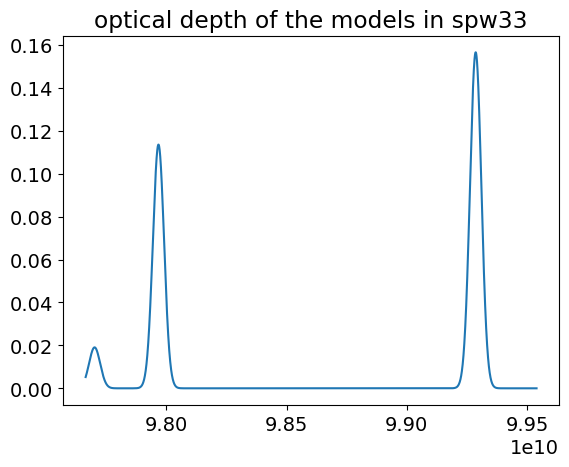

In [471]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                      freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
        lte_molecule.generate_model(spw33.xarr,
                      41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                      freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus)
pl.title("optical depth of the models in spw33")

## Test filling factor limits

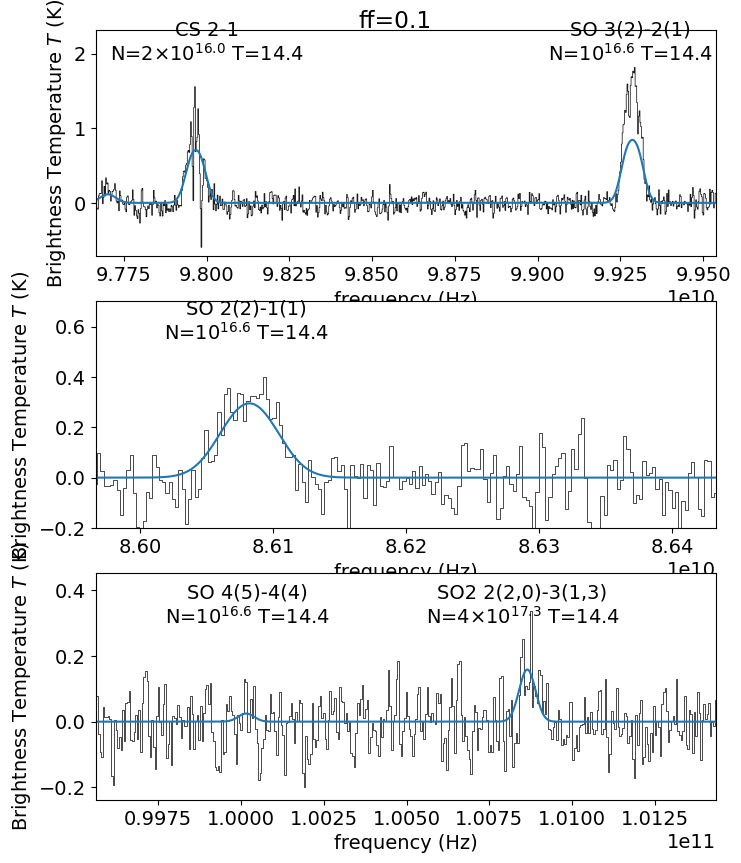

In [409]:
tex = 14.4 * u.K
ff = 0.1
column_SO = 10**15.6*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = 5e15/16*u.cm**-2 / ff
column_CS = 1e15*u.cm**-2 / ff

sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             ) * ff
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) * ff
pl.figure(figsize=(8, 10))
spw33sm.plotter(axis=pl.subplot(3,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
pl.text(98.0e9, 1.9, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(99.28e9, 1.9, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter(axis=pl.subplot(3,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw25sm.plotter.axis.set_ylim(-0.2, 0.7)

sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs_SO, aij=aij_SO, deg=deg_SO, EU=EU_SO, partfunc=partfunc_SO) +
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
spw35sm.plotter(axis=pl.subplot(3,1,3))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)
pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
pl.suptitle(y=0.9, t=f"ff={ff}");

## CH3SH search in spw35

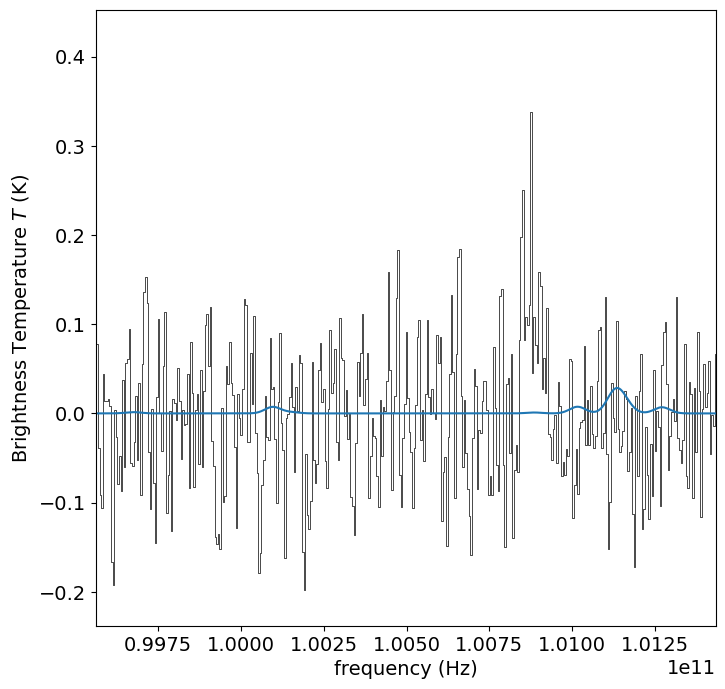

In [410]:
tex = 20 * u.K
column_CH3SH = 2e14*u.cm**-2
sospw35mod = (
              lte_molecule.generate_model(spw35.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CH3SH,
                            freqs=freqs_CH3SH, aij=aij_CH3SH, deg=deg_CH3SH, EU=EU_CH3SH, partfunc=partfunc_CH3SH) 
             )
pl.figure(figsize=(8, 8))
spw35sm.plotter(axis=pl.subplot(1,1,1))
spw35sm.plotter.axis.plot(spw35.xarr.value, sospw35mod)

## Demonstrate temperature limits from SO

Text(0.5, 0.98, 'T=60K is inconsistent with the SO line ratio')

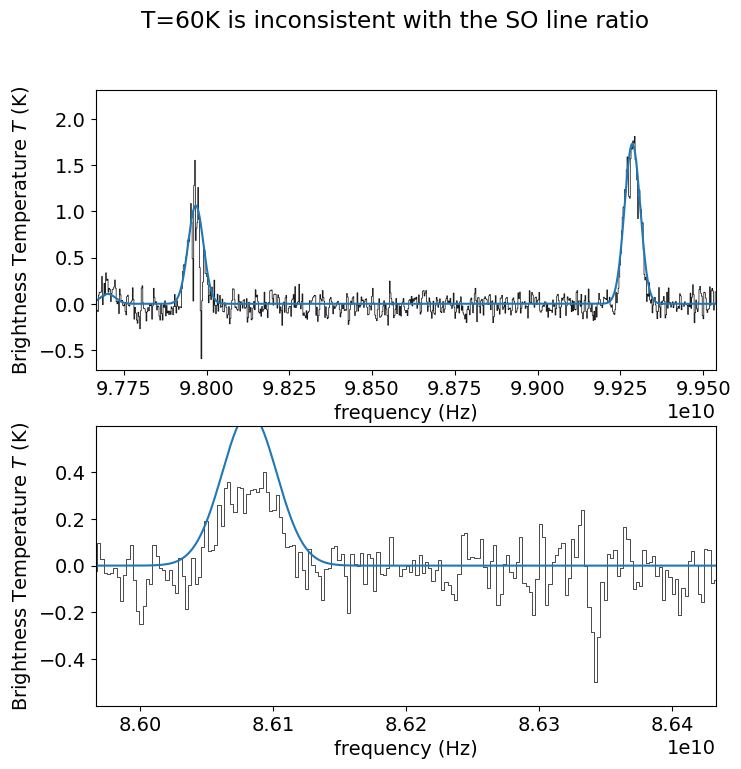

In [411]:
tex = 60 * u.K
column_SO = 1.4e16*u.cm**-2
column_CS = 2.5e15*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=60K is inconsistent with the SO line ratio")

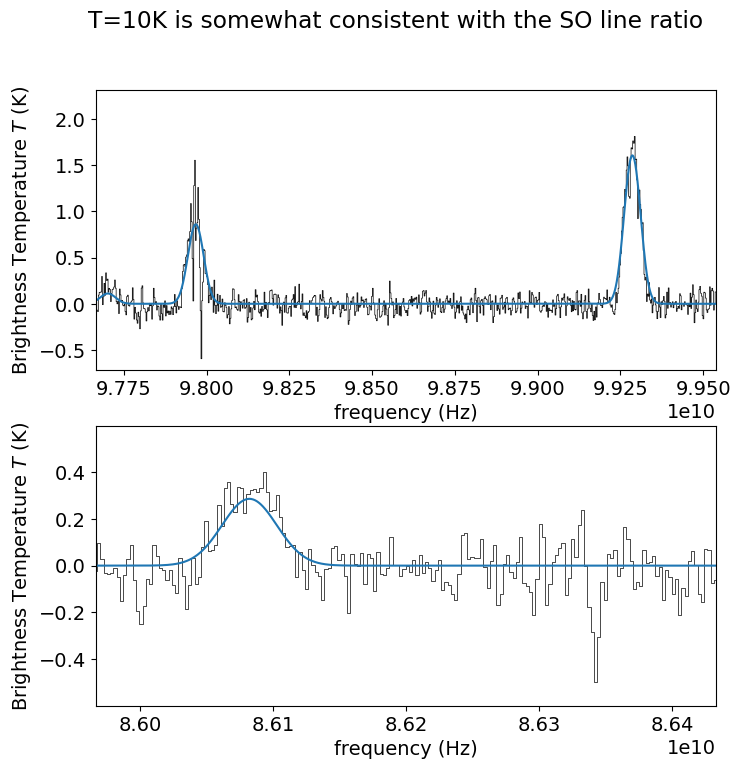

In [412]:
tex = 10 * u.K
column_SO = 50*8e13*u.cm**-2
column_CS = 50*1.5e13*u.cm**-2
column_34SO = column_SO/16
sospw33mod = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS)
             )
sospw25mod = lte_molecule.generate_model(spw25.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc)
pl.figure(figsize=(8, 8))
spw33sm.plotter(axis=pl.subplot(2,1,1))
spw33sm.plotter.axis.plot(spw33.xarr.value, sospw33mod)
spw25sm.plotter(axis=pl.subplot(2,1,2))
spw25sm.plotter.axis.plot(spw25.xarr.value, sospw25mod)
pl.suptitle("T=10K is somewhat consistent with the SO line ratio");

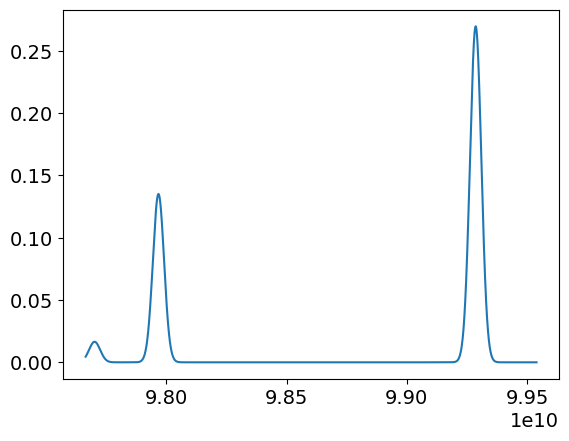

In [413]:
taus = (lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO, get_tau=True) + 
              lte_molecule.generate_model(spw33.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS, get_tau=True))
pl.plot(spw33.xarr, taus);

# splatalogue: check for a line at th ebottom of spw33?

In [218]:
Splatalogue.query_lines(97.7095 *u.GHz, 97.8 * u.GHz, energy_max=50, energy_type='eu_k',)['Species',
  'Chemical Name', 'Freq-GHz(rest frame,redshifted)', 'E_U (K)', 'Resolved QNs', ].pprint(max_lines=500)

      Species                   Chemical Name             Freq-GHz(rest frame,redshifted) E_U (K)            Resolved QNs         
------------------- ------------------------------------- ------------------------------- -------- -------------------------------
gGG'g-CH2OHCH2CH2OH                1,3-propanediol, gGG'g                              -- 33.07617          13(4,10)-12(3,9),v=0-0
gGG'g-CH2OHCH2CH2OH                1,3-propanediol, gGG'g                              -- 33.07804          13(4,10)-12(3,9),v=1-1
    CH3CHNH2COOH-II                       &alpha;-Alanine                      97.7109153 21.75558                 11(6,5)-10(4,6)
      CH3SD,vt&le;2                      Methyl mercaptan                      97.7117803 12.04928           4(0,4)--3(0,3)-E,vt=0
gGG'g-CH2OHCH2CH2OH                1,3-propanediol, gGG'g                              -- 42.06122         16(1,15)-15(1,14),v=0-1
CH3O13CHO(TopModel)                        Methyl Formate                       97.

# Orbital velocity check
For a Keplerian orbit with width = 71 km/s, where could it be...?

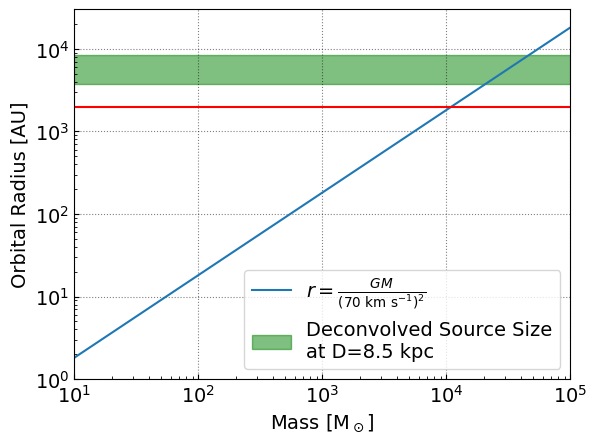

In [701]:
mass = np.geomspace(0.1, 1e5)*u.M_sun
#pl.title("Source size is roughly 1 arcsec ~ 8500 AU")
pl.loglog(mass, (constants.G * mass / (70*u.km/u.s)**2).to(u.au), label=r'$r = \frac{G M}{(70 \mathrm{~km~s}^{-1})^2}$')
pl.xlabel("Mass [M$_\odot$]")
pl.ylabel("Orbital Radius [AU]")
pl.axhline(2000, color='r')
#pl.axhline(8500);
#pl.axvline(1e4);
pl.grid(linestyle=':', color='k', zorder=-5, alpha=0.5)
xx = pl.xlim()
pl.fill_between(xx, 0.44*8500, 0.99*8500, alpha=0.5, color='g', label='Deconvolved Source Size\nat D=8.5 kpc');
pl.axis([10, 1e5, 1, 3e4])
pl.legend(loc='lower right');
pl.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/GMovervsquared.pdf", bbox_inches='tight')

### Temperature Model

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$

In [704]:
alpha = 0.001
sigma = 2.8e24*u.Da/u.cm**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*1e4*u.au))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose()

<Quantity 0.50141277 K>

In [ ]:
# What if we say it's 2000 AU?

In [708]:
alpha = 0.001
radius = 2e3*u.au
# our total mass has to be concentrated into a smaller volume
sigma = 2.8e24*u.Da/u.cm**2 * (1e4*u.au/radius)**2 # see 'how much mass?' below
kappa = 3*u.cm**2/u.g # this is the Planck mean opacity for a TTau disk, from Krumholz text
omega = (70*u.km/u.s / (2*np.pi*radius))
midplane_temperature = (27*alpha*constants.k_B*sigma**2 * kappa * omega / (64 * 2.37*u.Da * constants.sigma_sb))**(1/3)
midplane_temperature.decompose(), sigma

(<Quantity 7.33069913 K>, <Quantity 7.e+25 u / cm2>)

$$T_m = \left[\frac{27  \alpha k_B  \Sigma^2 \kappa \Omega}{64 m \sigma_{SB}}\right]^{1/3} $$
$$T_m = 7.3 \mathrm{~K~}
        \left[\frac{M}{50 \mathrm{M}_\odot}\right]^{2/3}
        \left[\frac{\kappa}{3 \mathrm{cm^2~g^{-1}}}\right]^{1/3}
        \left[\frac{\alpha}{10^{-3}}\right]^{1/3}
        \left[\frac{r}{2000 \mathrm{AU}}\right]^{-4/3}
        $$

# Overplot all the lines (to show nondetections)

In [220]:
import aces
linetb = Table.read(f'{aces.conf.basepath}/reduction_ACES/aces/data/tables/linelist.csv')
linetb.sort('col9')
spw_inds = {25: 0, 27:1, 29:2, 31:3, 33:4, 35: 5}
linetb[:3]

<Table length=3>
Band Name TP SPW 7m SPW 12m SPW  Center Bandwidth F_Lower F_Upper  F_Resolution col9         Line        Rest (GHz) V_Lower V_Upper  V_Res.   _1       References    
  str10   int64  int64   int64  float64  float64  float64 float64    float64    str3        str27         float64   float64 float64 float64 int64        str30       
--------- ------ ------ ------- ------- --------- ------- -------- ------------ ---- ------------------- ---------- ------- ------- ------- ----- -------------------
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    *  CH3SH  4(0)–3(0) E  101.13965      --      --    2.89    -- Jones et al. (2008)
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    *  CH3SH  4(0)–3(0) A  101.13916      --      --    2.89    -- Jones et al. (2008)
   Cont 2     27     26      35   100.5     1.875 99.5625 101.4375  0.000976563    * NH2CN 5(1,4)-4(1,3)   100.6295      --      --    2.91    -- Jones et al. (2008)

In [833]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    all_spectra = {}
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            scube = (scubes[spw_inds[row['12m SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            all_spectra[row['Line']] = sp
            print(row['Line'], end=', ')

HN13C 1-0, H13CO+ 1-0, H40 Alpha, SiO 2-1, CH3C3N, H13CN 1-0, SiO 2-1 v=1 maser, SO 3(2)-2(1), HNCO 4-3, CS 2-1, HC3N 11-10, HCO+ 1-0, SO 4(5)-4(4), SO2 2(2,0)-3(1,3), SO 2(2)-1(1), CCS 7(6)-6(5), SO2 7(3,5)–8(2,6), 34SO  3(2)–2(1), 33SO, 

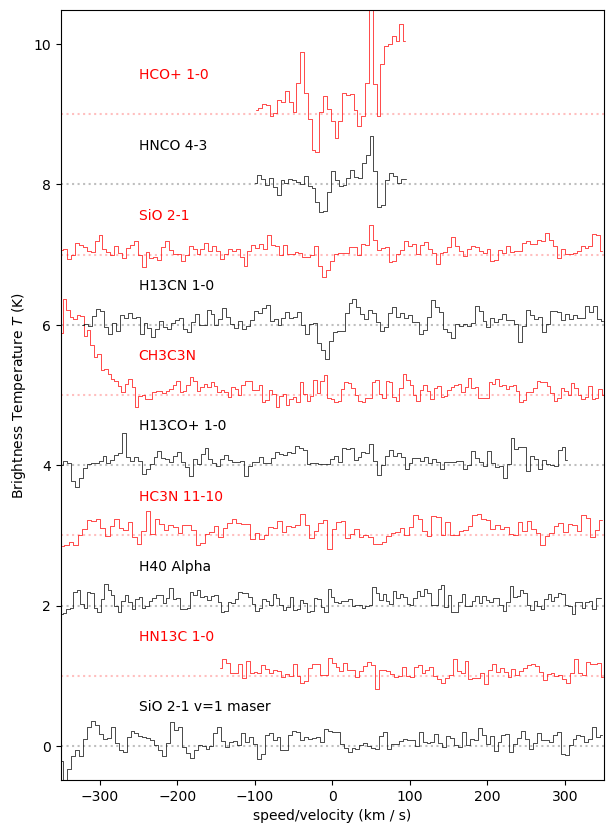

In [834]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k)]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays.pdf", bbox_inches='tight')

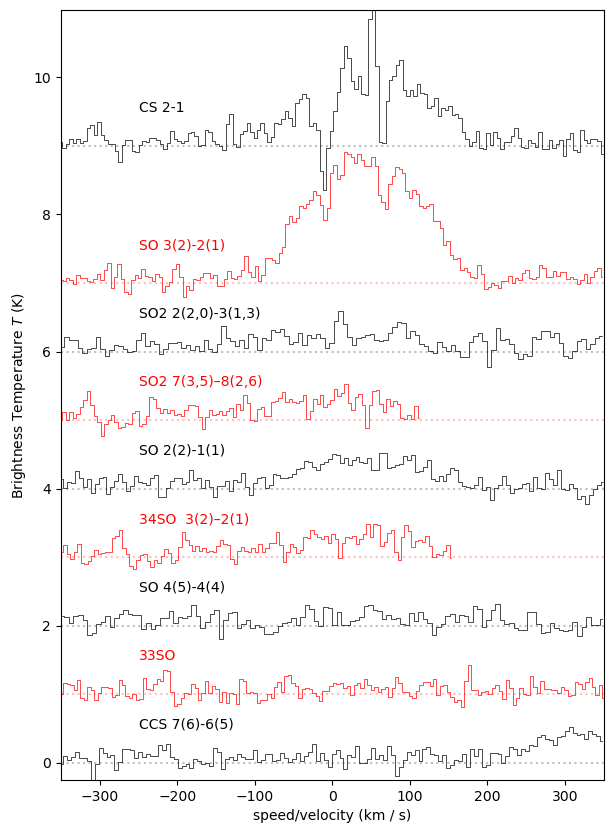

In [835]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays.pdf", bbox_inches='tight')

#### with TP

In [836]:
spw_inds_tp = {17: 0, 19: 1, 21: 2, 23: 3, 25: 4, 27: 5}

In [837]:
all_spectra_tp = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in linetb:
        if row['col9'] in ('**', '***') or 'SO' in row['Line'] or 'CCS' in row['Line']:
            scube = (tpcubes[spw_inds_tp[row['TP SPW']]]
                     .with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Rest (GHz)']*u.GHz)
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                    )
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            #smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            #sp.smooth(smfac, downsample=True)
            all_spectra_tp[row['Line']] = sp
            print(row['Line'], end=', ')

HN13C 1-0, H13CO+ 1-0, H40 Alpha, SiO 2-1, CH3C3N, H13CN 1-0, SiO 2-1 v=1 maser, SO 3(2)-2(1), HNCO 4-3, CS 2-1, HC3N 11-10, HCO+ 1-0, SO 4(5)-4(4), SO2 2(2,0)-3(1,3), SO 2(2)-1(1), CCS 7(6)-6(5), SO2 7(3,5)–8(2,6), 34SO  3(2)–2(1), 33SO, 

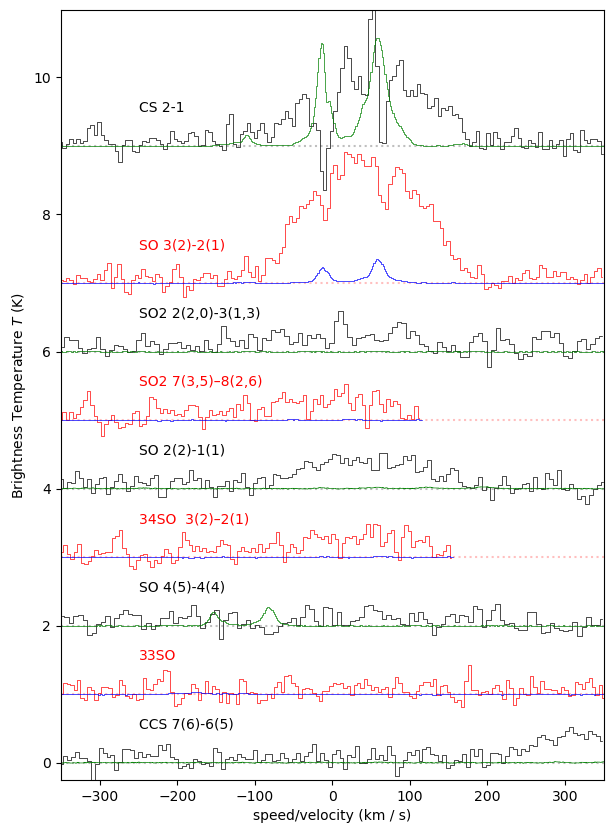

In [838]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    #ax.text(-250, offset + 0.5, linename, color='b' if ii%2 == 1 else 'g')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CSandSO_Overlays_withTP.pdf", bbox_inches='tight')

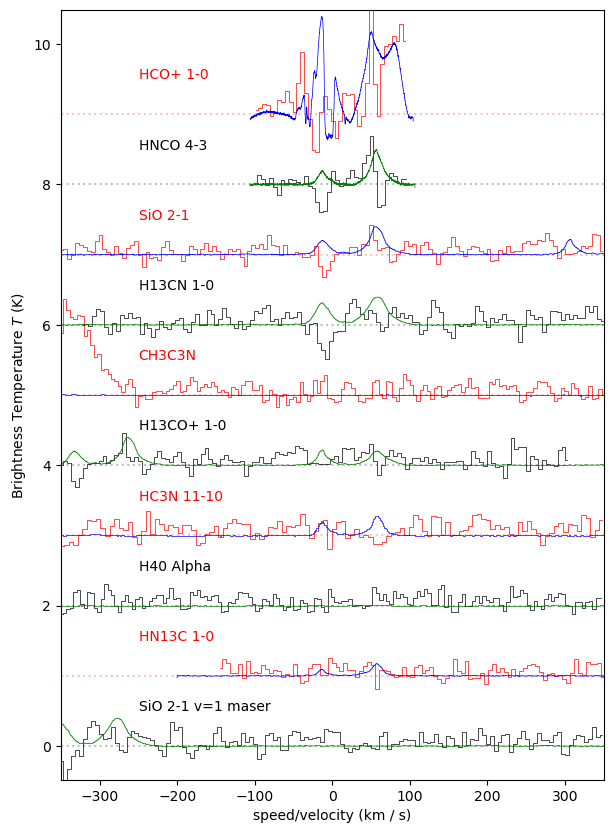

In [853]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra, key=lambda x: all_spectra[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
order = [k for k in order if not('CS' in k or 'SO' in k)]

for ii, linename in enumerate(order):
    sp = all_spectra[linename]
    offset = 1 * ii + 1*('CS' in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

    sp = all_spectra_tp[linename]
    offset = 1 * ii + 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='b' if ii%2 == 1 else 'g')
    #sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='b' if ii%2 == 1 else 'g') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/NonDetection_Overlays_withTP.pdf", bbox_inches='tight')

## Do the same for Betsy's data

In [224]:
ls /orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*image.pbcor -d

/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15.mfs.I.manual.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud_sci.spw0_4_8_12.cube.I.manual.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud.spw0.contsub.cube.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/50_kms_cloud.spw1.cube.image.pbcor/
/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/

In [225]:
fns_2017 = glob.glob("/orange/adamginsburg/ACES/ancillary/data/2017.1.01185.S/science_goal.uid___A001_X12a3_Xe7/group.uid___A001_X12a3_Xe8/member.uid___A001_X12a3_Xe9/calibrated/*cube*image.pbcor")
scubes2017 = [SpectralCube.read(fn, format='casa_image').subcube_from_regions([region]) for fn in fns_2017]

divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars
divide by zero encountered in long_scalars


In [226]:
scubes2017[1].find_lines(chemical_name=' SO ')

<Table length=6>
   Species     Chemical Name  Freq-GHz(rest frame,redshifted) Freq Err(rest frame,redshifted) Meas Freq-GHz(rest frame,redshifted) Meas Freq Err(rest frame,redshifted) ... E_L (cm^-1) E_L (K)  E_U (cm^-1) E_U (K)  Linelist
    str13          str15                  float64                         float64                           float64                              float64                ...   float64   float64    float64   float64    str5  
------------- --------------- ------------------------------- ------------------------------- ------------------------------------ ------------------------------------ ... ----------- -------- ----------- -------- --------
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                           344.310612                                7e-05 ...     49.3181 70.95734    60.80307 87.48155     CDMS
SO3&Sigma;v=0 Sulfur Monoxide                              --                              --                           344.310612                                7e-05 ...     49.3181 70.95734    60.80307 87.48155      JPL
SO3&Sigma;v=0 Sulfur Monoxide                      344.310792                         1.6e-05                                   --                                   -- ...         0.0      0.0         0.0      0.0    Lovas
SO3&Sigma;v=0 Sulfur Monoxide                      344.310792                         1.6e-05                            344.31061                                5e-06 ...      49.318 70.95719    60.80297 87.48141    SLAIM
SO3&Sigma;v=0 Sulfur Monoxide                     345.7044744                        2.38e-05                                   --                                   -- ...      3.0999  4.46004    14.63136 21.05114     CDMS
SO3&Sigma;v=0 Sulfur Monoxide                     345.7045553                        3.68e-05                                   --                                   -- ...      3.0999  4.46004    14.63136 21.05115      JPL

In [266]:
b7beam = scubes2017[0].beam
b7beam

Beam: BMAJ=4.741114054051525 arcsec BMIN=2.600191448624252 arcsec BPA=-85.31893012166081 deg

In [227]:
from astropy import table

In [228]:
tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
        for cu in scubes2017 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
tabs = [minimize_table(t) for t in tabs if len(t) > 0]
b7linetable = table.vstack(tabs)
b7linetable

<Table length=15>
   Species       ChemicalName           QNs            Freq    log10_Aij   EU_K  
    str13           str18              str17         float64    float64  float64 
------------- ------------------ ----------------- ----------- --------- --------
SO3&Sigma;v=0    Sulfur Monoxide         8(8)-7(7)  344.310612  -3.28519 87.48155
SO3&Sigma;v=0    Sulfur Monoxide         2(3)-2(1) 345.7044744  -6.85707 21.05114
        COv=0    Carbon Monoxide               3-2 345.7959899  -5.60266 33.19169
       SO2v=0     Sulfur dioxide     5(5,1)-6(4,2) 345.1489708  -5.00825 75.14405
       SO2v=0     Sulfur dioxide 13(2,12)-12(1,11) 345.3385377  -3.62327 92.98367
         34SO    Sulfur Monoxide         6(7)-7(6) 356.8686927  -6.46219 63.83839
       SO2v=0     Sulfur dioxide   10(4,6)-10(3,7) 356.7551899  -3.48406 89.83365
       SO2v=0     Sulfur dioxide   11(4,8)-11(3,9) 357.3875795  -3.47077 99.95222
       SO2v=0     Sulfur dioxide     8(4,4)-8(3,5) 357.5814486   -3.5149 72.36335
       SO2v=0     Sulfur dioxide     9(4,6)-9(3,7) 357.6718206  -3.49542 80.63687
       SO2v=0     Sulfur dioxide     7(4,4)-7(3,5) 357.8924422  -3.54142 65.01106
       SO2v=0     Sulfur dioxide     6(4,2)-6(3,3) 357.9258478  -3.58445 58.57964
         34SO    Sulfur Monoxide         2(3)-2(1) 343.8511297  -6.85945 20.90551
        CSv=0 Carbon Monosulfide               7-6 342.8828503  -3.07737 65.82732
        CSv=0 Carbon Monosulfide               7-6 342.8828503  -3.07737 65.82732

In [841]:
all_spectra_b7 = {}
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b7linetable:
        for cube in scubes2017:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            line = f"{row['Species']} {row['QNs']}"
            all_spectra_b7[line] = sp
            print(line, end=', ')

SO3&Sigma;v=0 8(8)-7(7), SO3&Sigma;v=0 8(8)-7(7), SO3&Sigma;v=0 2(3)-2(1), COv=0 3-2, SO2v=0 5(5,1)-6(4,2), SO2v=0 13(2,12)-12(1,11), 34SO 6(7)-7(6), SO2v=0 10(4,6)-10(3,7), SO2v=0 11(4,8)-11(3,9), SO2v=0 8(4,4)-8(3,5), SO2v=0 9(4,6)-9(3,7), SO2v=0 7(4,4)-7(3,5), SO2v=0 6(4,2)-6(3,3), 34SO 2(3)-2(1), 34SO 2(3)-2(1), CSv=0 7-6, CSv=0 7-6, 

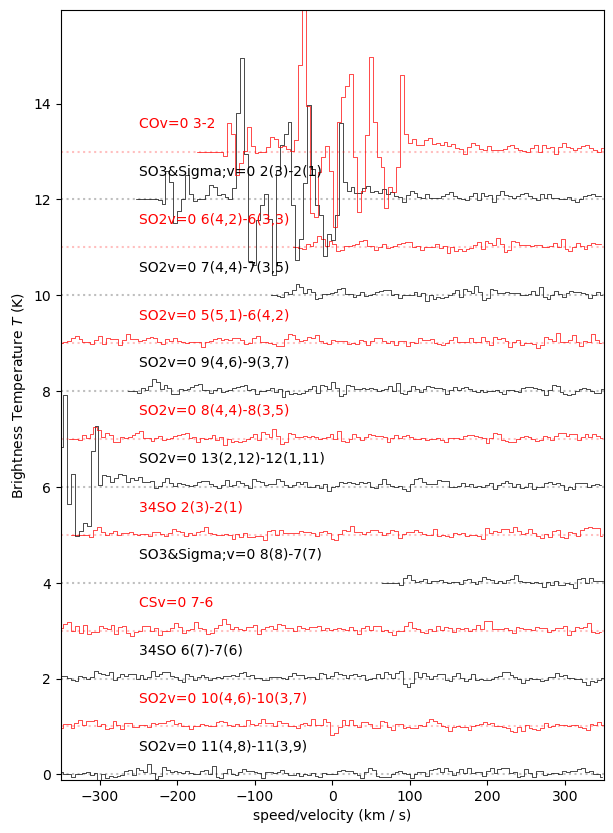

In [842]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b7, key=lambda x: all_spectra_b7[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra_b7[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B7_spectra_overlays.pdf", bbox_inches='tight')

## Do the same for Tsuboi's data

In [741]:
ls /orange/adamginsburg/ACES/ancillary/data/2012.1.00080.S/science_goal.uid___A002_X6444ba_Xc/group.uid___A002_X6444ba_Xd/member.uid___A002_X6444ba_Xe/calibrated/workdir/

GC50MC_spw0_cube.image/            GC50MC_spw0_cube.psf.fits
GC50MC_spw0_cube.image.fits        GC50MC_spw0_cube.residual/
GC50MC_spw0_cube.image.pbcor/      GC50MC_spw0_cube.residual.fits
GC50MC_spw0_cube.image.pbcor.fits  GC50MC_spw0_cube.weight/
GC50MC_spw0_cube.mask/             GC50MC_spw0_cube.weight.fits
GC50MC_spw0_cube.mask.fits         GC50MC_spw1_cube.image.fits
GC50MC_spw0_cube.model/            GC50MC_spw1_cube.image.pbcor.fits
GC50MC_spw0_cube.model.fits        GC50MC_spw2_cube.image.fits
GC50MC_spw0_cube.pb/               GC50MC_spw2_cube.image.pbcor.fits
GC50MC_spw0_cube.pb.fits           GC50MC_spw3_cube.image.fits
GC50MC_spw0_cube.psf/              GC50MC_spw3_cube.image.pbcor.fits


<Quantity 70.34205249 km / s>

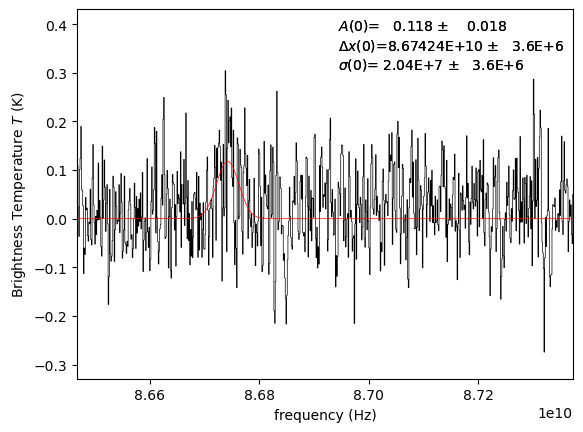

In [742]:
# H13CO+
sch13cop = [c for c in scubes2012 if c.spectral_axis.min() < nurest_h13cop and c.spectral_axis.max() > nurest_h13cop][0]
pxcrd = sch13cop.wcs.celestial.world_to_pixel(coord)
x, y = pxcrd
sp = pyspeckit.Spectrum.from_hdu(sch13cop[:, int(y), int(x)].to(u.K).hdu)
sp.smooth(5)
sp.plotter()
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
sp.specfit(guesses=[0.2, 86.73e9, 7e7, ])
(sp.specfit.parinfo['WIDTH0'].value / sp.specfit.parinfo['SHIFT0'].value * constants.c).to(u.km/u.s)

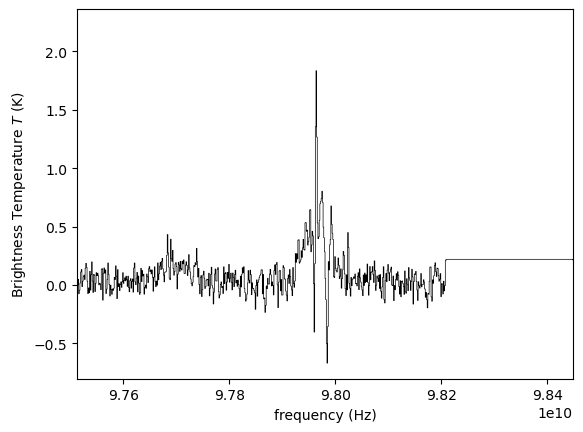

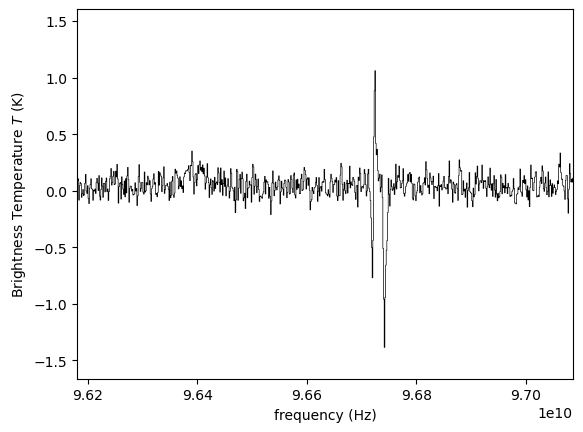

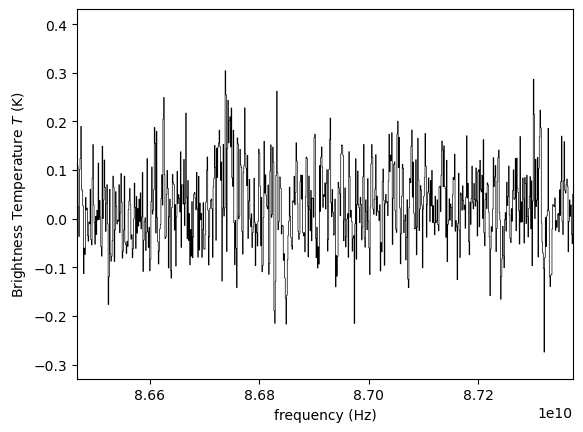

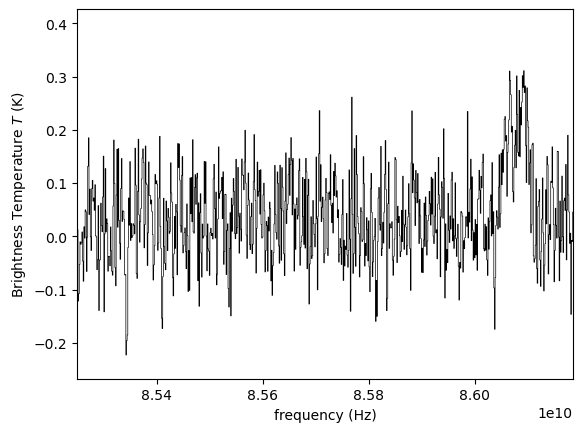

In [743]:
for scube in scubes2012:
    pxcrd = scube.wcs.celestial.world_to_pixel(coord)
    x, y = pxcrd
    sp = pyspeckit.Spectrum.from_hdu(scube[:, int(y), int(x)].to(u.K).hdu)
    sp.smooth(5)
    sp.plotter(figure=pl.figure())

In [744]:
from astropy import table

In [745]:
tabs = [cu.find_lines(chemical_name=cn, line_lists=['CDMS'], energy_max=100, energy_type='eu_k')
        for cu in scubes2012 for cn in (' 34SO ', ' SO ', ' CO ', ' CS ', 'Carbon Monosulfide', ' SO2 ', ' SiO ', ' SiS ')]
tabs = [minimize_table(t) for t in tabs if len(t) > 0]
b3linetable = table.vstack(tabs)
b3linetable

<Table length=10>
   Species       ChemicalName         QNs         Freq    log10_Aij   EU_K  
    str13           str18            str13      float64    float64  float64 
------------- ------------------ ------------- ---------- --------- --------
         34SO    Sulfur Monoxide     3(2)-2(1)  97.715317  -4.96948  9.09292
        CSv=0 Carbon Monosulfide           2-1 97.9809533  -4.77628  7.05355
        CSv=0 Carbon Monosulfide           2-1 97.9809533  -4.77628  7.05355
       SO2v=0     Sulfur dioxide 7(3,5)-8(2,6) 97.7023335  -5.74124 47.83503
         34SO    Sulfur Monoxide     4(5)-4(4)   96.78176  -6.00614 38.05571
      C34Sv=0 Carbon Monosulfide           2-1 96.4129495  -4.79698  6.24804
       SO2v=0     Sulfur dioxide 8(3,5)-9(2,8) 86.6390877  -5.87204  55.2022
       SiOv=0   Silicon Monoxide           2-1   86.84696  -4.53354  6.25203
       SiOv=0   Silicon Monoxide           2-1   86.84696  -4.53354  6.25203
SO3&Sigma;v=0    Sulfur Monoxide     2(2)-1(1)   86.09395  -5.27985 19.31372

In [843]:
all_spectra_b3 = {}
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for row in b3linetable:
        for cube in scubes2012:
            scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=row['Freq']*u.GHz)
                         .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                         .to(u.K)
                         )
            if len(scube) <= 2:
                continue
            xx, yy = scube.wcs.celestial.world_to_pixel(coord)
            sp_ = scube[:, int(yy), int(xx)]
            sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
            smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
            sp.smooth(smfac, downsample=True)
            line = f"{row['Species']} {row['QNs']}"
            all_spectra_b3[line] = sp
            print(line, end=', ')

34SO 3(2)-2(1), CSv=0 2-1, CSv=0 2-1, SO2v=0 7(3,5)-8(2,6), 34SO 4(5)-4(4), C34Sv=0 2-1, SO2v=0 8(3,5)-9(2,8), SiOv=0 2-1, SiOv=0 2-1, SO3&Sigma;v=0 2(2)-1(1), 

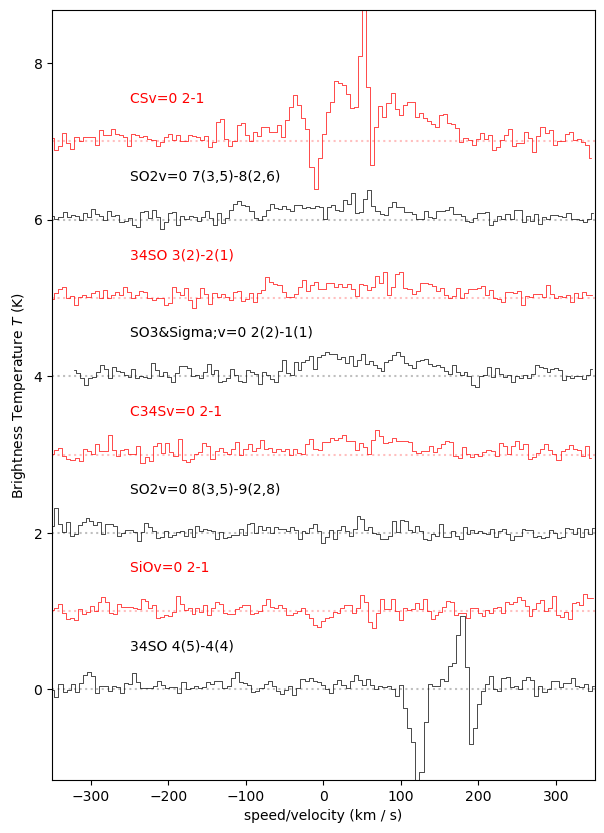

In [844]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

order = sorted(all_spectra_b3, key=lambda x: all_spectra_b3[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(order):
    sp = all_spectra_b3[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/B3Tsuboi_spectra_overlays.pdf", bbox_inches='tight')

### Tsuboi's w/model

In [421]:
scubes2012

[VaryingResolutionSpectralCube with shape=(3840, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3840  type_s: FREQ      unit_s: Hz     range: 97512362524.760 Hz:98449559739.802 Hz,
 VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3712  type_s: FREQ      unit_s: Hz     range: 96180400540.670 Hz:97086349711.145 Hz,
 VaryingResolutionSpectralCube with shape=(3712, 60, 60) and unit=Jy / beam:
  n_x:     60  type_x: RA---SIN  unit_x: deg    range:   266.488324 deg:  266.493008 deg
  n_y:     60  type_y: DEC--SIN  unit_y: deg    range:   -28.955044 deg:  -28.950946 deg
  n_s:   3712  type_s: FREQ      unit_s: Hz    

In [845]:
cube = scubes2012[0]
xx, yy = cube.wcs.celestial.world_to_pixel(coord)
spw98GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[0][:, int(yy), int(xx)].to(u.K).hdu)
spw96GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[1][:, int(yy), int(xx)].to(u.K).hdu)
spw86GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[2][:, int(yy), int(xx)].to(u.K).hdu)
spw85GHz_2012 = pyspeckit.Spectrum.from_hdu(scubes2012[3][:, int(yy), int(xx)].to(u.K).hdu)
spw98GHz_2012sm = spw98GHz_2012.copy()
spw96GHz_2012sm = spw96GHz_2012.copy()
spw86GHz_2012sm = spw86GHz_2012.copy()
spw85GHz_2012sm = spw85GHz_2012.copy()
spw98GHz_2012sm.smooth(5)
spw96GHz_2012sm.smooth(5)
spw86GHz_2012sm.smooth(5)
spw85GHz_2012sm.smooth(5)

In [846]:
rslt.logcolumn, rslt.tem

(Parameter('logcolumn', value=32.6460639560455),
 Parameter('tem', value=13.413666368478856))

In [847]:
np.log10(np.exp(rslt.logcolumn))

14.178005431971204

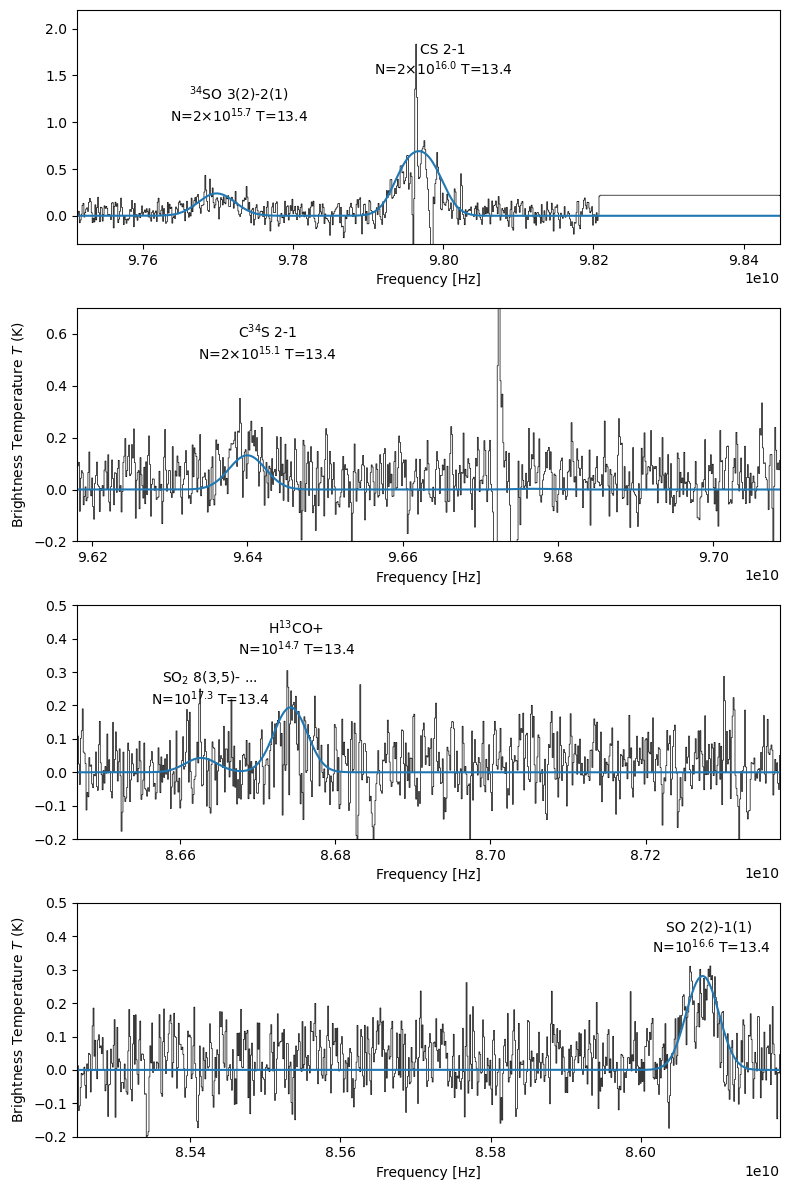

In [848]:
tex = 14.4 * u.K
tex = rslt.tem.value * u.K
ff = 0.1
column_SO = np.exp(rslt.logcolumn)*partfunc_SO(rslt.tem)*u.cm**-2 / ff
column_SO2 = 2e16*u.cm**-2 / ff
column_34SO = column_SO/8*u.cm**-2 
column_CS = 1e15*u.cm**-2 / ff
column_C34S = column_CS / 8
column_H13COp = 5e13*u.cm**-2 / ff

spw98GHz_2012.xarr.convert_to_unit(u.Hz)
spw96GHz_2012.xarr.convert_to_unit(u.Hz)
spw86GHz_2012.xarr.convert_to_unit(u.Hz)
spw98GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw96GHz_2012sm.xarr.convert_to_unit(u.Hz)
spw86GHz_2012sm.xarr.convert_to_unit(u.Hz)

sospw98GHz_2012mod = (lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw98GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw96GHz_2012mod = (lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw96GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw86GHz_2012mod = (lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw86GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
sospw85GHz_2012mod = (lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO,
                            freqs=freqs, aij=aij, deg=deg, EU=EU, partfunc=partfunc) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_34SO,
                            freqs=freqs_34SO, aij=aij_34SO, deg=deg_34SO, EU=EU_34SO, partfunc=partfunc_34SO) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_CS,
                            freqs=freqs_CS, aij=aij_CS, deg=deg_CS, EU=EU_CS, partfunc=partfunc_CS) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_C34S,
                            freqs=freqs_C34S, aij=aij_C34S, deg=deg_C34S, EU=EU_C34S, partfunc=partfunc_C34S) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_H13COp,
                            freqs=freqs_H13COp, aij=aij_H13COp, deg=deg_H13COp, EU=EU_H13COp, partfunc=partfunc_H13COp) + 
              lte_molecule.generate_model(spw85GHz_2012.xarr,
                            41*u.km/u.s, 71*u.km/u.s, tex=tex, column=column_SO2,
                            freqs=freqs_SO2, aij=aij_SO2, deg=deg_SO2, EU=EU_SO2, partfunc=partfunc_SO2) 
             ) * ff
pl.figure(figsize=(8, 12))
spw98GHz_2012sm.plotter(axis=pl.subplot(4,1,1))
spw98GHz_2012sm.plotter.axis.plot(spw98GHz_2012.xarr.value, sospw98GHz_2012mod)
pl.text(98.0e9, 1.5, f"CS 2-1\nN=2$\\times10^{{{np.log10(column_CS.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(97.715317e9*(1+40/3e5), 1.0, f"$^{{34}}$SO 3(2)-2(1)\nN=2$\\times10^{{{np.log10(column_34SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.ylim(-0.3, 2.2)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

#pl.text(99.28e9, 1.9, f"SO 3(2)-2(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
spw96GHz_2012sm.plotter(axis=pl.subplot(4,1,2))
spw96GHz_2012sm.plotter.axis.plot(spw96GHz_2012.xarr.value, sospw96GHz_2012mod)
spw96GHz_2012sm.plotter.axis.set_ylim(-0.2, 0.7)
pl.text(nurest_c34s21.to(u.Hz).value*(1+40/3e5), 0.5, f"C$^{{34}}$S 2-1\nN=2$\\times10^{{{np.log10(column_C34S.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

spw86GHz_2012sm.plotter(axis=pl.subplot(4,1,3))
spw86GHz_2012sm.plotter.axis.plot(spw86GHz_2012.xarr.value, sospw86GHz_2012mod)
pl.text(86.6390877e9, 0.2, f"SO$_2$ 8(3,5)- ... \nN=10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.text(86.75e9, 0.35, f"H$^{{13}}$CO+ \nN=10$^{{{np.log10(column_H13COp.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(86.08e9, 0.55, f"SO 2(2)-1(1)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
#pl.text(100.02e9, 0.3, f"SO 4(5)-4(4)\nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.text(100.85e9, 0.3, f"SO2 2(2,0)-3(1,3)\nN=4$\\times$10$^{{{np.log10(column_SO2.value):0.1f}}}$ T={tex.value:0.1f}", ha='center');
#pl.suptitle(y=0.9, t=f"ff={ff}");
pl.ylim(-0.2, 0.5)
pl.xlabel("Frequency [Hz]")
pl.ylabel("")

spw85GHz_2012sm.plotter(axis=pl.subplot(4,1,4))
spw85GHz_2012sm.plotter.axis.plot(spw85GHz_2012.xarr.value, sospw85GHz_2012mod)
pl.ylim(-0.2, 0.5)
pl.text(86.09395e9, 0.35, f"SO 2(2)-1(1) \nN=10$^{{{np.log10(column_SO.value):0.1f}}}$ T={tex.value:0.1f}", ha='center')
pl.xlabel("Frequency [Hz]")

pl.tight_layout()
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/spectra_with_fitted_model_ff0pt1_2012.pdf', bbox_inches='tight')

## CARMA


CARMA's beam is really big, so it's showing the surroundings.  The line profiles somewhat resemble our compact source, but is clearly coming from a broader area. Hrm.

In [786]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fns_carma = [fn for fn in sorted(glob.glob("/orange/adamginsburg/cmz/carma/*fits")) 
                 if 'mom0' not in fn and 'continuum' not in fn]
    scubescarma = [SpectralCube.read(fn, format='fits').subcube_from_regions([region]) for fn in fns_carma]
fns_carma

['/orange/adamginsburg/cmz/carma/combined_HCN.fits',
 '/orange/adamginsburg/cmz/carma/combined_HCO%2b.fits',
 '/orange/adamginsburg/cmz/carma/combined_N2H%2b.fits',
 '/orange/adamginsburg/cmz/carma/combined_SiO.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_CS.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_HCN.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_HCO%2b.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_N2H%2b.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma15_SiO.fits',
 '/orange/adamginsburg/cmz/carma/gc_carma8_20arcsec.fits']

In [854]:
all_spectra_carma = {}
all_spectra_carma_combined = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for fn, cube in zip(fns_carma, scubescarma):
        scube = (cube.with_spectral_unit(u.km/u.s, velocity_convention='radio')
                     .spectral_slab(-350*u.km/u.s, 350*u.km/u.s)
                     .to(u.K)
                     )
        if len(scube) <= 2:
            continue
        xx, yy = scube.wcs.celestial.world_to_pixel(coord)
        sp_ = scube[:, int(yy), int(xx)]
        sp = pyspeckit.Spectrum.from_hdu(sp_.hdu)
        smfac = (5*u.km/u.s / sp.xarr.cdelt()).decompose().value
        sp.smooth(smfac, downsample=True)
        line = fn.split("_")[-1].split(".")[0].replace("%2b", "+")
        if 'combined' in fn:
            all_spectra_carma_combined[line] = sp
        else:
            all_spectra_carma[line] = sp
        print(line, end=', ')

HCN, HCO+, N2H+, SiO, CS, HCN, HCO+, N2H+, SiO, 

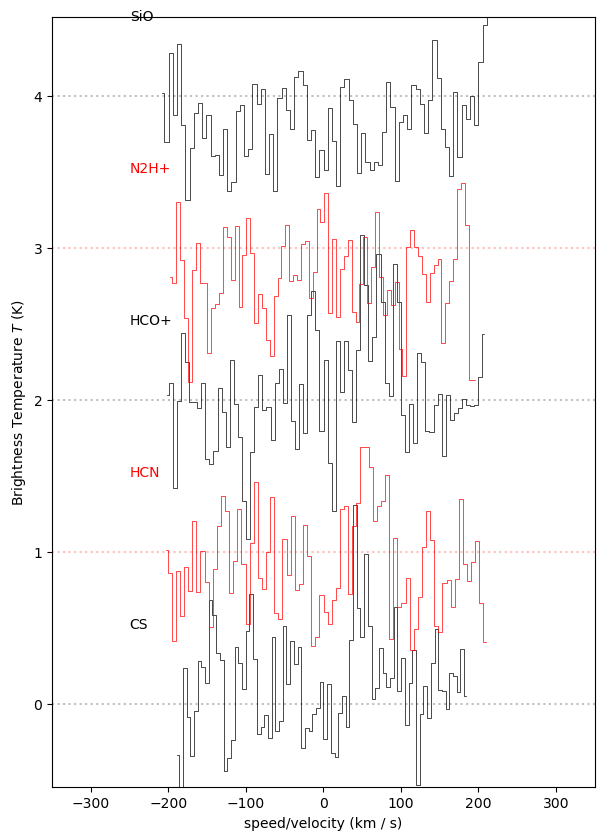

In [855]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma):
    sp = all_spectra_carma[linename]
    offset = 1 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-350, 350);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_spectra_overlays.pdf", bbox_inches='tight')

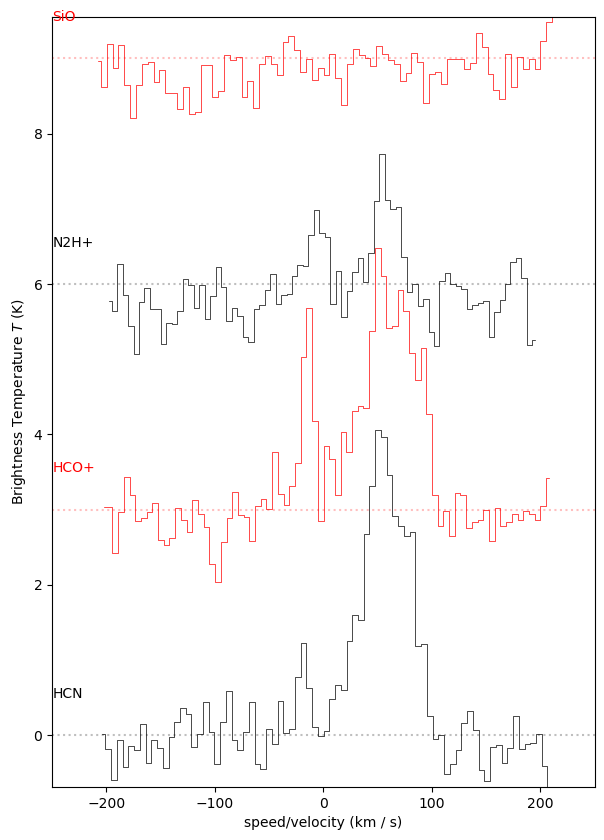

In [856]:
figure = pl.figure(figsize=(7, 10))
ii = 0
ax = figure.gca()
mx = 0
mn = 0

#order = sorted(all_spectra_carma, key=lambda x: all_spectra_carma[x].slice(-100*u.km/u.s, 150*u.km/u.s).data.max())
#order = [k for k in order if 'CS' in k or 'SO' in k]

for ii, linename in enumerate(all_spectra_carma_combined):
    sp = all_spectra_carma_combined[linename]
    offset = 3 * ii #+ 1*('CS' in linename and 'CCS' not in linename) 
    sp.data += offset
    sp.plotter(axis=ax, clear=False, color='r' if ii%2 == 1 else 'k')
    sp.plotter.axis.axhline(offset, linestyle=':', alpha=0.25, color='r' if ii%2 == 1 else 'k') 
    mx = np.max([mx, sp.data.max()])
    mn = np.min([mn, sp.data.min()])
    sp.data -= offset
    ax.text(-250, offset + 0.5, linename, color='r' if ii%2 == 1 else 'k')

ax.set_ylim(mn-0.001, mx+0.001);
ax.set_xlim(-250, 250);
figure.savefig("/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/CARMA_combined_spectra_overlays.pdf", bbox_inches='tight')

# Search for other data

In [241]:
from astroquery.alma import Alma
from astroquery.alma.utils import parse_frequency_support
alma = Alma()

In [242]:
result = alma.query(payload=dict(project_code='2012.1.00080.S'), public=None)
frqsupp_201280 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

<Table length=17>
                    obs_id                        s_resolution     proposal_id       frequency     sensitivity_10kms 
                                                     arcsec                             GHz            mJy / beam    
                    str64                           float64           str64           float64           float64      
---------------------------------------------- ------------------ -------------- ----------------- ------------------
uid://A002/X8981ca/X3.source.J2253+1608.spw.33  63.39784497492764 2012.1.00080.S 97.98187723143462 21.268906889877318
uid://A002/X8981ca/X3.source.J2253+1608.spw.39  63.39784497492764 2012.1.00080.S 85.71214713670295 22.649393986449816
uid://A002/X8981ca/X3.source.J2253+1608.spw.35  63.39784497492764 2012.1.00080.S 97.02475325315575 21.369175216411943
uid://A002/X8981ca/X3.source.J2253+1608.spw.37  63.39784497492764 2012.1.00080.S 86.73265670946229  22.52010325931357
    uid://A002/X8981ca/X5.source.GC50MC.spw.21  63.39674430751842 2012.1.00080.S 86.79992736369624   18.0241315358307
    uid://A002/X8981ca/X5.source.GC50MC.spw.19  63.39674430751842 2012.1.00080.S 96.54156911746472 16.158283657133353
    uid://A002/X8981ca/X5.source.GC50MC.spw.17  63.39674430751842 2012.1.00080.S  97.9809529996788 16.044090684398615
    uid://A002/X8981ca/X5.source.GC50MC.spw.23  63.39674430751842 2012.1.00080.S  85.7002703129451 18.135622459683336
    uid://A002/X6444ba/Xe.source.GC50MC.spw.23 0.5987778630794939 2012.1.00080.S 85.71771313212062  6.490800809659072
    uid://A002/X6444ba/Xe.source.GC50MC.spw.17 0.5987778630794939 2012.1.00080.S 97.98097165693267  6.124005218012061
    uid://A002/X6444ba/Xe.source.GC50MC.spw.19 0.5987778630794939 2012.1.00080.S 96.64909564104646  6.146312079315578
    uid://A002/X6444ba/Xe.source.GC50MC.spw.21 0.5987778630794939 2012.1.00080.S  86.9046904502033    6.4322258240111
   uid://A002/X6444ba/X10.source.GC50MC.spw.22  9.549369472134302 2012.1.00080.S  85.7175361322138  52.83164245979768
   uid://A002/X6444ba/X10.source.GC50MC.spw.16  9.549369472134302 2012.1.00080.S 97.98096985505885 47.954956594579826
   uid://A002/X6444ba/X10.source.GC50MC.spw.18  9.549369472134302 2012.1.00080.S 96.64860569801101  48.50494723849789
    uid://A002/X6444ba/X10.source.GC50MC.spw.5  9.549369472134302 2012.1.00080.S 96.68126878928751  47.01043556525447
   uid://A002/X6444ba/X10.source.GC50MC.spw.20  9.549369472134302 2012.1.00080.S 86.90467467272077  50.83011340056173

In [243]:
result_ACES = alma.query_region(coord, radius=2*u.arcsec, payload=dict(project_code='2021.1.00172.L'), public=None)
frqsupp_ACES = parse_frequency_support(result_ACES['frequency_support'][0])
result_ACES['obs_id', 's_resolution', 'proposal_id', 'frequency', 'sensitivity_10kms']# 'frequency_support']

<Table length=12>
                    obs_id                        s_resolution     proposal_id       frequency      sensitivity_10kms 
                                                     arcsec                             GHz             mJy / beam    
                    str64                           float64           str64           float64            float64      
---------------------------------------------- ------------------ -------------- ------------------ ------------------
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.22 12.377595331115598 2021.1.00172.L  87.92520743221294  48.02897957671701
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.18 12.377595331115598 2021.1.00172.L  86.89921089741469  48.31759267865613
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.16 12.377595331115598 2021.1.00172.L  86.19995010029461 48.616514288765096
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.20 12.377595331115598 2021.1.00172.L  89.18871114209297   47.6972509341387
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.24 12.377595331115598 2021.1.00172.L   98.6021025311493  46.48041755279708
uid://A001/X15a0/X13e.source.Sgr_A_star.spw.26 12.377595331115598 2021.1.00172.L 100.49771651595893  46.55905381055581
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.25 1.2686866083029196 2021.1.00172.L  86.19998076411858  5.654739450682627
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.29 1.2686866083029196 2021.1.00172.L  89.18859357276138  5.491688646624777
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.31 1.2686866083029196 2021.1.00172.L   87.9251758255454  5.552098304049353
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.33 1.2686866083029196 2021.1.00172.L  98.60210469011402  5.188686816683405
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.35 1.2686866083029196 2021.1.00172.L 100.49772710266514   5.16758418551261
uid://A001/X15a0/X13c.source.Sgr_A_star.spw.27 1.2686866083029196 2021.1.00172.L  86.90003817836697 5.6053720505758164

In [244]:
for minfreq, maxfreq in frqsupp_201280:
    qSO = minimize_table(Splatalogue.query_lines(minfreq, maxfreq, chemical_name='Sulfur Monoxide', line_lists=['CDMS']))
    qCS = minimize_table(Splatalogue.query_lines(minfreq, maxfreq, chemical_name='Carbon Monosulfide', line_lists=['CDMS']))
    print(qSO, qCS)

   Species      ChemicalName           QNs             Freq    log10_Aij    EU_K   
------------- --------------- --------------------- ---------- --------- ----------
         33SO Sulfur Monoxide 2(2)-1(1),  F=3/2-1/2 85.1935641  -5.67331   19.27296
         33SO Sulfur Monoxide 2(2)-1(1),  F=5/2-3/2 85.2037348  -5.44795   19.27201
         33SO Sulfur Monoxide 2(2)-1(1),  F=1/2-1/2 85.2068493  -5.37221   19.27359
         33SO Sulfur Monoxide 2(2)-1(1),  F=3/2-3/2 85.2240081  -5.56585   19.27298
         33SO Sulfur Monoxide 2(2)-1(1),  F=1/2-3/2 85.2372933  -6.07086   19.27362
         33SO Sulfur Monoxide 2(2)-1(1),  F=7/2-5/2 85.2379288  -5.29282   19.27091
         33SO Sulfur Monoxide 2(2)-1(1),  F=5/2-5/2 85.2624029  -5.81555   19.27209
         33SO Sulfur Monoxide 2(2)-1(1),  F=3/2-5/2 85.2826761  -6.59336   19.27306
SO3&Sigma;v=1 Sulfur Monoxide             2(2)-1(1)  85.406277  -5.29026 1618.56186
SO3&Sigma;v=0 Sulfur Monoxide             2(2)-1(1)   86.09395  -5.27985   1

In [245]:
result = alma.query(payload=dict(project_code='2017.1.01185.S'), public=None)
frqsupp_20171185 = parse_frequency_support(result['frequency_support'][0])
result['obs_id', 's_resolution', 'proposal_id', 'frequency',]# 'frequency_support']

<Table length=16>
                     obs_id                        s_resolution     proposal_id       frequency     
                                                      arcsec                             GHz        
                     str64                           float64           str64           float64      
----------------------------------------------- ------------------ -------------- ------------------
     uid://A001/X12a3/X109.source.Sgr_B2.spw.18 3.2306945280161865 2017.1.01185.S 356.98775417652155
     uid://A001/X12a3/X109.source.Sgr_B2.spw.20 3.2306945280161865 2017.1.01185.S 343.23823271447424
     uid://A001/X12a3/X109.source.Sgr_B2.spw.22 3.2306945280161865 2017.1.01185.S 344.99735558062855
     uid://A001/X12a3/X109.source.Sgr_B2.spw.16 3.2306945280161865 2017.1.01185.S  355.0399819516899
     uid://A001/X12a3/X101.source.50_kms.spw.22  3.302244777701615 2017.1.01185.S  344.9974662600166
     uid://A001/X12a3/X101.source.50_kms.spw.18  3.302244777701615 2017.1.01185.S  356.9878759775914
     uid://A001/X12a3/X101.source.50_kms.spw.20  3.302244777701615 2017.1.01185.S 343.23834669405403
     uid://A001/X12a3/X101.source.50_kms.spw.16  3.302244777701615 2017.1.01185.S 355.04010365765464
     uid://A001/X12a3/X111.source.Sgr_B2.spw.22 3.3177224315686167 2017.1.01185.S  344.9974255277649
     uid://A001/X12a3/X111.source.Sgr_B2.spw.18 3.3177224315686167 2017.1.01185.S  356.9876722974956
     uid://A001/X12a3/X111.source.Sgr_B2.spw.20 3.3177224315686167 2017.1.01185.S  343.2382383750628
     uid://A001/X12a3/X111.source.Sgr_B2.spw.16 3.3177224315686167 2017.1.01185.S  355.0399247359627
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.22 2.9456661707033307 2017.1.01185.S   344.997455911628
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.18 2.9456661707033307 2017.1.01185.S 356.98786421840634
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.20 2.9456661707033307 2017.1.01185.S 343.23833623583937
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.16 2.9456661707033307 2017.1.01185.S 355.04009270740573

In [246]:
for ii,(minfreq, maxfreq) in enumerate(frqsupp_20171185):
    qSO = minimize_table(Splatalogue.query_lines(minfreq, maxfreq, chemical_name='Sulfur Monoxide', line_lists=['CDMS']))
    qSO2 = minimize_table(Splatalogue.query_lines(minfreq, maxfreq, chemical_name='Sulfur Dioxide', line_lists=['CDMS']))
    qCS = minimize_table(Splatalogue.query_lines(minfreq, maxfreq, chemical_name='Carbon Monosulfide', line_lists=['CDMS']))
    print(ii)
    print(qSO, "\n", qSO2, "\n", qCS)

0
   Species      ChemicalName            QNs               Freq    log10_Aij    EU_K   
------------- --------------- ----------------------- ----------- --------- ----------
         33SO Sulfur Monoxide 9(8)-8(7),  F=19/2-19/2 343.0325429  -5.03799   78.03339
         33SO Sulfur Monoxide 9(8)-8(7),  F=17/2-17/2 343.0417838  -4.86883   78.03125
         33SO Sulfur Monoxide 9(8)-8(7),  F=15/2-15/2 343.0492171  -4.94137   78.02945
         33SO Sulfur Monoxide 9(8)-8(7),  F=15/2-13/2 343.0861019  -3.29162   78.02935
         33SO Sulfur Monoxide 9(8)-8(7),  F=17/2-15/2 343.0872979  -3.29337   78.03127
         33SO Sulfur Monoxide 9(8)-8(7),  F=19/2-17/2  343.088078  -3.28962   78.03347
         33SO Sulfur Monoxide 9(8)-8(7),  F=21/2-19/2 343.0882949  -3.28191   78.03607
SO3&Sigma;v=1 Sulfur Monoxide               9(8)-8(7) 343.8294217  -3.27923 1677.40774
         34SO Sulfur Monoxide               2(3)-2(1) 343.8511297  -6.85945   20.90551 
 Species   ChemicalName                Q

In [247]:
result = alma.query_region(coord, radius=5*u.arcsec, public=None)
result['obs_id', 's_resolution', 'proposal_id', 'frequency', 'frequency_support']

<Table length=29>
                     obs_id                     ...
                                                ...
                     str64                      ...
----------------------------------------------- ...
     uid://A001/X12a3/X101.source.50_kms.spw.18 ...
     uid://A001/X12a3/X101.source.50_kms.spw.20 ...
     uid://A001/X12a3/X101.source.50_kms.spw.16 ...
     uid://A001/X12a3/X101.source.50_kms.spw.22 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.22 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.18 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.20 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.24 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.26 ...
 uid://A001/X15a0/X13e.source.Sgr_A_star.spw.16 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.29 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.31 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.33 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.35 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.27 ...
 uid://A001/X15a0/X13c.source.Sgr_A_star.spw.25 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.18 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.20 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.16 ...
uid://A001/X12a3/Xe9.source.50_kms_cloud.spw.22 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.17 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.19 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.21 ...
     uid://A002/X6444ba/Xe.source.GC50MC.spw.23 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.16 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.18 ...
     uid://A002/X6444ba/X10.source.GC50MC.spw.5 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.20 ...
    uid://A002/X6444ba/X10.source.GC50MC.spw.22 ...

# Continuum Analysis

see [Spectral Index](#Spectral_Index)

Betsy's 2017.1.01185.S gives a flux of 86 mJy at 350.1 GHz

We measure 1.5 mJy at 95 GHz

In [248]:
np.log(86/1.5)/np.log(350.1/95)

3.1041570275998556

Spectral index is 3.1: this is a dust source.

## how much mass?

Assuming X_SO ~ 10^-8, N(SO) ~ 10^16, r=10^4 au (all of these are probably high):

In [739]:
((1e4*u.au)**2 * (1e24*u.cm**-2 * 2.8*u.Da)).to(u.M_sun)

<Quantity 52.33015758 solMass>

In [261]:
import dust_emissivity

In [262]:
dust_emissivity.dust.massofsnu(snu=1.5*u.mJy, nu=95*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 51.1631143 solMass>

In [267]:
dust_emissivity.dust.tauofsnu(snu_per_beam=1.5*u.mJy/b3beam.sr, nu=95*u.GHz, temperature=20*u.K)

<Quantity 0.00377163>

In [270]:
dust_emissivity.dust.massofsnu(snu=u.Quantity(b3r['Amp[Jy]'], u.Jy), nu=102*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 46.66368645 solMass>

In [271]:
dust_emissivity.dust.tauofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K)

<Quantity 0.00389573>

In [272]:
dust_emissivity.dust.massofsnu(snu=90*u.mJy, nu=350*u.GHz, distance=8*u.kpc, temperature=20*u.K)

<Quantity 32.21125363 solMass>

In [273]:
dust_emissivity.dust.tauofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K)

<Quantity 0.00572284>

In [274]:
f"{((50*u.M_sun / (4/3.*np.pi*(5000*u.au)**3) / (2.8*u.Da)).to(u.cm**-3)):0.3e}"

'1.220e+07 1 / cm3'

In [275]:
dust_emissivity.dust.kappa(102*u.GHz)

<Quantity 0.00206053 cm2 / g>

In [277]:
colb7 = dust_emissivity.dust.colofsnu(snu_per_beam=90*u.mJy/b7beam.sr, nu=350*u.GHz, temperature=20*u.K)
colb7

<Quantity 6.85501858e+22 1 / cm2>

In [280]:
colb3 = dust_emissivity.dust.colofsnu(snu_per_beam=u.Quantity(b3r['Amp[Jy]'], u.Jy)/b3beam.sr, nu=102*u.GHz, temperature=20*u.K)
colb3

<Quantity 4.03696404e+23 1 / cm2>

In [279]:
av_to_ak = 0.1
A_K = colb7/(2e21*u.cm**-2) * av_to_ak
A_K

<Quantity 3.42750929>

In [281]:
av_to_ak = 0.1
A_K = colb3/(2e21*u.cm**-2) * av_to_ak
A_K

<Quantity 20.18482019>

In [528]:
column_SO / colb3

<Quantity 9.62902286e-09>

In [529]:
column_CS / colb3

<Quantity 2.47710901e-09>

In [530]:
column_H13COp / colb3

<Quantity 4.95421802e-11>

In [531]:
column_H13CN / colb3

<Quantity 4.95421802e-11>

# Multiwavelength cutout

In [536]:
import importlib as imp
import astroquery
imp.reload(astroquery)
import astroquery.herschel.higal
imp.reload(astroquery.herschel.higal)

<module 'astroquery.herschel.higal' from '/blue/adamginsburg/adamginsburg/repos/astroquery/astroquery/herschel/higal/__init__.py'>

In [546]:
paths.basepath = '/orange/adamginsburg/mgps/mgps/'

In [547]:
%run /orange/adamginsburg/mgps/mgps/analysis/make_sed_cutout_image.py

Retrieving MAGPIS data for 00.025_-0.073 (266.491 -28.953 icrs)
Retrieving HiGal data for 00.025_-0.073 (266.491 -28.953 icrs)
Getting image list at <SkyCoord (ICRS): (ra, dec) in deg
    (266.49063772, -28.95299151)> with 1.5 arcmin
Reprojecting gpsmsx to scale 0.00041666699999999985 deg with shape [99, 99] and center 0.0246741 -0.0727428
Reprojecting atlasgal to scale 0.0016666700000000003 deg with shape [24, 24] and center 0.0246741 -0.0727428
Reprojecting bolocam to scale 0.0020000000000000005 deg with shape [20, 20] and center 0.0246741 -0.0727428
Reprojecting gps6 to scale 0.00041666699999999985 deg with shape [99, 99] and center 0.0246741 -0.0727428
Reprojecting gps20 to scale 0.00041666699999999985 deg with shape [99, 99] and center 0.0246741 -0.0727428


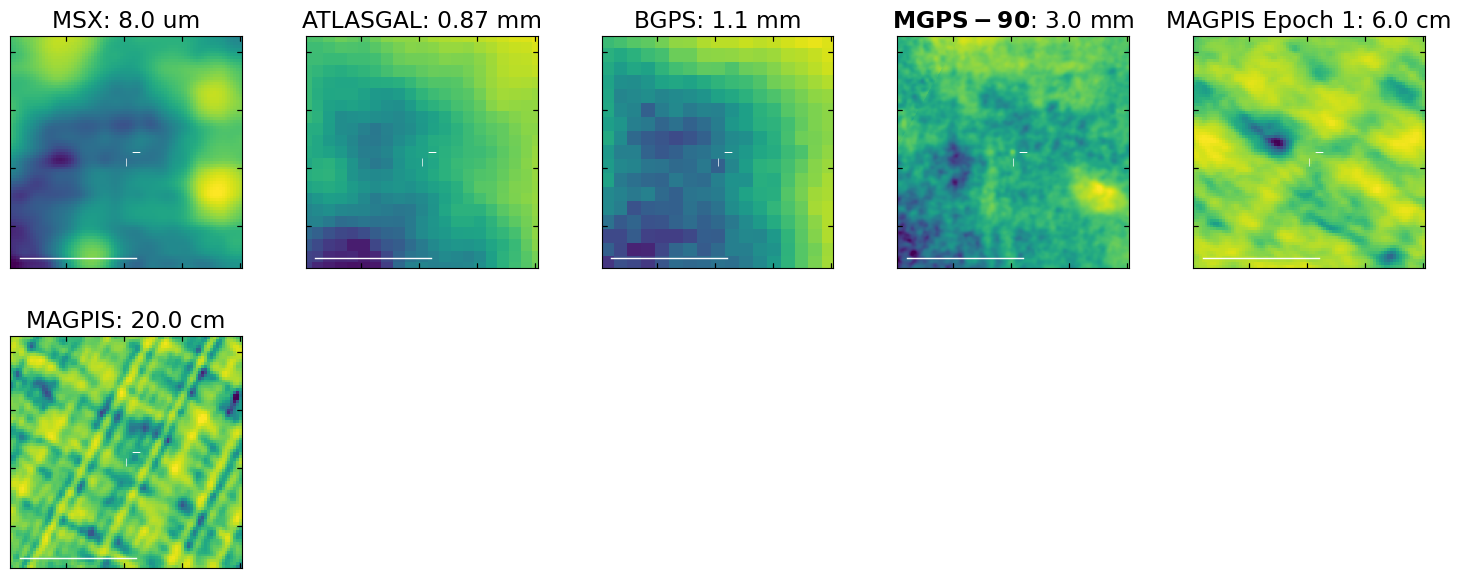

In [548]:
make_sed_plot(coordinate=coord, 
    mgpsfile='/orange/adamginsburg/ACES/mosaics/continuum/12m_continuum_commonbeam_circular_reimaged_mosaic_MUSTANGfeathered.fits',
              regname='SgrB2'
             )

#pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_cutouts.pdf', bbox_inches='tight')

In [549]:
higal_ims = HiGal.get_images(coord, radius=1*u.arcmin)
higal_ims

Getting image list at <SkyCoord (ICRS): (ra, dec) in deg
    (266.49063772, -28.95299151)> with 1.0 arcmin


[]

In [568]:
ims = {
    '3.6um': '/orange/adamginsburg/cmz/glimpse_data/GLM_00000+0000_mosaic_I1.fits',
    '4.5um': '/orange/adamginsburg/cmz/glimpse_data/GLM_00000+0000_mosaic_I2.fits',
    '5.8um': '/orange/adamginsburg/cmz/glimpse_data/GLM_00000+0000_mosaic_I3.fits',
    '8.0um': '/orange/adamginsburg/cmz/glimpse_data/GLM_00000+0000_mosaic_I4.fits',
    '24um': '/orange/adamginsburg/cmz/mipsgal_24micron_data/gc_mosaic_MIPSGAL_gal.fits',
    '70um': '/orange/adamginsburg/cmz/herschel/destripe_l000_blue_wgls_rcal.fits',
    '160um': '/orange/adamginsburg/cmz/herschel/destripe_l000_red_wgls_rcal.fits',
    '250um': '/orange/adamginsburg/cmz/herschel/destripe_l000_PSW_wgls_rcal.fits',
    '350um': '/orange/adamginsburg/cmz/herschel/destripe_l000_PMW_wgls_rcal.fits',
    '500um': '/orange/adamginsburg/cmz/herschel/destripe_l000_PLW_wgls_rcal.fits',
    '3mm': '/orange/adamginsburg/ACES/mosaics/continuum/12m_continuum_commonbeam_circular_reimaged_mosaic_MUSTANGfeathered.fits',
    '20cm': '/orange/adamginsburg/cmz/meerkat/MeerKAT_Galactic_Centre_1284MHz-StokesI.fits'
}

In [803]:
import matplotlib.colors as mcolors
import numpy as np
from astropy.visualization import simple_norm

colors1 = pl.cm.gray_r(np.linspace(0., 1, 128))
colors2 = pl.cm.hot(np.linspace(0, 1, 128))

colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

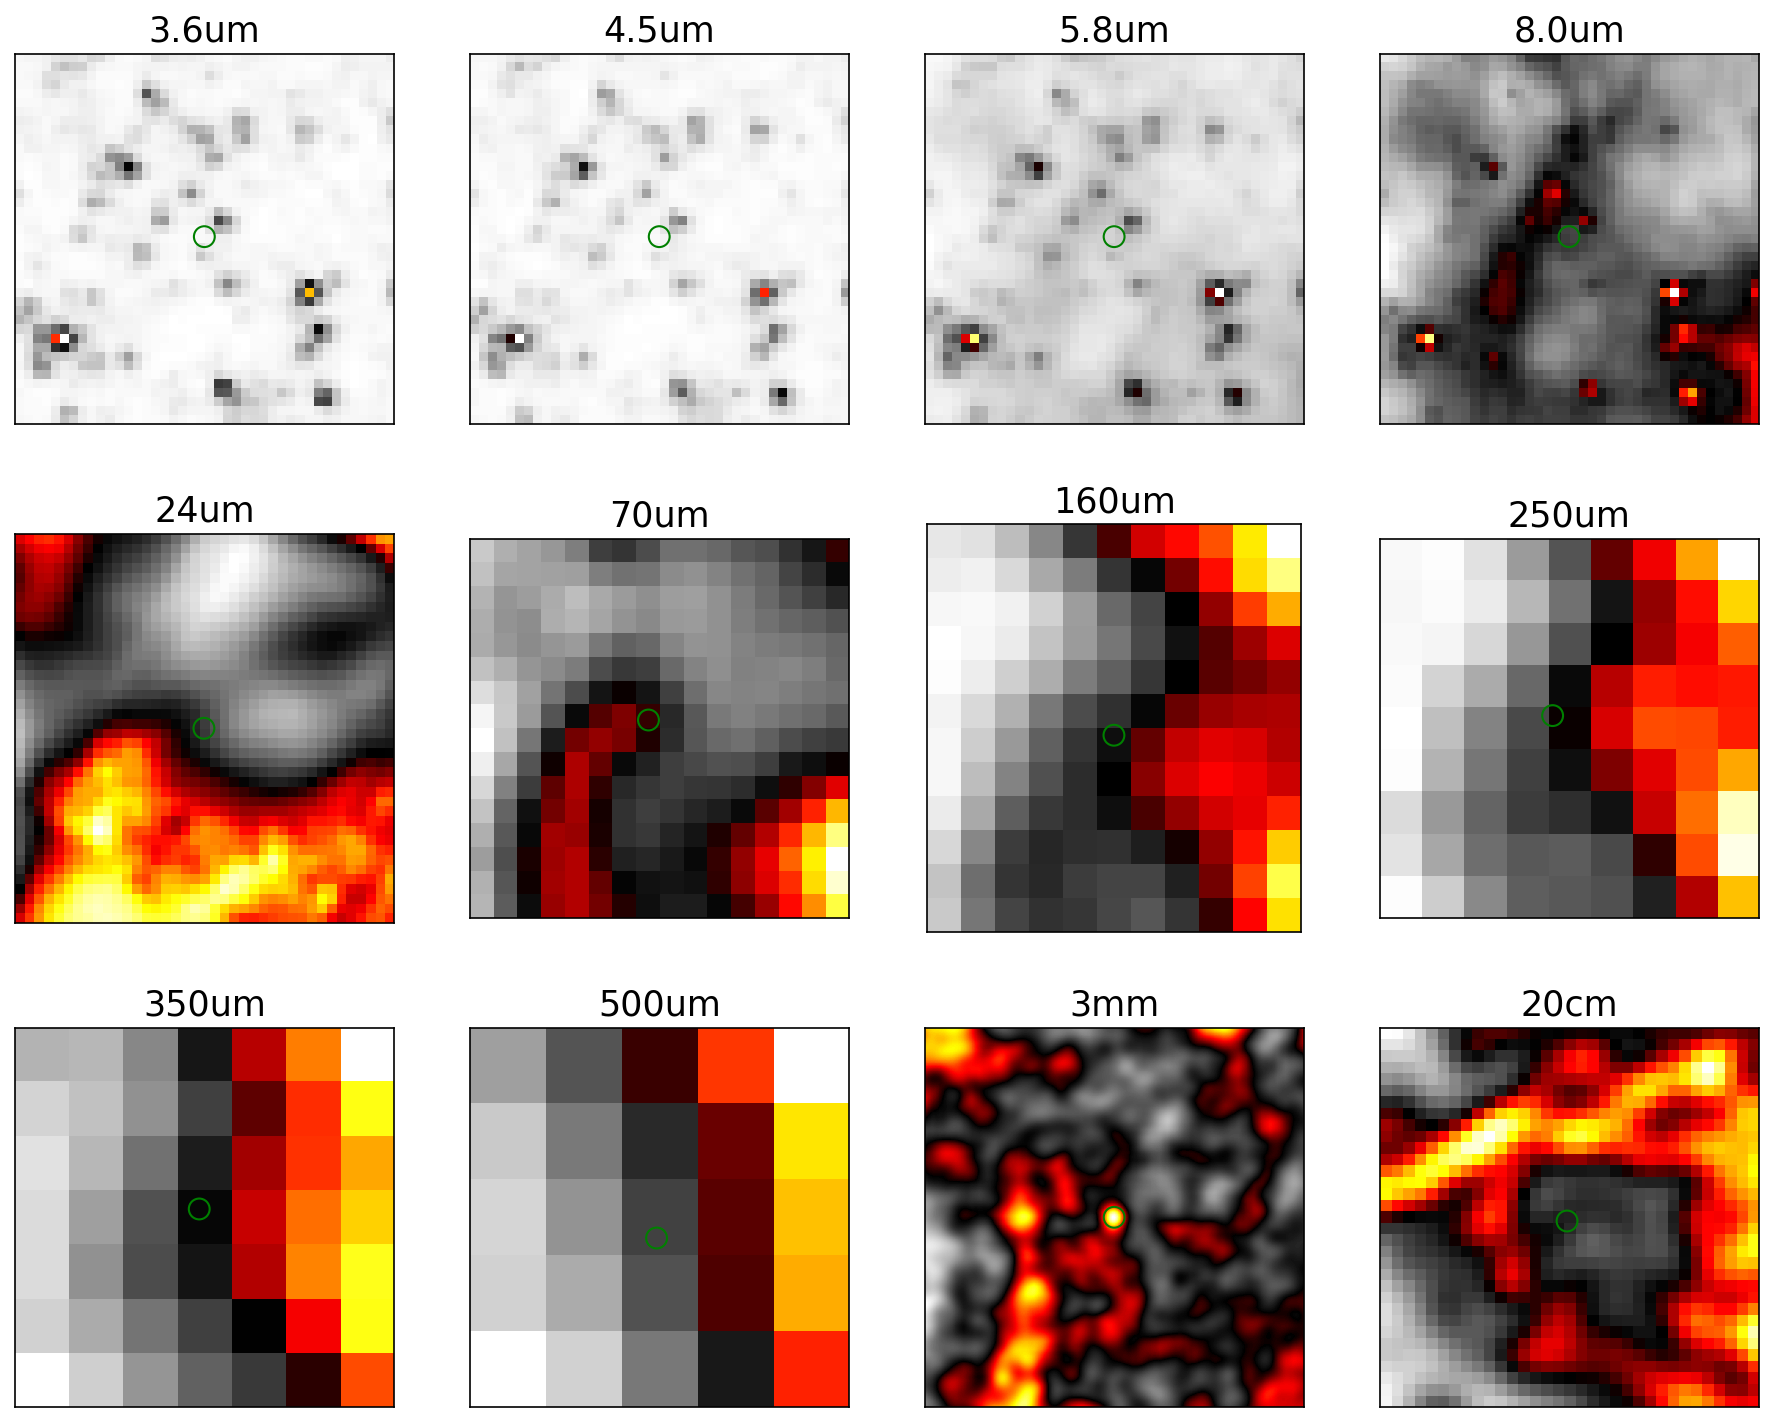

In [572]:
pl.figure(figsize=(15,12), dpi=150)
ii = 1
for wl, fn in ims.items():
    fh = fits.open(fn)
    ww = WCS(fh[0].header).celestial
    msk = bigregion.to_pixel(ww).to_mask()
    slcs, _ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
    co = msk.cutout(fh[0].data.squeeze())
    ax = pl.subplot(3,4,ii, projection=ww[slcs])
    ax.imshow(co, cmap=mymap)
    ax.scatter_coord(coord, marker='o', facecolor='none', edgecolor='g', s=100)
    #pl.xticks([])
    #pl.yticks([])
    #pl.xlabel("")
    #pl.ylabel("")
    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ax.set_title(wl)
    ii += 1

pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/continuum_cutouts.pdf', bbox_inches='tight')

### Chandra 

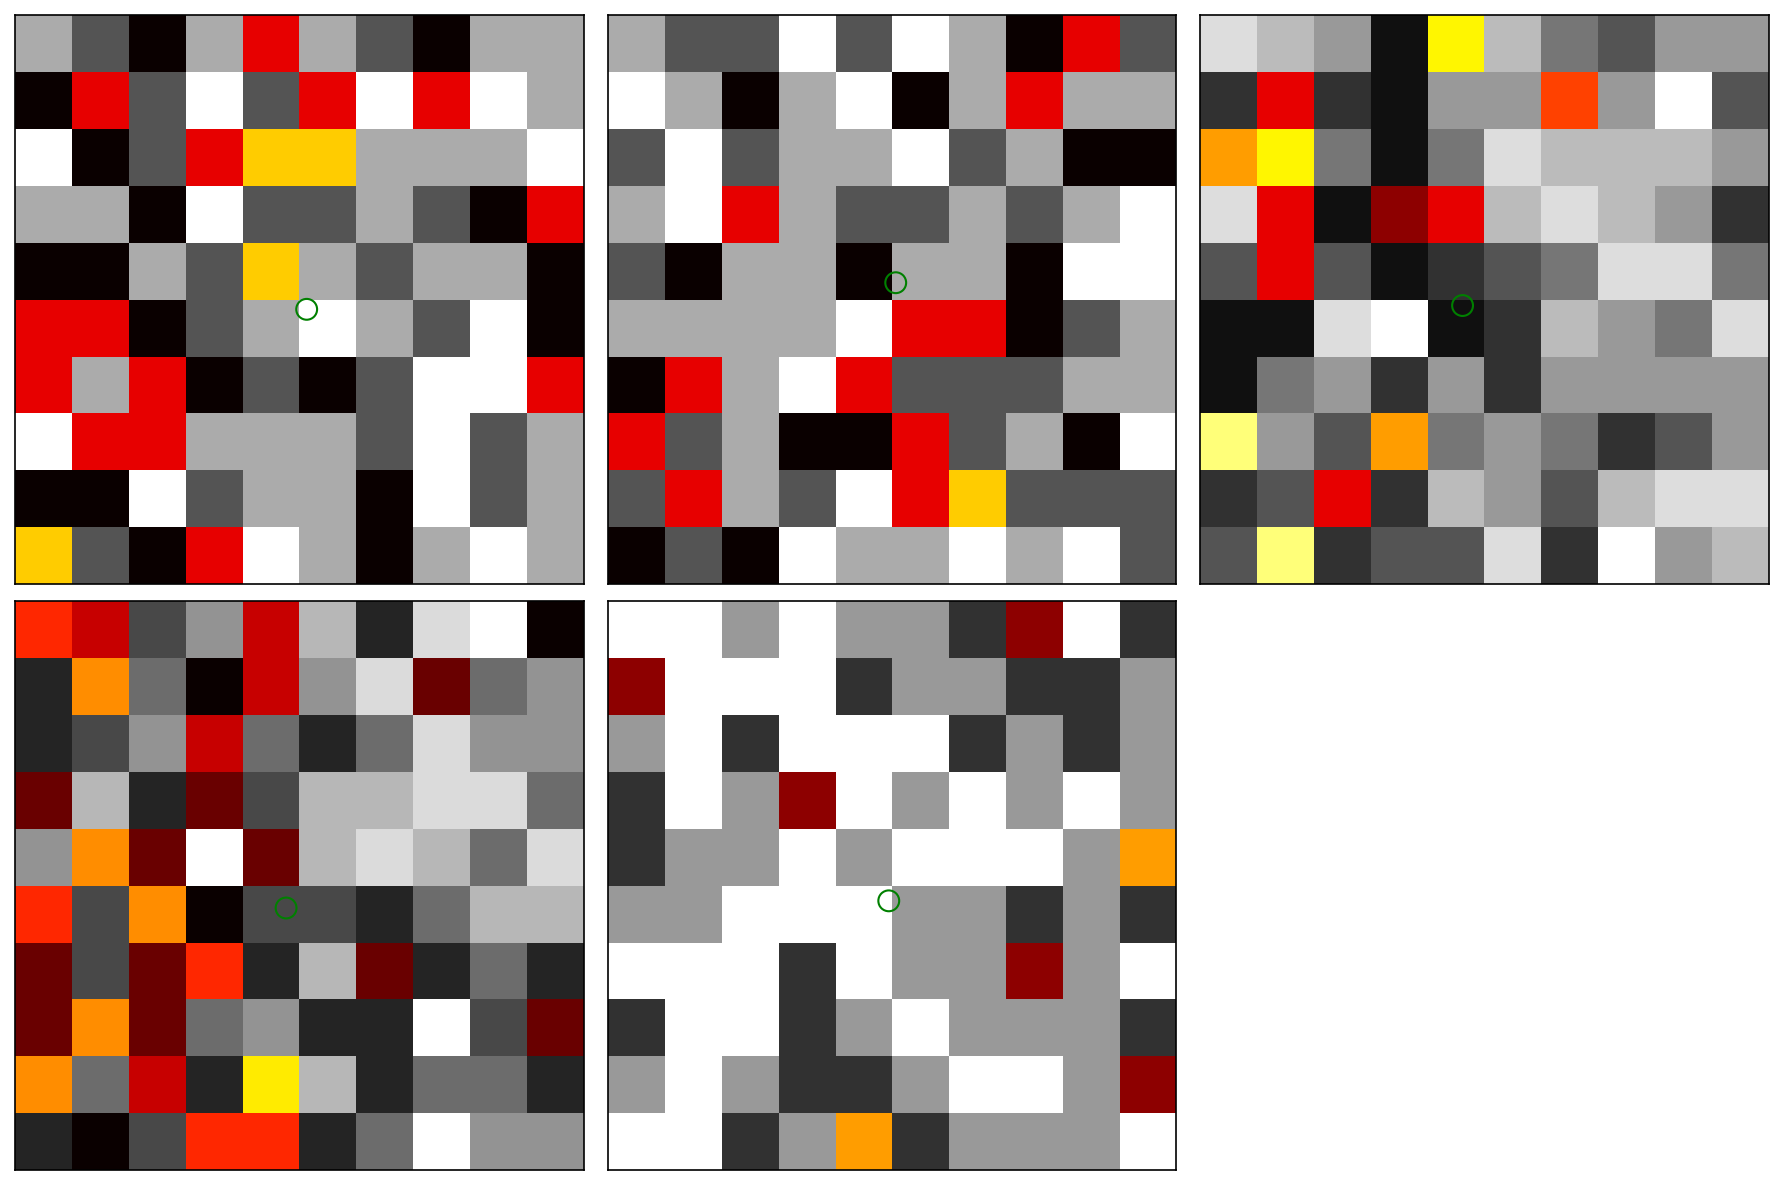

In [806]:
pl.figure(figsize=(12,8), dpi=150)
ii = 1
for fn in glob.glob('/orange/adamginsburg/cmz/chandra/sgra/acis*fits'):
    fh = fits.open(fn)
    ww = WCS(fh[0].header).celestial
    msk = bigregion.to_pixel(ww).to_mask()
    slcs, _ = msk.get_overlap_slices(fh[0].data.squeeze().shape)
    co = msk.cutout(fh[0].data.squeeze())
    ax = pl.subplot(2,3,ii, projection=ww[slcs])
    ax.imshow(co, cmap=mymap)
    ax.scatter_coord(coord, marker='o', facecolor='none', edgecolor='g', s=100)

    lon = ax.coords[0]
    lat = ax.coords[1]
    lon.set_ticks_visible(False)
    lon.set_ticklabel_visible(False)
    lat.set_ticks_visible(False)
    lat.set_ticklabel_visible(False)
    lon.set_axislabel('')
    lat.set_axislabel('')
    ii += 1

pl.tight_layout()
pl.savefig('/orange/adamginsburg/ACES/broadline_sources/G0.025-0.073/chandra_overlays.pdf', bbox_inches='tight')